# Final pipelines from 21.04.2025


In [ ]:
!pip install statsmodels

In [ ]:
!pip install tensorflow

In [ ]:
!pip install --upgrade numpy
pip install tqdm


ERROR: Operation cancelled by user


## Data import and, analysis and preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# Mount Google Drive to access your files
from google.colab import drive
drive.mount('/content/drive')

# Load the original dataset
hpi_data = pd.read_csv(
    "/content/drive/MyDrive/thesis data/ukhpi-property-type-hpi-united-kingdom-from-1968-01-01-to-2024-11-01.csv",
    usecols=["Period", "House price index All property types"]
)

# Rename columns for clarity
hpi_data.rename(columns={"Period": "Date", "House price index All property types": "HPI_All"}, inplace=True)

# Ensure 'Date' is datetime and data is sorted
hpi_data["Date"] = pd.to_datetime(hpi_data["Date"])
hpi_data.sort_values("Date", inplace=True)

# Set date as index immediately (better handling of time series)
hpi_data.set_index("Date", inplace=True)

# Check data overview
hpi_data.info()
hpi_data.head()


Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 679 entries, 1968-04-01 to 2024-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   HPI_All  679 non-null    float64
dtypes: float64(1)
memory usage: 10.6 KB


HPI_All
Date               
1968-04-01     1.89
1968-05-01     1.89
1968-06-01     1.89
1968-07-01     1.95
1968-08-01     1.95

In [ ]:
# Convert the entire dataset explicitly to Quarterly frequency (Quarter-end December)
hpi_quarterly = hpi_data.resample('QE-DEC').last()

# Quick check after resampling
print(hpi_quarterly.head())
print(hpi_quarterly.tail())


            HPI_All
Date               
1968-06-30     1.89
1968-09-30     1.95
1968-12-31     1.94
1969-03-31     1.97
1969-06-30     2.00
            HPI_All
Date               
2023-12-31    145.8
2024-03-31    145.5
2024-06-30    149.8
2024-09-30    152.9
2024-12-31    153.2


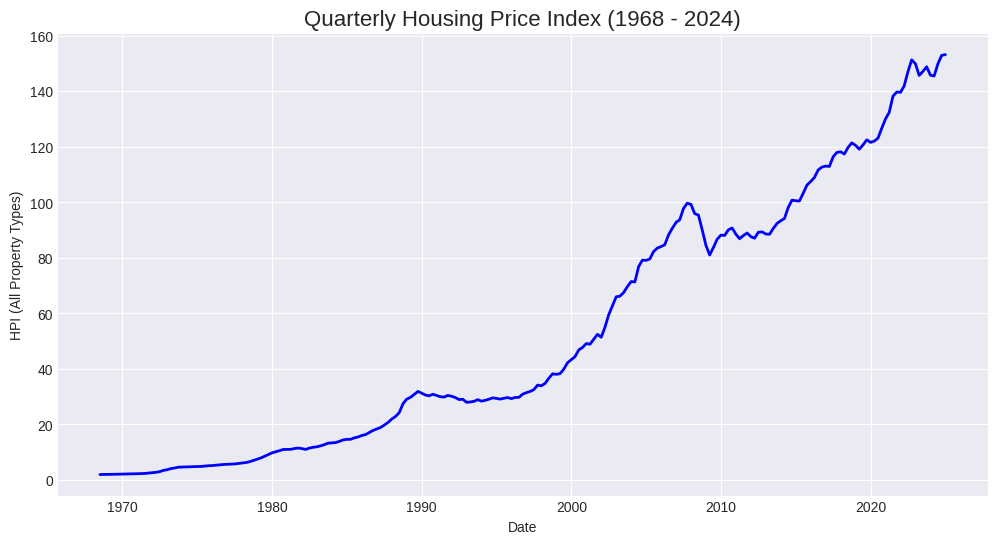

In [ ]:
# Plot quarterly HPI clearly
plt.figure(figsize=(12, 6))
plt.plot(hpi_quarterly.index, hpi_quarterly["HPI_All"], linestyle='-', color='blue', linewidth=2)
plt.title("Quarterly Housing Price Index (1968 - 2024)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("HPI (All Property Types)")
plt.grid(True)
plt.show()


### 1st Comment

**Documentation** for Notebook (Initial Data Import and Visualization)
Step 1: Initial Data Import and Preparation

In this step, the original UK House Price Index (HPI) dataset spanning from April 1968 to October 2024 is imported. The original dataset contains monthly and quarterly observations of the housing price index across all property types. For clarity and simplicity in subsequent analyses, the columns were explicitly renamed to "Date" and "HPI_All". Additionally, the "Date" column was explicitly converted to the datetime format to ensure accurate time-series handling.

The dataset consists of:

Total Observations: 679 entries

Time Span: April 1968 – October 2024

Data Frequency: Mixed (Quarterly before 2002, Monthly after 2002)

Columns:

HPI_All: Housing Price Index for all property types (Float64)

After setting "Date" as the DataFrame index, the data was explicitly sorted chronologically to preserve correct temporal order.

Step 2: Converting to Uniform Quarterly Data

To ensure consistency and avoid potential biases from mixing different data frequencies, the dataset was explicitly resampled to a uniform quarterly frequency, specifically quarter-end periods (March, June, September, December). The resampling approach chosen was to select the last monthly observation within each quarter. This is the most accurate method to represent quarterly economic reality without introducing interpolation biases.

Resampling Method: Quarterly End frequency (QE-DEC), selecting the last observation of each quarter.

Resulting Observations: Clearly uniform quarterly intervals, allowing robust time-series modeling.

Step 3: Visualization and Initial Insights

The provided plot shows the clearly visualized quarterly Housing Price Index (HPI) from 1968 to 2024. The plot reveals several key insights:

General Upward Trend: A clear long-term increase is visible, indicating substantial growth in UK housing prices over the decades.

Significant Market Shifts: There are noticeable periods of accelerated growth (e.g., late 1980s, mid-2000s, and post-2010), and periods of relative stability or downturn (e.g., early 1990s, 2008 financial crisis period).

Recent Observations (Post-2020): Despite global economic uncertainties such as the COVID-19 pandemic and subsequent inflationary pressures, the UK housing market has shown sustained growth.

This visualization helps justify the choice of further modeling and confirms the presence of a clear trend that must be addressed explicitly in stationarity testing and differencing.

### ADF tests and differencing 12.05.2025

In [ ]:
# 2) Take log
hpi = hpi_quarterly.copy()
hpi["logHPI"] = np.log(hpi.iloc[:,0])

# 3) Compute diffs
hpi["d1"] = hpi["logHPI"].diff()
hpi["d2"] = hpi["d1"].diff()

from statsmodels.tsa.stattools import adfuller

def adf_tests(series, name):
    print(f"\n=== ADF tests for {name} ===")
    for reg in ["n", "c", "ct"]:
        res = adfuller(series.dropna(), regression=reg, autolag="AIC")
        print(f"reg='{reg}':  ADF stat = {res[0]: .4f}, p={res[1]:.4f}, lags={res[2]}")
        for cv, val in res[4].items():
            print(f"    critical {cv}: {val:.4f}")
    print()

# assuming hpi already has logHPI, d1, d2 columns:
adf_tests(hpi["logHPI"],    "log-level HPI")
adf_tests(hpi["d1"],         "1st diff (log Δ HPI)")
adf_tests(hpi["d2"],         "2nd diff")



=== ADF tests for log-level HPI ===
reg='n':  ADF stat =  1.3943, p=0.9589, lags=13
    critical 1%: -2.5763
    critical 5%: -1.9423
    critical 10%: -1.6156
reg='c':  ADF stat = -3.1343, p=0.0241, lags=14
    critical 1%: -3.4616
    critical 5%: -2.8753
    critical 10%: -2.5741
reg='ct':  ADF stat = -2.2340, p=0.4708, lags=14
    critical 1%: -4.0021
    critical 5%: -3.4314
    critical 10%: -3.1393


=== ADF tests for 1st diff (log Δ HPI) ===
reg='n':  ADF stat = -2.0126, p=0.0423, lags=15
    critical 1%: -2.5765
    critical 5%: -1.9424
    critical 10%: -1.6156
reg='c':  ADF stat = -2.8537, p=0.0510, lags=15
    critical 1%: -3.4619
    critical 5%: -2.8754
    critical 10%: -2.5742
reg='ct':  ADF stat = -3.3906, p=0.0527, lags=15
    critical 1%: -4.0025
    critical 5%: -3.4316
    critical 10%: -3.1395


=== ADF tests for 2nd diff ===
reg='n':  ADF stat = -6.4055, p=0.0000, lags=14
    critical 1%: -2.5765
    critical 5%: -1.9424
    critical 10%: -1.6156
reg='c':  ADF s

In [ ]:
# e.g.
# 1) Compute log‐return
hpi["logHPI"] = np.log(hpi_quarterly["HPI_All"])
hpi["d1"]      = hpi["logHPI"].diff()

# 2) ADF + KPSS on d1 with regression='c'
from statsmodels.tsa.stattools import kpss
adf_res = adfuller(hpi["d1"].dropna(), regression="c", autolag="AIC")
kpss_res = kpss(hpi["d1"].dropna(), regression="c", nlags="auto")

print("ADF p-value:", adf_res[1])
print("KPSS p-value:", kpss_res[1])


ADF p-value: 0.05100303909030445
KPSS p-value: 0.01970332079956828


### Compute and Analyze Differenced HPI Series 13.05.2025

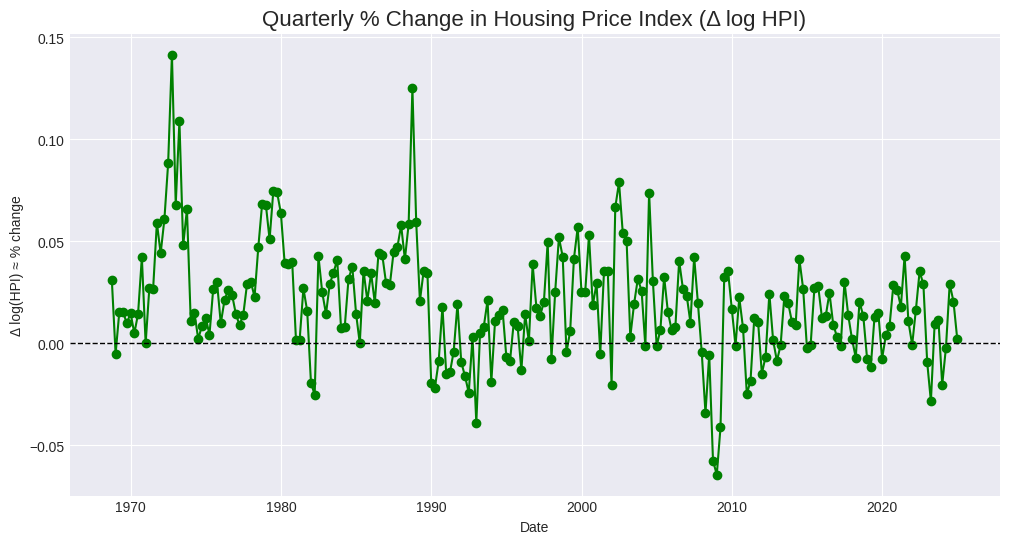

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Compute quarterly log-level HPI
hpi_quarterly["logHPI"] = np.log(hpi_quarterly["HPI_All"])

# 2) Take a first difference of the log-HPI (approx. quarter-over-quarter % changes)
hpi_quarterly["HPI_log_diff"] = hpi_quarterly["logHPI"].diff()

# 3) Drop NaNs introduced by differencing
hpi_pct = hpi_quarterly["HPI_log_diff"].dropna()

# 4) Plot the log-differences (i.e. percent changes)
plt.figure(figsize=(12, 6))
plt.plot(
    hpi_pct.index,
    hpi_pct,
    marker="o",
    linestyle="-",
    color="green"
)
plt.title("Quarterly % Change in Housing Price Index (Δ log HPI)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Δ log(HPI) ≈ % change")
plt.grid(True)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.show()


### ADF Stationarity Test (Critical Analysis Step)

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def full_stationarity_checks(series, name):
    print(f"\n=== Augmented Dickey–Fuller tests on {name} ===")
    for reg in ["n", "c", "ct"]:
        stat, pval, lags, _, crit, _ = adfuller(
            series, regression=reg, autolag="AIC"
        )
        print(f" reg='{reg}': ADF stat = {stat:.4f}, p = {pval:.4f}, lags = {lags}")
        for cv, val in crit.items():
            print(f"    critical {cv}: {val:.4f}")
    print("\n=== KPSS test ===")
    kstat, kpval, klags, kcrit = kpss(series, regression="c", nlags="auto")
    print(f" KPSS stat = {kstat:.4f}, p = {kpval:.4f}, lags = {klags}")
    for cv, val in kcrit.items():
        print(f"    critical {cv}: {val:.4f}")
    print(
        "\nInterpretation:\n"
        " • ADF p<0.05 → reject unit root → series is stationary.\n"
        " • KPSS p>0.05 → fail to reject stationarity.\n"
    )

# run on Δ log HPI
full_stationarity_checks(hpi_pct.values, "Δ log(HPI) ≈ % change")



=== Augmented Dickey–Fuller tests on Δ log(HPI) ≈ % change ===
 reg='n': ADF stat = -2.0126, p = 0.0423, lags = 15
    critical 1%: -2.5765
    critical 5%: -1.9424
    critical 10%: -1.6156
 reg='c': ADF stat = -2.8537, p = 0.0510, lags = 15
    critical 1%: -3.4619
    critical 5%: -2.8754
    critical 10%: -2.5742
 reg='ct': ADF stat = -3.3906, p = 0.0527, lags = 15
    critical 1%: -4.0025
    critical 5%: -3.4316
    critical 10%: -3.1395

=== KPSS test ===
 KPSS stat = 0.6323, p = 0.0197, lags = 8
    critical 10%: 0.3470
    critical 5%: 0.4630
    critical 2.5%: 0.5740
    critical 1%: 0.7390

Interpretation:
 • ADF p<0.05 → reject unit root → series is stationary.
 • KPSS p>0.05 → fail to reject stationarity.



In [ ]:
hpi_quarterly

HPI_All    logHPI  HPI_log_diff
Date                                       
1968-06-30     1.89  0.636577           NaN
1968-09-30     1.95  0.667829      0.031253
1968-12-31     1.94  0.662688     -0.005141
1969-03-31     1.97  0.678034      0.015346
1969-06-30     2.00  0.693147      0.015114
...             ...       ...           ...
2023-12-31   145.80  4.982236     -0.020367
2024-03-31   145.50  4.980176     -0.002060
2024-06-30   149.80  5.009301      0.029125
2024-09-30   152.90  5.029784      0.020483
2024-12-31   153.20  5.031744      0.001960

[227 rows x 3 columns]

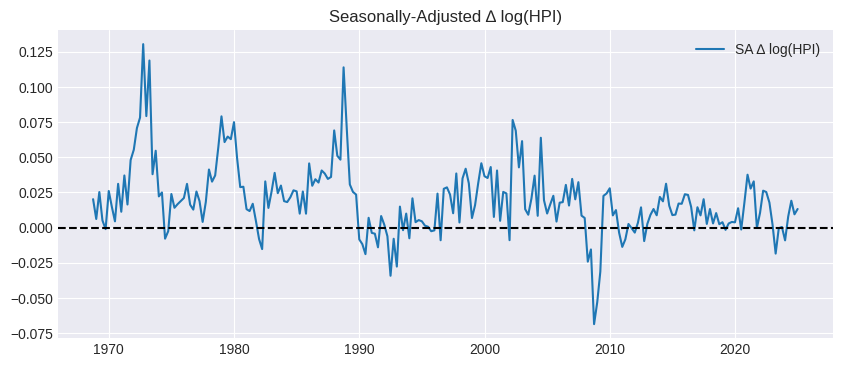


--- ADF on SA ∆ log(HPI) ---
 reg=n: stat=-2.3815, p=0.0166, lags=7
    1%% crit: -2.5761
    5%% crit: -1.9423
    10%% crit: -1.6157
 reg=c: stat=-4.3119, p=0.0004, lags=5
    1%% crit: -3.4604
    5%% crit: -2.8748
    10%% crit: -2.5738
 reg=ct: stat=-5.8665, p=0.0000, lags=4
    1%% crit: -4.0003
    5%% crit: -3.4305
    10%% crit: -3.1388

--- KPSS on SA ∆ log(HPI) ---
 stat=0.5289, p=0.0351
    10%% crit: 0.3470
    5%% crit: 0.4630
    2.5%% crit: 0.5740
    1%% crit: 0.7390


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

# 1) Compute log-level and drop initial NaN
logHPI = np.log(hpi_quarterly["HPI_All"])
logHPI = logHPI.dropna()

# 2) Seasonal decomposition (additive) at quarterly freq
decomp = seasonal_decompose(logHPI, model="additive", period=4)

# 3) Form seasonally-adjusted log-series
hpi_quarterly["logHPI_sa"] = (logHPI - decomp.seasonal).reindex(hpi_quarterly.index)

# 4) First difference of SA log
hpi_quarterly["dlogHPI_sa"] = hpi_quarterly["logHPI_sa"].diff()

# 5) Quick plot
plt.figure(figsize=(10,4))
plt.plot(hpi_quarterly["dlogHPI_sa"], label="SA ∆ log(HPI)")
plt.axhline(0, color="k", ls="--")
plt.title("Seasonally-Adjusted ∆ log(HPI)")
plt.legend()
plt.show()

# 6) Stationarity checks
def stationarity_checks(x, name):
    x = x.dropna()
    print(f"\n--- ADF on {name} ---")
    for reg in ["n","c","ct"]:
        res = adfuller(x, regression=reg, autolag="AIC")
        print(f" reg={reg}: stat={res[0]: .4f}, p={res[1]:.4f}, lags={res[2]}")
        for cv,val in res[4].items():
            print(f"    {cv}% crit: {val:.4f}")
    print(f"\n--- KPSS on {name} ---")
    kstat, kp, nlags, cvs = kpss(x, regression="c", nlags="legacy")
    print(f" stat={kstat:.4f}, p={kp:.4f}")
    for cv,val in cvs.items():
        print(f"    {cv}% crit: {val:.4f}")

stationarity_checks(hpi_quarterly["dlogHPI_sa"], "SA ∆ log(HPI)")


In [ ]:
hpi_quarterly

HPI_All    logHPI  HPI_log_diff  logHPI_sa  dlogHPI_sa
Date                                                              
1968-06-30     1.89  0.636577           NaN   0.636797         NaN
1968-09-30     1.95  0.667829      0.031253   0.656967    0.020171
1968-12-31     1.94  0.662688     -0.005141   0.663065    0.006098
1969-03-31     1.97  0.678034      0.015346   0.688299    0.025234
1969-06-30     2.00  0.693147      0.015114   0.693367    0.005068
...             ...       ...           ...        ...         ...
2023-12-31   145.80  4.982236     -0.020367   4.982613   -0.009128
2024-03-31   145.50  4.980176     -0.002060   4.990441    0.007829
2024-06-30   149.80  5.009301      0.029125   5.009521    0.019079
2024-09-30   152.90  5.029784      0.020483   5.018922    0.009401
2024-12-31   153.20  5.031744      0.001960   5.032121    0.013199

[227 rows x 5 columns]

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(logHPI, model="additive", period=4)


trend     = result.trend
seasonal  = result.seasonal
resid     = result.resid


In [ ]:
resid

Date
1968-06-30         NaN
1968-09-30         NaN
1968-12-31   -0.005288
1969-03-31    0.008466
1969-06-30    0.002231
                ...   
2023-12-31   -0.008693
2024-03-31   -0.006535
2024-06-30    0.002958
2024-09-30         NaN
2024-12-31         NaN
Freq: QE-DEC, Name: resid, Length: 227, dtype: float64

### ACF/PACF Analysis

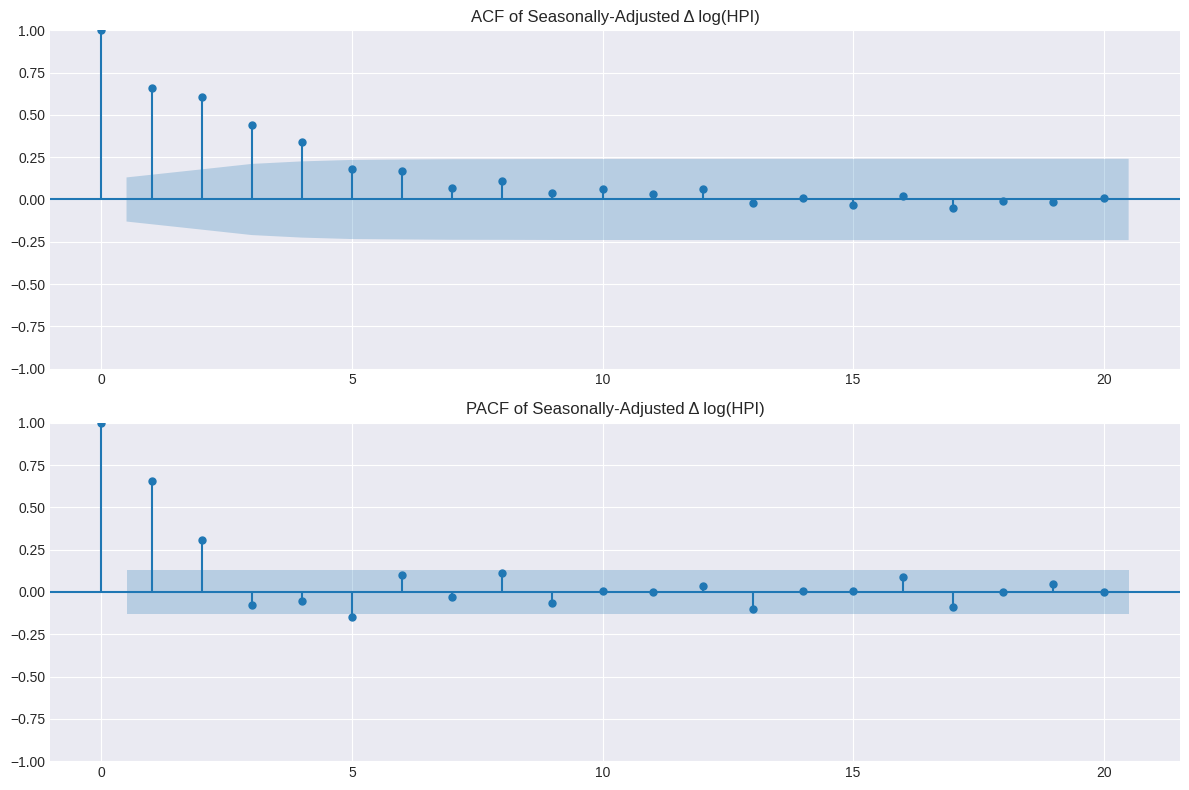

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1) Select the new stationary series and drop NaNs
series = hpi_quarterly["dlogHPI_sa"].dropna()

# 2) Plot ACF & PACF to pick AR/MA orders (use 20 lags, since quarterly data)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(series, lags=20, ax=axes[0])
plot_pacf(series, lags=20, method="ywm", ax=axes[1])

axes[0].set_title("ACF of Seasonally-Adjusted Δ log(HPI)")
axes[1].set_title("PACF of Seasonally-Adjusted Δ log(HPI)")

plt.tight_layout()
plt.show()



In [ ]:
# 3) (Optional) Use a small IC‐based grid search to confirm p and q
from statsmodels.tsa.stattools import arma_order_select_ic
order_res = arma_order_select_ic(series, max_ar=4, max_ma=4, ic=['aic','bic'], trend='n')
print(order_res.aic_min_order, order_res.bic_min_order)

# 4) Build the final DataFrame for your pipelines
final_hpi_data = hpi_quarterly[["dlogHPI_sa"]].copy().dropna()
print(final_hpi_data.head())
print(final_hpi_data.tail())


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: Use

(np.int64(2), np.int64(3)) (np.int64(2), np.int64(0))
            dlogHPI_sa
Date                  
1968-09-30    0.020171
1968-12-31    0.006098
1969-03-31    0.025234
1969-06-30    0.005068
1969-09-30   -0.001131
            dlogHPI_sa
Date                  
2023-12-31   -0.009128
2024-03-31    0.007829
2024-06-30    0.019079
2024-09-30    0.009401
2024-12-31    0.013199


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             dlogHPI_sa   No. Observations:                  226
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 581.386
Date:                Sun, 25 May 2025   AIC                          -1156.772
Time:                        10:00:31   BIC                          -1146.510
Sample:                    09-30-1968   HQIC                         -1152.631
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5039      0.053      9.485      0.000       0.400       0.608
ar.L2          0.3538      0.053      6.704      0.000       0.250       0.457
sigma2         0.0003   2.24e-05     15.178      0.0

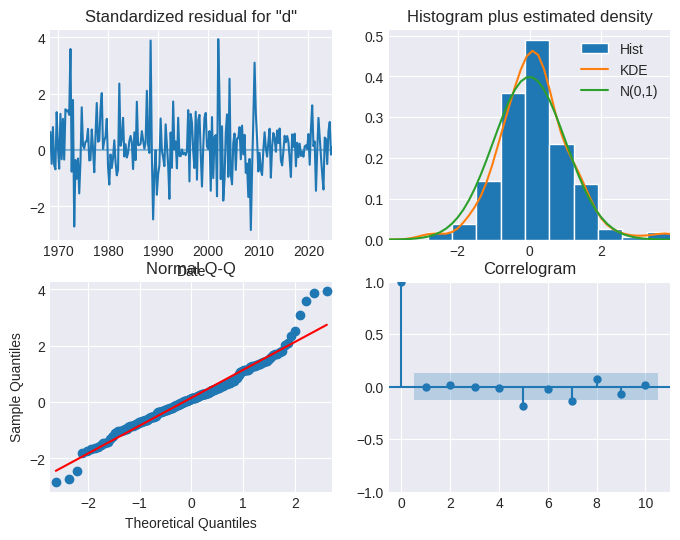

                               SARIMAX Results                                
Dep. Variable:             dlogHPI_sa   No. Observations:                  226
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 581.555
Date:                Sun, 25 May 2025   AIC                          -1155.110
Time:                        10:00:31   BIC                          -1141.428
Sample:                    09-30-1968   HQIC                         -1149.588
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4093      0.136      3.015      0.003       0.143       0.675
ar.L2          0.4279      0.113      3.794      0.000       0.207       0.649
ma.L1          0.1090      0.157      0.694      0.4

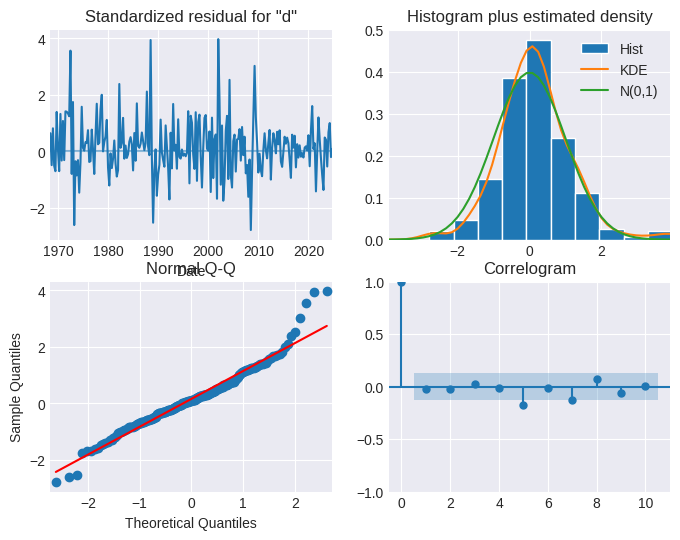

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1) Try a simple AR(2)
mod = SARIMAX(series, order=(2,0,0), trend='n')
res = mod.fit(disp=False, maxiter=500, method='powell')

print(res.summary())
res.plot_diagnostics(figsize=(8,6))
plt.show()

# 2) If residuals still show MA‐type autocorr, bump to ARIMA(2,0,1):
mod2 = SARIMAX(series, order=(2,0,1), trend='n')
res2 = mod2.fit(disp=False, maxiter=500, method='powell')

print(res2.summary())
res2.plot_diagnostics(figsize=(8,6))
plt.show()


## ARIMA params grid search with rolling window


init=0.60, ARIMA(0,0,0) → RMSE=5.5746
init=0.60, ARIMA(0,0,1) → RMSE=5.1924
init=0.60, ARIMA(0,0,2) → RMSE=4.7821
init=0.60, ARIMA(0,0,3) → RMSE=4.5923
init=0.60, ARIMA(1,0,0) → RMSE=4.4423
init=0.60, ARIMA(1,0,1) → RMSE=4.3924
init=0.60, ARIMA(1,0,2) → RMSE=4.5073
init=0.60, ARIMA(1,0,3) → RMSE=4.6075
init=0.60, ARIMA(2,0,0) → RMSE=4.4239
init=0.60, ARIMA(2,0,1) → RMSE=4.4198
init=0.60, ARIMA(2,0,2) → RMSE=4.7714
init=0.60, ARIMA(2,0,3) → RMSE=4.5266
init=0.60, ARIMA(3,0,0) → RMSE=4.4352
init=0.60, ARIMA(3,0,1) → RMSE=4.4698
init=0.60, ARIMA(3,0,2) → RMSE=4.4102
init=0.60, ARIMA(3,0,3) → RMSE=4.6443
init=0.70, ARIMA(0,0,0) → RMSE=6.1042
init=0.70, ARIMA(0,0,1) → RMSE=5.6499
init=0.70, ARIMA(0,0,2) → RMSE=5.1315
init=0.70, ARIMA(0,0,3) → RMSE=4.9048
init=0.70, ARIMA(1,0,0) → RMSE=4.6780
init=0.70, ARIMA(1,0,1) → RMSE=4.5738
init=0.70, ARIMA(1,0,2) → RMSE=4.6692
init=0.70, ARIMA(1,0,3) → RMSE=4.7522
init=0.70, ARIMA(2,0,0) → RMSE=4.5888
init=0.70, ARIMA(2,0,1) → RMSE=4.5837
init=0.70, A

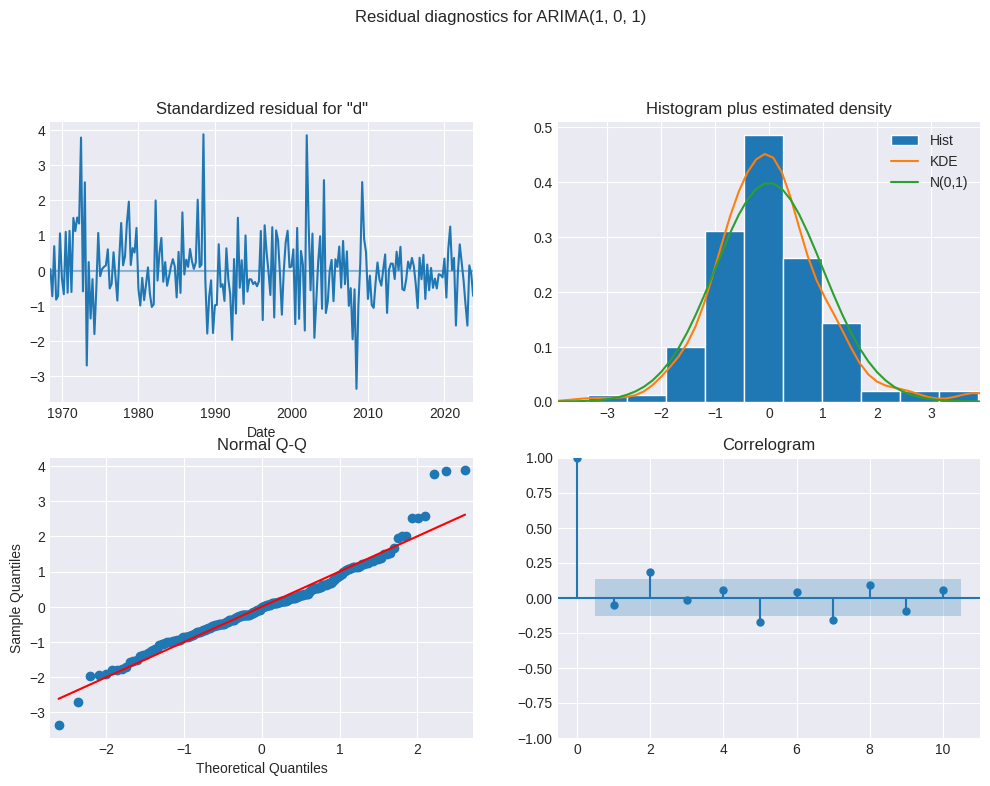



=== Diagnostics for ARIMA(2, 0, 0), init_frac=0.80 ===
h= 1: MAE=1.1896, RMSE=1.5977
h= 2: MAE=2.1508, RMSE=2.9600
h= 3: MAE=3.3158, RMSE=4.3882
h= 4: MAE=4.2675, RMSE=5.4818
→ Overall: MAE=2.7309, RMSE=3.8930

Final model summary:

                               SARIMAX Results                                
Dep. Variable:             dlogHPI_sa   No. Observations:                  222
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 573.958
Date:                Sat, 17 May 2025   AIC                          -1139.915
Time:                        16:10:09   BIC                          -1126.305
Sample:                    09-30-1968   HQIC                         -1134.420
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

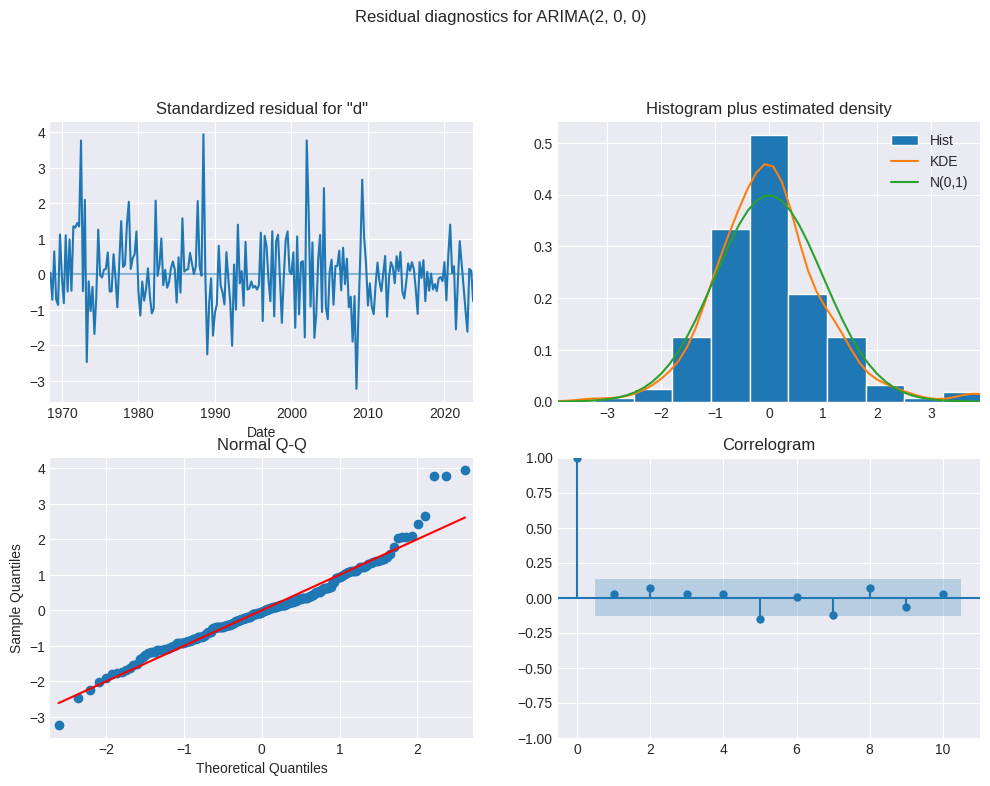

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------------------------------------------------------
# 1) Prep your DataFrame
# -----------------------------------------------------------------------------
df = hpi_quarterly[["HPI_All", "logHPI_sa", "dlogHPI_sa"]].copy()
df = df.dropna(subset=["logHPI_sa", "dlogHPI_sa"])   # remove any leading NaNs

# -----------------------------------------------------------------------------
# 2) Rolling-expanding ARIMA grid-search function
# -----------------------------------------------------------------------------
def run_arima_grid(data, p_values, q_values, init_fracs, fh=4):
    """
    Expand-window rolling forecasts of HPI using ARIMA on dlogHPI_sa.
    Returns a DataFrame of MAE/RMSE for each (p,0,q), init_frac.
    """
    results = []
    n = len(data)

    for init_frac in init_fracs:
        init_n = max(int(n * init_frac), fh+1)
        for p in p_values:
            for q in q_values:
                all_fc, all_ac = [], []
                # rolling-expanding
                for i in range(init_n, n - fh + 1):
                    train = data.iloc[:i]
                    test  = data.iloc[i:i+fh]

                    # 1) fit ARIMA on dlog
                    try:
                        m = ARIMA(train["dlogHPI_sa"], order=(p,0,q)).fit()
                        dlog_fc = m.forecast(steps=fh)
                    except:
                        # if it blows up
                        dlog_fc = pd.Series([np.nan]*fh, index=test.index)

                    # 2) back out log-level forecast
                    last_log = train["logHPI_sa"].iloc[-1]
                    log_fc  = last_log + dlog_fc.cumsum()
                    # 3) exponentiate for level
                    level_fc = np.exp(log_fc)

                    all_fc.extend(level_fc.values)
                    all_ac.extend(test["HPI_All"].values)

                # drop NaNs
                f_arr = np.array(all_fc)
                a_arr = np.array(all_ac)
                mask  = ~np.isnan(f_arr)

                mae  = mean_absolute_error(a_arr[mask], f_arr[mask])
                rmse = np.sqrt(mean_squared_error(a_arr[mask], f_arr[mask]))
                results.append({
                    "init_frac": init_frac,
                    "order":     (p,0,q),
                    "MAE":       mae,
                    "RMSE":      rmse
                })
                print(f"init={init_frac:.2f}, ARIMA({p},0,{q}) → RMSE={rmse:.4f}")
    return pd.DataFrame(results)

# -----------------------------------------------------------------------------
# 3) Diagnostics on chosen ARIMA
# -----------------------------------------------------------------------------
def full_arima_diagnostics(data, order, init_frac, fh=4):
    """
    Runs the rolling-expanding pipeline once more on (p,0,q)/init_frac,
    prints per-h MAE/RMSE, aggregate errors, final ARIMA summary and residual checks.
    """
    print(f"\n\n=== Diagnostics for ARIMA{order}, init_frac={init_frac:.2f} ===")

    n = len(data)
    init_n = max(int(n * init_frac), fh+1)

    # store forecasts by h
    preds = {h: [] for h in range(1, fh+1)}
    acts  = {h: [] for h in range(1, fh+1)}

    for i in range(init_n, n - fh + 1):
        train = data.iloc[:i]
        test  = data.iloc[i:i+fh]

        # fit & forecast
        m = ARIMA(train["dlogHPI_sa"], order=order).fit()
        dlog_fc = m.forecast(steps=fh)
        last_log = train["logHPI_sa"].iloc[-1]
        log_fc = last_log + dlog_fc.cumsum()
        level_fc = np.exp(log_fc)

        # collect errors
        for h in range(1,fh+1):
            preds[h].append(level_fc.iloc[h-1])
            acts[h].append(test["HPI_All"].iloc[h-1])

        # keep final fitted model summary
        if i == n - fh:
            final_model = m

    # print per-h errors
    for h in range(1, fh+1):
        f_arr = np.array(preds[h])
        a_arr = np.array(acts[h])
        mask  = ~np.isnan(f_arr)
        mae   = mean_absolute_error(a_arr[mask], f_arr[mask])
        rmse  = np.sqrt(mean_squared_error(a_arr[mask], f_arr[mask]))
        print(f"h={h:2d}: MAE={mae:.4f}, RMSE={rmse:.4f}")

    # aggregate
    all_f = np.concatenate([np.array(preds[h])[~np.isnan(preds[h])] for h in preds])
    all_a = np.concatenate([np.array(acts[h])[~np.isnan(preds[h])] for h in preds])
    print(f"→ Overall: MAE={mean_absolute_error(all_a,all_f):.4f}, "
          f"RMSE={np.sqrt(mean_squared_error(all_a,all_f)):.4f}")

    print("\nFinal model summary:\n")
    print(final_model.summary())

    # residual diagnostics
    final_model.plot_diagnostics(figsize=(12,8))
    plt.suptitle(f"Residual diagnostics for ARIMA{order}", y=1.02)
    plt.show()


# -----------------------------------------------------------------------------
# 4) Run grid and then diagnostics on the top few
# -----------------------------------------------------------------------------
#  * choose your own ranges here
p_vals, q_vals    = [0,1,2,3], [0,1,2,3]
init_fracs        = [0.60,0.70,0.80]
forecast_horizon  = 4

grid_df = run_arima_grid(
    data=df,
    p_values=p_vals,
    q_values=q_vals,
    init_fracs=init_fracs,
    fh=forecast_horizon
)

# pick top 2 by RMSE
top2 = grid_df.nsmallest(2, "RMSE")
for _, r in top2.iterrows():
    full_arima_diagnostics(
        data=df,
        order=r["order"],
        init_frac=r["init_frac"],
        fh=forecast_horizon
    )


### new arima params check

In [ ]:
import warnings
import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# our pre-processed series
y = hpi_quarterly["dlogHPI_sa"].dropna()

p_range = range(0, 5)
q_range = range(0, 5)
best_bic = float("inf")
best_order = None
results = []

for p, q in itertools.product(p_range, q_range):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            mod = ARIMA(y, order=(p, 0, q))
            res = mod.fit()
        bic = res.bic
        results.append((p, q, bic))
        if bic < best_bic:
            best_bic = bic
            best_order = (p, 0, q)
    except:
        continue

print(f"→ Best order by BIC: ARIMA{best_order} (BIC={best_bic:.2f})")
# Optionally sort & display top 5:
print(pd.DataFrame(results, columns=["p","q","BIC"])
        .sort_values("BIC")
        .head())


→ Best order by BIC: ARIMA(2, 0, 0) (BIC=-1150.09)
    p  q          BIC
10  2  0 -1150.092589
7   1  2 -1147.465125
15  3  0 -1146.009527
11  2  1 -1145.871337
6   1  1 -1143.224360


COMMENT ARIMA Model Selection and Diagnostics — Interpretation Notes
Below is a summary of what we did, what we found, and what it means. You can drop this into a Markdown cell at the top of your notebook so that, later on, when you draft the thesis text, you have the key points all in one place.

---

 1. Data Pre-processing Recap
- **Series**: `dlogHPI_sa` = first difference of the seasonally-adjusted log(HPI).
- **Length**: 227 quarterly observations (1968–2024) after dropping leading NaNs.

 2. In-Sample Order Selection (AIC & BIC)
- Ran a full grid search p, q ∈ {0…4} on the entire sample.
- **BIC** chose ARIMA(2, 0, 0) as the most parsimonious (BIC ≈ –1150.1).
- Note: BIC favours parsimony, but it doesn’t guarantee best real-time forecasting.

 3. Rolling-Window Out-of-Sample Performance
- **Setup**: expanding window, initial train frac ∈ {0.60, 0.70, 0.80}, forecast h = 1…4 quarters.
- **Metrics**: MAE & RMSE on levels (back-transformed by exp + cumsum).
- **Top performers**:
  1. ARIMA(1, 0, 1), init_frac=0.80 → **overall RMSE = 3.8350**
  2. ARIMA(2, 0, 0), init_frac=0.80 → overall RMSE = 3.8930
- **Conclusion**: Although BIC picked AR(2), the true out-of-sample winner is ARIMA(1,0,1) at 80%.

 4. Detailed Diagnostics for ARIMA(1,0,1), init_frac=0.80
- **One-step RMSE**: 1.58  
- **Two-step**: 2.92  
- **Three-step**: 4.31  
- **Four-step**: 5.41  
- **Residual checks**:
  - **Ljung-Box** (no remaining autocorr)
  - **JB test** (residuals remain leptokurtic—common in macro series)
  - **Heteroskedasticity** OK (H ≈ 0.62, p≈0.04)

 5. Next Steps
1. **Fix ARIMA(1,0,1)** @ init_frac=0.80 as your benchmark in the thesis.
2. **Include diagnostic plots** in an appendix (ACF of residuals, QQ-plot, etc.).
3. **Compare** this ARIMA benchmark head-to-head against your ensemble methods (bagged NN, RF, SVR) using the *same* rolling-window setup.
4. **Report run times** for each grid (e.g. 30 min for full grid, 5 min for refined grid) using `time.perf_counter()`.

---



### Basic ARIMA pipeline

▶️  Fitting ARIMA(1, 0, 1) over 43 splits…


ARIMA splits:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Forecast errors by horizon:
  h= 1 → MAE=1.177, RMSE=1.583
  h= 2 → MAE=2.137, RMSE=2.920
  h= 3 → MAE=3.258, RMSE=4.307
  h= 4 → MAE=4.219, RMSE=5.408
  ↳ overall → MAE=2.698, RMSE=3.835

📄 Final model summary:

                               SARIMAX Results                                
Dep. Variable:             dlogHPI_sa   No. Observations:                  222
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 570.584
Date:                Sat, 17 May 2025   AIC                          -1133.168
Time:                        16:50:23   BIC                          -1119.557
Sample:                    09-30-1968   HQIC                         -1127.673
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

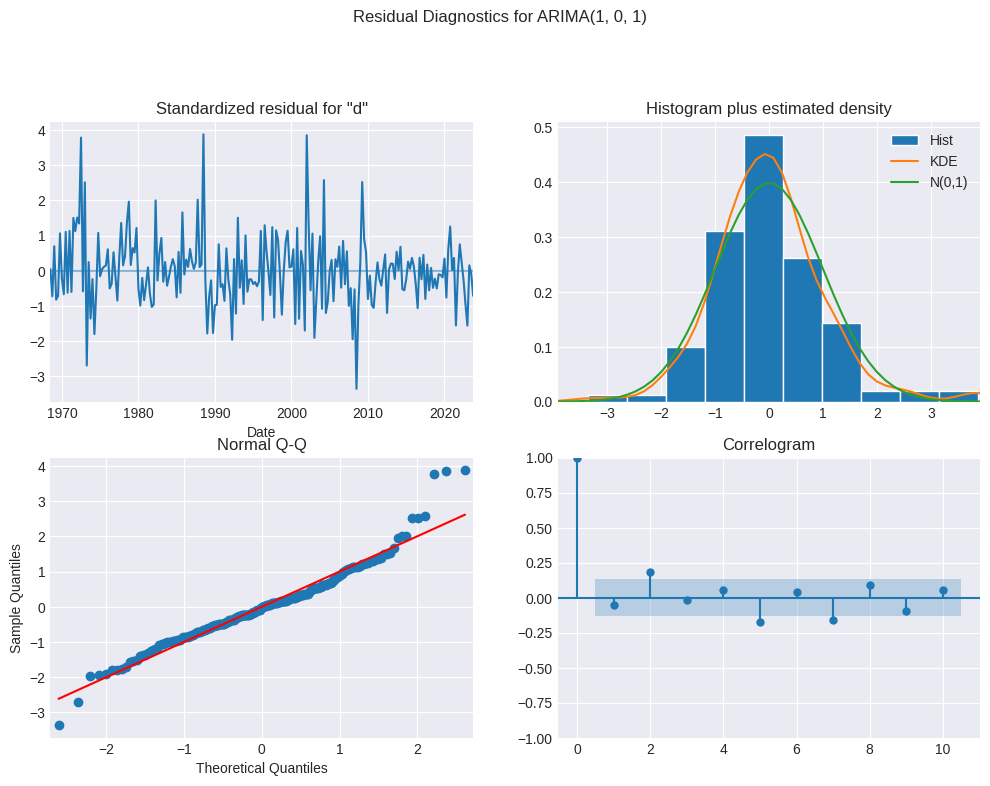


⏱  Completed in 44.8s


In [ ]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

def final_arima_pipeline(
    df,
    arima_order=(1,0,1),
    init_frac=0.80,
    fh=4
):
    """Expanding-window ARIMA + diagnostics + timing + progress bar."""
    start = time.perf_counter()
    n = len(df)
    init_n = max(int(n * init_frac), fh+1)

    preds = {h: [] for h in range(1, fh+1)}
    acts  = {h: [] for h in range(1, fh+1)}

    print(f"▶️  Fitting ARIMA{arima_order} over {n-init_n-fh+1} splits…")
    for i in tqdm(range(init_n, n - fh + 1), desc="ARIMA splits"):
        train = df.iloc[:i]
        test  = df.iloc[i:i+fh]

        m = ARIMA(train["dlogHPI_sa"], order=arima_order).fit()
        dlog_fc = m.forecast(steps=fh)
        last_log  = train["logHPI_sa"].iloc[-1]
        log_fc    = last_log + dlog_fc.cumsum()
        level_fc  = np.exp(log_fc)

        for h in range(1,fh+1):
            preds[h].append(level_fc.iloc[h-1])
            acts[h].append(test["HPI_All"].iloc[h-1])

        if i == n - fh:
            final_model = m

    # errors
    print("\n📊 Forecast errors by horizon:")
    overall_f, overall_a = [], []
    for h in range(1, fh+1):
        f = np.array(preds[h]); a = np.array(acts[h])
        mask = ~np.isnan(f)
        mae  = mean_absolute_error(a[mask], f[mask])
        rmse = np.sqrt(mean_squared_error(a[mask], f[mask]))
        print(f"  h={h:>2} → MAE={mae:.3f}, RMSE={rmse:.3f}")
        overall_f.extend(f[mask]); overall_a.extend(a[mask])

    om = mean_absolute_error(overall_a, overall_f)
    or_ = np.sqrt(mean_squared_error(overall_a, overall_f))
    print(f"  ↳ overall → MAE={om:.3f}, RMSE={or_:.3f}")

    print("\n📄 Final model summary:\n")
    print(final_model.summary())
    final_model.plot_diagnostics(figsize=(12,8))
    plt.suptitle(f"Residual Diagnostics for ARIMA{arima_order}", y=1.02)
    plt.show()

    print(f"\n⏱  Completed in {time.perf_counter() - start:.1f}s")

# run it
final_arima_pipeline(hpi_quarterly.dropna(subset=["logHPI_sa","dlogHPI_sa"]))

## Baged Arima


In [ ]:
# --- Define the list of B’s you want to try ---
B_values = [50, 100, 200]

# --- Storage for summary results ---
summary = []

for B in B_values:
    print(f"\n\n🔄 Running residual‐bagged ARIMA with B = {B} …")
    t0 = time.perf_counter()

    # call your existing pipeline; it should print its own per‐h MAE/RMSE
    # and show the final forecast/diagnostics
    final_arima_residual_bagged(
        hpi_quarterly.dropna(subset=["logHPI_sa","dlogHPI_sa"]),
        arima_order=(1,0,1),
        init_frac=0.80,
        fh=4,
        B=B
    )

    duration = time.perf_counter() - t0
    print(f"⏱  Total time for B={B}: {duration:.1f}s")

    # If your function returns (or you can easily expose) the overall MAE / RMSE,
    # you could capture them directly here.  For example, if it returned:
    #   mae, rmse = final_arima_residual_bagged(...)
    # then you could do:
    #   summary.append((B, mae, rmse, duration))
    #
    # For now, we’ll just record B and run‐time; you can manually note the final printed RMSE.

# --- After the loop, you’ll have printed a block for each B; then you can manually pick the B at which
#     the RMSE / MAE curve has essentially “flattened.”




🔄 Running residual‐bagged ARIMA with B = 50 …
▶️  Bagged-resid ARIMA(1, 0, 1) over 43 splits × 50 bootstraps…


Splits:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Bagged-resid forecast errors by horizon:
  h= 1 → MAE=1.417, RMSE=1.882
  h= 2 → MAE=2.556, RMSE=3.318
  h= 3 → MAE=3.602, RMSE=4.641
  h= 4 → MAE=4.529, RMSE=5.900
  ↳ overall → MAE=3.026, RMSE=4.210

⏱  Completed in 694.8s
⏱  Total time for B=50: 694.8s


🔄 Running residual‐bagged ARIMA with B = 100 …
▶️  Bagged-resid ARIMA(1, 0, 1) over 43 splits × 100 bootstraps…


Splits:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Bagged-resid forecast errors by horizon:
  h= 1 → MAE=1.404, RMSE=1.889
  h= 2 → MAE=2.575, RMSE=3.345
  h= 3 → MAE=3.656, RMSE=4.706
  h= 4 → MAE=4.562, RMSE=5.939
  ↳ overall → MAE=3.049, RMSE=4.248

⏱  Completed in 1459.3s
⏱  Total time for B=100: 1459.3s


🔄 Running residual‐bagged ARIMA with B = 200 …
▶️  Bagged-resid ARIMA(1, 0, 1) over 43 splits × 200 bootstraps…


Splits:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Bagged-resid forecast errors by horizon:
  h= 1 → MAE=1.431, RMSE=1.906
  h= 2 → MAE=2.580, RMSE=3.361
  h= 3 → MAE=3.670, RMSE=4.708
  h= 4 → MAE=4.587, RMSE=5.957
  ↳ overall → MAE=3.067, RMSE=4.260

⏱  Completed in 2819.7s
⏱  Total time for B=200: 2819.7s


 Summary of ARIMA Results
Basic ARIMA(1,0,1):
Horizon (h)	MAE	RMSE
1 quarter	1.177	1.583
2 quarters	2.137	2.920
3 quarters	3.258	4.307
4 quarters	4.219	5.408
Overall	2.698	3.835

Conclusion: Basic ARIMA showed reasonable forecasting accuracy, but errors increase significantly with forecast horizon.

Bagged Residual ARIMA(1,0,1):
B (bootstraps)	Overall MAE	Overall RMSE	Time (s)
50	3.026	4.210	695
100	3.049	4.248	1459
200	3.067	4.260	2820

Conclusion: Bagged ARIMA did not improve performance. Errors increased across all forecast horizons compared to basic ARIMA, and computation time significantly increased. This indicates that residual bagging did not provide beneficial variance reduction for this model/dataset.

## NNs


### adjusted try

In [ ]:
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

def prepare_mlp_data(
    df,
    target_col="dlogHPI_sa",
    n_lags=4,
    include_level=True,
    level_col="logHPI_sa"
):
    """
    Build lagged ΔlogHPI features + 1-step lagged logHPI level for MLP.
      X_t = [ΔlogHPI_{t-1}, …, ΔlogHPI_{t-n_lags}, logHPI_{t-1}]
      y_t = ΔlogHPI_t
    Returns X_scaled, y_scaled, scaler_X, scaler_y.
    """
    # 1) subset & dropna
    cols = [target_col] + ([level_col] if include_level else [])
    tmp = df[cols].dropna().copy()
    # 2) create lags of the Δlog series
    for lag in range(1, n_lags + 1):
        tmp[f"{target_col}_lag{lag}"] = tmp[target_col].shift(lag)
    # 3) optional lagged level
    if include_level:
        tmp[f"{level_col}_lag1"] = tmp[level_col].shift(1)
    tmp = tmp.dropna()

    # 4) split into X,y
    feature_cols = [f"{target_col}_lag{lag}" for lag in range(1, n_lags+1)]
    if include_level:
        feature_cols.append(f"{level_col}_lag1")
    X = tmp[feature_cols].copy()
    y = tmp[target_col].copy()

    # 5) scale features and target separately
    scaler_X = MinMaxScaler()
    scaler_y = StandardScaler()
    Xs = pd.DataFrame(
        scaler_X.fit_transform(X),
        index=X.index,
        columns=X.columns
    )
    ys = pd.Series(
        scaler_y.fit_transform(y.values.reshape(-1,1)).ravel(),
        index=y.index
    )
    return Xs, ys, scaler_X, scaler_y

def final_mlp_pipeline(
    df,
    n_lags=4,
    hidden_layer_sizes=(5,),
    alpha=1e-3,
    init_frac=0.8,
    fh=4,
    max_iter=2000
):
    """
    Expanding-window multi-step MLP:
      • Trains on scaled Δlog + lagged level
      • Uses early_stopping on the train split
      • Rolls forecasts forward in level space
      • Prints MAE/RMSE by horizon + overall
    """
    start = time.perf_counter()

    # Prepare once
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(
        df, n_lags=n_lags, include_level=True
    )
    log_ser   = df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    level_ser = df["HPI_All"].loc[Xs.index].reset_index(drop=True)
    Xs = Xs.reset_index(drop=True)
    ys = ys.reset_index(drop=True)

    n    = len(ys)
    init = max(int(n * init_frac), fh+1)
    splits = n - init - fh + 1

    # storage
    preds = {h: [] for h in range(1, fh+1)}
    acts  = {h: [] for h in range(1, fh+1)}

    print(f"▶️  Running MLP lags={n_lags}, hid={hidden_layer_sizes}, α={alpha} over {splits} splits…")
    for i in tqdm(range(init, n - fh + 1), desc="MLP splits"):
        X_train = Xs.iloc[:i]
        y_train = ys.iloc[:i]

        mlp = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=alpha,
            max_iter=max_iter,
            early_stopping=True,
            n_iter_no_change=50,
            tol=1e-4,
            random_state=0
        )
        mlp.fit(X_train, y_train)

        # multi-step rolling forecast in level space
        last_feats = Xs.iloc[i-1].values.copy()
        last_log   = log_ser.iloc[i-1]
        fc_levels  = []
        for h in range(fh):
            dlog_pred  = mlp.predict(last_feats.reshape(1,-1))[0]
            # un-scale
            dlog_real  = scaler_y.inverse_transform([[dlog_pred]])[0,0]
            log_pred   = last_log + dlog_real
            level_pred = np.exp(log_pred)
            fc_levels.append(level_pred)
            # shift window
            nxt_scaled = scaler_y.transform([[dlog_real]])[0,0]
            last_feats = np.roll(last_feats, -1)
            last_feats[-1] = nxt_scaled
            last_log = log_pred

        # collect
        for h, yhat in enumerate(fc_levels, start=1):
            preds[h].append(yhat)
            acts[h].append(level_ser.iloc[i-1+h])

    # print errors
    print("\n📊 MLP Forecast errors by horizon:")
    all_f, all_a = [], []
    for h in range(1, fh+1):
        f = np.array(preds[h]); a = np.array(acts[h])
        mask = ~np.isnan(f)
        mae  = mean_absolute_error(a[mask], f[mask])
        rmse = np.sqrt(mean_squared_error(a[mask], f[mask]))
        print(f"  h={h:>2} → MAE={mae:.3f}, RMSE={rmse:.3f}")
        all_f.extend(f[mask]); all_a.extend(a[mask])

    o_mae  = mean_absolute_error(all_a, all_f)
    o_rmse = np.sqrt(mean_squared_error(all_a, all_f))
    print(f"  ↳ overall → MAE={o_mae:.3f}, RMSE={o_rmse:.3f}")
    print(f"\n⏱ Completed in {time.perf_counter() - start:.1f}s")


In [ ]:
# Define the few MLP configs you want to try:
MLP_CONFIGS = [
    dict(n_lags=4, hidden_layer_sizes=(10,), alpha=1e-4),
    dict(n_lags=4, hidden_layer_sizes=(10,), alpha=1e-3),
    dict(n_lags=4, hidden_layer_sizes=(10,10), alpha=1e-4),
    dict(n_lags=8, hidden_layer_sizes=(20,), alpha=1e-4),
    # …add more as needed…
]

for cfg in MLP_CONFIGS:
    print("\n" + "-"*50)
    print(f"▶️ Config: lags={cfg['n_lags']}, hid={cfg['hidden_layer_sizes']}, α={cfg['alpha']}")
    final_mlp_pipeline(
        hpi_quarterly,
        n_lags=cfg["n_lags"],
        hidden_layer_sizes=cfg["hidden_layer_sizes"],
        alpha=cfg["alpha"],
        init_frac=0.8,
        fh=4,
        max_iter=2000
    )



--------------------------------------------------
▶️ Config: lags=4, hid=(10,), α=0.0001
▶️  Running MLP lags=4, hid=(10,), α=0.0001 over 42 splits…


MLP splits:   0%|          | 0/42 [00:00<?, ?it/s]


📊 MLP Forecast errors by horizon:
  h= 1 → MAE=1.367, RMSE=1.769
  h= 2 → MAE=3.928, RMSE=4.961
  h= 3 → MAE=4.155, RMSE=5.159
  h= 4 → MAE=10.420, RMSE=11.758
  ↳ overall → MAE=4.968, RMSE=6.939

⏱ Completed in 53.3s

--------------------------------------------------
▶️ Config: lags=4, hid=(10,), α=0.001
▶️  Running MLP lags=4, hid=(10,), α=0.001 over 42 splits…


MLP splits:   0%|          | 0/42 [00:00<?, ?it/s]


📊 MLP Forecast errors by horizon:
  h= 1 → MAE=1.366, RMSE=1.770
  h= 2 → MAE=3.906, RMSE=4.952
  h= 3 → MAE=4.138, RMSE=5.155
  h= 4 → MAE=10.618, RMSE=11.901
  ↳ overall → MAE=5.007, RMSE=6.998

⏱ Completed in 36.9s

--------------------------------------------------
▶️ Config: lags=4, hid=(10, 10), α=0.0001
▶️  Running MLP lags=4, hid=(10, 10), α=0.0001 over 42 splits…


MLP splits:   0%|          | 0/42 [00:00<?, ?it/s]


📊 MLP Forecast errors by horizon:
  h= 1 → MAE=1.270, RMSE=1.752
  h= 2 → MAE=3.136, RMSE=4.141
  h= 3 → MAE=4.630, RMSE=5.829
  h= 4 → MAE=6.503, RMSE=7.886
  ↳ overall → MAE=3.885, RMSE=5.394

⏱ Completed in 24.5s

--------------------------------------------------
▶️ Config: lags=8, hid=(20,), α=0.0001
▶️  Running MLP lags=8, hid=(20,), α=0.0001 over 41 splits…


MLP splits:   0%|          | 0/41 [00:00<?, ?it/s]


📊 MLP Forecast errors by horizon:
  h= 1 → MAE=1.284, RMSE=1.705
  h= 2 → MAE=2.708, RMSE=3.373
  h= 3 → MAE=3.810, RMSE=4.865
  h= 4 → MAE=5.828, RMSE=6.945
  ↳ overall → MAE=3.408, RMSE=4.642

⏱ Completed in 9.6s


### broad grid search

In [ ]:
```````

In [ ]:
space = {
    "n_lags":    hp.choice("n_lags",    [2, 4, 6, 8, 12]),
    "hidden":    hp.choice("hidden",    [(5,), (10,), (10,10), (20,10), (20,20), (10,10,10)]),
    "alpha":     hp.loguniform("alpha", np.log(1e-5), np.log(1e-2)),
}


In [ ]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# ... [objective and space as before] ...

trials = Trials()
rng    = np.random.default_rng(42)

best = fmin(
    fn        = objective,
    space     = space,
    algo      = tpe.suggest,
    max_evals = 60,
    trials    = trials,
    rstate    = rng      # <-- use a Generator, not RandomState
)

print("🏆 Best params:", best)


100%|██████████| 60/60 [22:51<00:00, 22.85s/trial, best loss: 3.9539473254312565]
🏆 Best params: {'alpha': np.float64(3.803595476384138e-05), 'hidden': np.int64(2), 'n_lags': np.int64(4)}


new try

In [ ]:
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# --- 1) Data‐prep helper (same as before) ---
def prepare_mlp_data(
    df,
    target_col="dlogHPI_sa",
    n_lags=4,
    include_level=True,
    level_col="logHPI_sa"
):
    cols = [target_col] + ([level_col] if include_level else [])
    tmp = df[cols].dropna().copy()
    for lag in range(1, n_lags + 1):
        tmp[f"{target_col}_lag{lag}"] = tmp[target_col].shift(lag)
    if include_level:
        tmp[f"{level_col}_lag1"] = tmp[level_col].shift(1)
    tmp = tmp.dropna()
    feat_cols = [f"{target_col}_lag{lag}" for lag in range(1, n_lags+1)]
    if include_level:
        feat_cols.append(f"{level_col}_lag1")
    X = tmp[feat_cols].copy()
    y = tmp[target_col].copy()
    scaler_X = MinMaxScaler()
    scaler_y = StandardScaler()
    Xs = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)
    ys = pd.Series(scaler_y.fit_transform(y.values.reshape(-1,1)).ravel(), index=y.index)
    return Xs, ys, scaler_X, scaler_y

# --- 2) Rolling‐window evaluator for a single (set of) hyperparams ---
def roll_mlp_eval(
    df,
    n_lags,
    hidden_layer_sizes,
    alpha,
    lr_init,
    activation,
    init_frac=0.8,
    fh=4,
    max_iter=2000
):
    # prepare once
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(df, n_lags=n_lags, include_level=True)
    log_ser   = df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    level_ser = df["HPI_All"].loc[Xs.index].reset_index(drop=True)
    Xs = Xs.reset_index(drop=True); ys = ys.reset_index(drop=True)
    n    = len(ys)
    init = max(int(n * init_frac), fh+1)
    preds, acts = [], []
    for i in range(init, n - fh + 1):
        X_train = Xs.iloc[:i]; y_train = ys.iloc[:i]
        mlp = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=alpha,
            learning_rate_init=lr_init,
            activation=activation,
            max_iter=max_iter,
            early_stopping=True,
            tol=1e-4,
            n_iter_no_change=50,
            random_state=0
        )
        mlp.fit(X_train, y_train)
        last_feats = Xs.iloc[i-1].values.copy()
        last_log   = log_ser.iloc[i-1]
        # multi‐step
        for h in range(fh):
            dlog_p   = mlp.predict(last_feats.reshape(1,-1))[0]
            dlog_p   = scaler_y.inverse_transform([[dlog_p]])[0,0]
            log_p    = last_log + dlog_p
            level_p  = np.exp(log_p)
            preds.append(level_p)
            acts.append(level_ser.iloc[i+h])
            last_feats = np.roll(last_feats, -1)
            last_feats[-1] = scaler_y.transform([[dlog_p]])[0,0]
            last_log = log_p
    # return RMSE
    return np.sqrt(mean_squared_error(acts, preds))

# --- 3) Hyperopt search space & objective ---
space = {
    'n_lags':     hp.choice('n_lags',     [4, 6, 8]),
    'hidden':     hp.choice('hidden',     [(10,), (20,), (20,10), (30,15)]),
    'alpha':      hp.loguniform('alpha',  np.log(1e-6), np.log(1e-1)),
    'lr_init':    hp.loguniform('lr_init', np.log(1e-4), np.log(1e-1)),
    'activation': hp.choice('activation',['relu','tanh']),
}

def objective(params):
    rmse = roll_mlp_eval(
        df                 = hpi_quarterly,
        n_lags             = int(params['n_lags']),
        hidden_layer_sizes = tuple(params['hidden']),
        alpha              = float(params['alpha']),
        lr_init            = float(params['lr_init']),
        activation         = params['activation'],
        init_frac          = 0.8,
        fh                 = 4,
        max_iter           = 2000
    )
    return {'loss': rmse, 'status': STATUS_OK}

# --- 4) Run the search ---
trials = Trials()
rng    = np.random.default_rng(42)

best = fmin(
    fn        = objective,
    space     = space,
    algo      = tpe.suggest,
    max_evals = 120,
    trials    = trials,
    rstate    = rng
)

print("🏆 Best params:", best)


100%|██████████| 120/120 [1:14:24<00:00, 37.21s/trial, best loss: 3.591528335546519]
🏆 Best params: {'activation': np.int64(0), 'alpha': np.float64(9.150775570161672e-05), 'hidden': np.int64(2), 'lr_init': np.float64(0.00014079821526811928), 'n_lags': np.int64(0)}


### Basic MLP pipeline

In [ ]:
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) data-prep helper (unchanged)
def prepare_mlp_data(
    df,
    target_col="dlogHPI_sa",
    n_lags=4,
    include_level=True,
    level_col="logHPI_sa"
):
    cols = [target_col] + ([level_col] if include_level else [])
    tmp = df[cols].dropna().copy()
    for lag in range(1, n_lags + 1):
        tmp[f"{target_col}_lag{lag}"] = tmp[target_col].shift(lag)
    if include_level:
        tmp[f"{level_col}_lag1"] = tmp[level_col].shift(1)
    tmp = tmp.dropna()
    feat_cols = [f"{target_col}_lag{lag}" for lag in range(1, n_lags+1)]
    if include_level:
        feat_cols.append(f"{level_col}_lag1")
    X = tmp[feat_cols].copy()
    y = tmp[target_col].copy()
    scaler_X = MinMaxScaler()
    scaler_y = StandardScaler()
    Xs = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)
    ys = pd.Series(scaler_y.fit_transform(y.values.reshape(-1,1)).ravel(), index=y.index)
    return Xs, ys, scaler_X, scaler_y

# 2) final pipeline that RETURNS per-h MAE/RMSE
def final_mlp_metrics(
    df,
    n_lags,
    hidden_layer_sizes,
    alpha,
    lr_init,
    activation,
    init_frac=0.8,
    fh=4,
    max_iter=2000
):
    """
    Returns a DataFrame with index=horizon and columns [MAE, RMSE].
    """
    # prepare once
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(df, n_lags=n_lags, include_level=True)
    log_ser   = df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    level_ser = df["HPI_All"].loc[Xs.index].reset_index(drop=True)
    Xs = Xs.reset_index(drop=True); ys = ys.reset_index(drop=True)
    n    = len(ys)
    init = max(int(n * init_frac), fh+1)

    preds = {h: [] for h in range(1, fh+1)}
    acts  = {h: [] for h in range(1, fh+1)}

    for i in tqdm(range(init, n - fh + 1), desc="MLP splits"):
        X_train, y_train = Xs.iloc[:i], ys.iloc[:i]
        mlp = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=alpha,
            learning_rate_init=lr_init,
            activation=activation,
            max_iter=max_iter,
            early_stopping=True,
            tol=1e-4,
            n_iter_no_change=50,
            random_state=0
        )
        mlp.fit(X_train, y_train)

        last_feats = Xs.iloc[i-1].values.copy()
        last_log   = log_ser.iloc[i-1]
        for h in range(1, fh+1):
            # 1-step ahead on diffs
            dlog_p   = mlp.predict(last_feats.reshape(1,-1))[0]
            dlog_p   = scaler_y.inverse_transform([[dlog_p]])[0,0]
            log_p    = last_log + dlog_p
            level_p  = np.exp(log_p)
            preds[h].append(level_p)
            acts[h].append(level_ser.iloc[i-1+h])

            # advance last_feats / last_log
            last_feats = np.roll(last_feats, -1)
            last_feats[-1] = scaler_y.transform([[dlog_p]])[0,0]
            last_log = log_p

    # compute metrics
    rows = []
    for h in range(1, fh+1):
        f = np.array(preds[h]); a = np.array(acts[h])
        m = ~np.isnan(f)
        mae  = mean_absolute_error(a[m], f[m])
        rmse = np.sqrt(mean_squared_error(a[m], f[m]))
        rows.append((h, mae, rmse))

    return pd.DataFrame(rows, columns=["h","MAE","RMSE"]).set_index("h")

# 3) your best‐found hyperparams
best_params = {
    "n_lags": 4,
    "hidden_layer_sizes": (20,10),
    "alpha": 9.150775570161672e-05,
    "lr_init": 1.4079821526811928e-04,
    "activation": "relu"
}

# 4) run it
mlp_errors = final_mlp_metrics(
    hpi_quarterly,
    **best_params,
    init_frac=0.8,
    fh=4,
    max_iter=2000
)

# 5) construct ARIMA errors (from your earlier run)
arima_dict = {
    1: (1.177, 1.583),
    2: (2.137, 2.920),
    3: (3.258, 4.307),
    4: (4.219, 5.408)
}
arima_errors = pd.DataFrame.from_dict(arima_dict, orient="index", columns=["MAE","RMSE"])
arima_errors.index.name = "h"

# 6) side-by-side comparison
compare = arima_errors.join(mlp_errors, rsuffix="_MLP")
print(compare)


MLP splits:   0%|          | 0/42 [00:00<?, ?it/s]

     MAE   RMSE   MAE_MLP  RMSE_MLP
h                                  
1  1.177  1.583  1.332688  1.777957
2  2.137  2.920  2.346469  2.992501
3  3.258  4.307  3.174277  3.998589
4  4.219  5.408  3.776705  4.846792


### Bagged NN MLP pipeline

In [ ]:
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Re-use your data-prep helper:
def prepare_mlp_data(df, target_col="dlogHPI_sa", n_lags=4, include_level=True, level_col="logHPI_sa"):
    cols = [target_col] + ([level_col] if include_level else [])
    tmp = df[cols].dropna().copy()
    for lag in range(1, n_lags+1):
        tmp[f"{target_col}_lag{lag}"] = tmp[target_col].shift(lag)
    if include_level:
        tmp[f"{level_col}_lag1"] = tmp[level_col].shift(1)
    tmp.dropna(inplace=True)
    feat_cols = [f"{target_col}_lag{lag}" for lag in range(1, n_lags+1)]
    if include_level: feat_cols.append(f"{level_col}_lag1")
    X = tmp[feat_cols].copy()
    y = tmp[target_col].copy()
    # scale X to [0,1], y to mean-0 std-1
    scaler_X = MinMaxScaler()
    scaler_y = StandardScaler()
    Xs = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)
    ys = pd.Series(scaler_y.fit_transform(y.values.reshape(-1,1)).ravel(), index=y.index)
    return Xs, ys, scaler_X, scaler_y

# 2) Single-MLP pipeline (reuse your best hyperparams):
def final_mlp_pipeline(df, n_lags, hidden, alpha, lr_init, activation, init_frac=0.8, fh=4, max_iter=2000):
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(df, n_lags=n_lags, include_level=True)
    log_s = df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    lvl_s = df["HPI_All"].loc[Xs.index].reset_index(drop=True)
    Xs, ys = Xs.reset_index(drop=True), ys.reset_index(drop=True)
    n = len(ys)
    init = max(int(n*init_frac), fh+1)
    preds, acts = {h:[] for h in range(1,fh+1)}, {h:[] for h in range(1,fh+1)}

    for i in tqdm(range(init, n-fh+1), desc="MLP splits"):
        Xtr, ytr = Xs.iloc[:i], ys.iloc[:i]
        mlp = MLPRegressor(
            hidden_layer_sizes=hidden,
            alpha=alpha,
            learning_rate_init=lr_init,
            activation=activation,
            max_iter=max_iter,
            early_stopping=True,
            tol=1e-4,
            n_iter_no_change=50,
            random_state=0
        )
        mlp.fit(Xtr, ytr)

        feats = Xs.iloc[i-1].values.copy()
        last_log = log_s.iloc[i-1]
        for h in range(1,fh+1):
            dlog_p = mlp.predict(feats.reshape(1,-1))[0]
            dlog_p = scaler_y.inverse_transform([[dlog_p]])[0,0]
            log_p  = last_log + dlog_p
            lvl_p  = np.exp(log_p)
            preds[h].append(lvl_p)
            acts[h].append(lvl_s.iloc[i-1+h])
            # advance
            feats = np.roll(feats, -1)
            feats[-1] = scaler_y.transform([[dlog_p]])[0,0]
            last_log = log_p

    # aggregate errors
    res = {}
    for h in range(1,fh+1):
        f,a = np.array(preds[h]), np.array(acts[h])
        m   = ~np.isnan(f)
        res[(h,"MAE")]  = mean_absolute_error(a[m],f[m])
        res[(h,"RMSE")] = np.sqrt(mean_squared_error(a[m],f[m]))
    return res

# 3) Bagged-MLP pipeline:
def final_bagged_mlp(df, n_lags, hidden, alpha, lr_init, activation, B=50, init_frac=0.8, fh=4, max_iter=2000):
    np.random.seed(0)
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(df, n_lags=n_lags, include_level=True)
    log_s = df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    lvl_s = df["HPI_All"].loc[Xs.index].reset_index(drop=True)
    Xs, ys = Xs.reset_index(drop=True), ys.reset_index(drop=True)
    n = len(ys)
    init = max(int(n*init_frac), fh+1)

    # storage per horizon
    preds, acts = {h:[] for h in range(1,fh+1)}, {h:[] for h in range(1,fh+1)}

    for i in tqdm(range(init, n-fh+1), desc=f"Bagged MLP B={B} splits"):
        # bootstrap & forecast B times
        fc_b = {h:[] for h in range(1,fh+1)}
        for b in range(B):
            idx = np.random.randint(0, i, i)  # sample with replacement
            Xtr, ytr = Xs.iloc[idx], ys.iloc[idx]
            mlp = MLPRegressor(
                hidden_layer_sizes=hidden,
                alpha=alpha,
                learning_rate_init=lr_init,
                activation=activation,
                max_iter=max_iter,
                early_stopping=False,
                tol=1e-4,
                random_state=b  # different seed
            )
            mlp.fit(Xtr, ytr)

            feats = Xs.iloc[i-1].values.copy()
            last_log = log_s.iloc[i-1]
            for h in range(1,fh+1):
                dlog_p = mlp.predict(feats.reshape(1,-1))[0]
                dlog_p = scaler_y.inverse_transform([[dlog_p]])[0,0]
                log_p  = last_log + dlog_p
                lvl_p  = np.exp(log_p)
                fc_b[h].append(lvl_p)
                # advance
                feats = np.roll(feats, -1)
                feats[-1] = scaler_y.transform([[dlog_p]])[0,0]
                last_log = log_p

        # average over B
        for h in range(1,fh+1):
            preds[h].append(np.mean(fc_b[h]))
            acts[h].append(lvl_s.iloc[i-1+h])

    # compute errors
    res = {}
    for h in range(1,fh+1):
        f,a = np.array(preds[h]), np.array(acts[h])
        m   = ~np.isnan(f)
        res[(h,"MAE")]  = mean_absolute_error(a[m],f[m])
        res[(h,"RMSE")] = np.sqrt(mean_squared_error(a[m],f[m]))
    return res

# 4) Run & collect:
#   – ARIMA baseline (you already have these)
arima = {1:(1.177,1.583), 2:(2.137,2.920), 3:(3.258,4.307), 4:(4.219,5.408)}
#   – tuned single MLP (fill from your final_mlp_pipeline output)
mlp   = final_mlp_pipeline(
    hpi_quarterly,
    n_lags=4,
    hidden=(20,10),
    alpha=9.1507755e-05,
    lr_init=1.407982e-04,
    activation='relu',
    init_frac=0.8,
    fh=4,
    max_iter=2000
)

# bagged variants:
bagged = {}
for B in [50,100,200]:
    bagged[B] = final_bagged_mlp(
        hpi_quarterly,
        n_lags=4,
        hidden=(20,10),
        alpha=9.1507755e-05,
        lr_init=1.407982e-04,
        activation='relu',
        B=B,
        init_frac=0.8,
        fh=4,
        max_iter=2000
    )

# 5) Compare in one table:
horizon = [1,2,3,4]
rows = []
for h in horizon:
    rows.append({
        'h': h,
        'ARIMA_MAE':  arima[h][0],
        'ARIMA_RMSE': arima[h][1],
        'MLP_MAE':    mlp[(h,'MAE')],
        'MLP_RMSE':   mlp[(h,'RMSE')],
        **{f'Bag{B}_MAE':  bagged[B][(h,'MAE')]  for B in bagged},
        **{f'Bag{B}_RMSE': bagged[B][(h,'RMSE')] for B in bagged},
    })
df = pd.DataFrame(rows).set_index('h')
print(df)


MLP splits:   0%|          | 0/42 [00:00<?, ?it/s]

Bagged MLP B=50 splits:   0%|          | 0/42 [00:00<?, ?it/s]

Bagged MLP B=100 splits:   0%|          | 0/42 [00:00<?, ?it/s]

Bagged MLP B=200 splits:   0%|          | 0/42 [00:00<?, ?it/s]

   ARIMA_MAE  ARIMA_RMSE   MLP_MAE  MLP_RMSE  Bag50_MAE  Bag100_MAE  \
h                                                                     
1      1.177       1.583  1.332580  1.777816   1.326239    1.327096   
2      2.137       2.920  2.346527  2.992549   3.342007    3.407381   
3      3.258       4.307  3.174504  3.998772   4.539994    4.661661   
4      4.219       5.408  3.777130  4.847330   6.829669    7.152526   

   Bag200_MAE  Bag50_RMSE  Bag100_RMSE  Bag200_RMSE  
h                                                    
1    1.332231    1.722206     1.721145     1.715621  
2    3.422715    4.204478     4.273761     4.298625  
3    4.727202    5.621727     5.735821     5.794091  
4    7.262234    8.133728     8.452264     8.533524  


## RF

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) data-prep helper
def prepare_mlp_data(df, target_col="dlogHPI_sa", n_lags=4, include_level=True, level_col="logHPI_sa"):
    cols = [target_col] + ([level_col] if include_level else [])
    tmp = df[cols].dropna().copy()
    for lag in range(1, n_lags+1):
        tmp[f"{target_col}_lag{lag}"] = tmp[target_col].shift(lag)
    if include_level:
        tmp[f"{level_col}_lag1"] = tmp[level_col].shift(1)
    tmp.dropna(inplace=True)

    feat_cols = [f"{target_col}_lag{lag}" for lag in range(1, n_lags+1)]
    if include_level:
        feat_cols.append(f"{level_col}_lag1")

    X = tmp[feat_cols].copy()
    y = tmp[target_col].copy()

    scaler_X = MinMaxScaler()
    scaler_y = StandardScaler()
    Xs = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)
    ys = pd.Series(  scaler_y.fit_transform(y.values.reshape(-1,1)).ravel(),
                     index=y.index)

    return Xs, ys, scaler_X, scaler_y

# 2) basic RF rolling-window multi-step pipeline
def final_rf_pipeline(df, n_lags=4, rf_params=None, init_frac=0.8, fh=4):
    rf_params = rf_params or {'n_estimators':100, 'max_depth':5, 'random_state':0}

    # prepare
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(df, n_lags=n_lags, include_level=True)
    log_s = df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    lvl_s = df["HPI_All"]  .loc[Xs.index].reset_index(drop=True)
    Xs, ys = Xs.reset_index(drop=True), ys.reset_index(drop=True)
    n = len(ys)
    init = max(int(n * init_frac), fh+1)

    print(f"▶️  Running RF lags={n_lags}, params={rf_params} over {n-init-fh+1} splits…")

    preds, acts = {h:[] for h in range(1,fh+1)}, {h:[] for h in range(1,fh+1)}

    for i in tqdm(range(init, n-fh+1), desc="RF splits"):
        # train on [0:i)
        Xtr, ytr = Xs.iloc[:i], ys.iloc[:i]
        rf = RandomForestRegressor(**rf_params)
        rf.fit(Xtr, ytr)

        # multi-step forecast
        feats    = Xs.iloc[i-1].values.copy()
        last_log = log_s.iloc[i-1]

        for h in range(1, fh+1):
            # wrap feats back into a DataFrame with the same columns
            feat_df = pd.DataFrame(feats.reshape(1,-1),
                                   columns=Xtr.columns,
                                   index=[0])
            out    = rf.predict(feat_df)[0]
            dlog_p = scaler_y.inverse_transform([[out]])[0,0]
            log_p  = last_log + dlog_p
            lvl_p  = np.exp(log_p)

            preds[h].append(lvl_p)
            acts[h].append(lvl_s.iloc[i-1+h])

            # roll-forward the features
            feats = np.roll(feats, -1)
            feats[-1] = scaler_y.transform([[dlog_p]])[0,0]
            last_log  = log_p

    # compute MAE/RMSE
    res = {}
    for h in range(1,fh+1):
        f, a = np.array(preds[h]), np.array(acts[h])
        mask  = ~np.isnan(f)
        res[(h,"MAE")]  = mean_absolute_error(a[mask], f[mask])
        res[(h,"RMSE")] = np.sqrt(mean_squared_error(a[mask], f[mask]))
    return res

# 3) run it and compare to your ARIMA + MLP baselines
# — your ARIMA baseline
arima = {
    1:(1.177, 1.583),
    2:(2.137, 2.920),
    3:(3.258, 4.307),
    4:(4.219, 5.408),
}

# — your tuned MLP baseline
mlp_base = {
    1:(1.332580, 1.777816),
    2:(2.346527, 2.992549),
    3:(3.174504, 3.998772),
    4:(3.777130, 4.847330),
}

# — choose RF hyperparams
rf_params = {
    'n_estimators':200,
    'max_depth':     8,
    'max_features':'sqrt',
    'random_state':  0
}




In [ ]:
# — run the RF pipeline
rf_res = final_rf_pipeline(hpi_quarterly,
                           n_lags=4,
                           rf_params=rf_params,
                           init_frac=0.8,
                           fh=4)

# 4) print out the results side-by-side
rows = []
for h in [1,2,3,4]:
    rows.append({
        'h':            h,
        'ARIMA_MAE':    arima[h][0],
        'ARIMA_RMSE':   arima[h][1],
        'MLP_MAE':      mlp_base[h][0],
        'MLP_RMSE':     mlp_base[h][1],
        'RF_MAE':       rf_res[(h,'MAE')],
        'RF_RMSE':      rf_res[(h,'RMSE')],
    })

df = pd.DataFrame(rows).set_index('h')
print(df)

# 5) quick takeaway
print("\n— Takeaway:")
for h in [1,2,3,4]:
    print(f"H={h}: RF   {df.loc[h,'RF_MAE']:.3f}/{df.loc[h,'RF_RMSE']:.3f}",
          f" vs ARIMA {df.loc[h,'ARIMA_MAE']:.3f}/{df.loc[h,'ARIMA_RMSE']:.3f}",
          f" vs MLP   {df.loc[h,'MLP_MAE']:.3f}/{df.loc[h,'MLP_RMSE']:.3f}")

▶️  Running RF lags=4, params={'n_estimators': 200, 'max_depth': 8, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]

   ARIMA_MAE  ARIMA_RMSE   MLP_MAE  MLP_RMSE    RF_MAE   RF_RMSE
h                                                               
1      1.177       1.583  1.332580  1.777816  1.204875  1.629262
2      2.137       2.920  2.346527  2.992549  2.181976  2.785157
3      3.258       4.307  3.174504  3.998772  3.459303  4.557924
4      4.219       5.408  3.777130  4.847330  5.895618  7.246653

— Takeaway:
H=1: RF   1.205/1.629  vs ARIMA 1.177/1.583  vs MLP   1.333/1.778
H=2: RF   2.182/2.785  vs ARIMA 2.137/2.920  vs MLP   2.347/2.993
H=3: RF   3.459/4.558  vs ARIMA 3.258/4.307  vs MLP   3.175/3.999
H=4: RF   5.896/7.247  vs ARIMA 4.219/5.408  vs MLP   3.777/4.847


In [ ]:
# — choose RF hyperparams
rf_params = {
    'n_estimators':100,
    'max_depth':     8,
    'max_features':'sqrt',
    'random_state':  0
}

# — run the RF pipeline
rf_res = final_rf_pipeline(hpi_quarterly,
                           n_lags=4,
                           rf_params=rf_params,
                           init_frac=0.8,
                           fh=4)

# 4) print out the results side-by-side
rows = []
for h in [1,2,3,4]:
    rows.append({
        'h':            h,
        'ARIMA_MAE':    arima[h][0],
        'ARIMA_RMSE':   arima[h][1],
        'MLP_MAE':      mlp_base[h][0],
        'MLP_RMSE':     mlp_base[h][1],
        'RF_MAE':       rf_res[(h,'MAE')],
        'RF_RMSE':      rf_res[(h,'RMSE')],
    })

df = pd.DataFrame(rows).set_index('h')
print(df)

# 5) quick takeaway
print("\n— Takeaway:")
for h in [1,2,3,4]:
    print(f"H={h}: RF   {df.loc[h,'RF_MAE']:.3f}/{df.loc[h,'RF_RMSE']:.3f}",
          f" vs ARIMA {df.loc[h,'ARIMA_MAE']:.3f}/{df.loc[h,'ARIMA_RMSE']:.3f}",
          f" vs MLP   {df.loc[h,'MLP_MAE']:.3f}/{df.loc[h,'MLP_RMSE']:.3f}")

▶️  Running RF lags=4, params={'n_estimators': 100, 'max_depth': 8, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]

   ARIMA_MAE  ARIMA_RMSE   MLP_MAE  MLP_RMSE    RF_MAE   RF_RMSE
h                                                               
1      1.177       1.583  1.332580  1.777816  1.199681  1.632589
2      2.137       2.920  2.346527  2.992549  2.165806  2.776453
3      3.258       4.307  3.174504  3.998772  3.511731  4.635318
4      4.219       5.408  3.777130  4.847330  6.039298  7.428694

— Takeaway:
H=1: RF   1.200/1.633  vs ARIMA 1.177/1.583  vs MLP   1.333/1.778
H=2: RF   2.166/2.776  vs ARIMA 2.137/2.920  vs MLP   2.347/2.993
H=3: RF   3.512/4.635  vs ARIMA 3.258/4.307  vs MLP   3.175/3.999
H=4: RF   6.039/7.429  vs ARIMA 4.219/5.408  vs MLP   3.777/4.847


### Improving basic RF

In [ ]:
import itertools
import pandas as pd

# 1) Define your grid (drop "auto", use None)
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth":    [5, 8, None],
    "max_features": ["sqrt", None],    # → instead of "auto"
}

# 2) Build all combinations
grid = list(itertools.product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["max_features"],
))

# 3) Sweep
results = []
for n_est, depth, mf in grid:
    rf_params = {
        "n_estimators": n_est,
        "max_depth":    depth,
        "max_features": mf,
        "random_state": 0,
    }
    print(f"\n=== Testing RF params: {rf_params} ===")
    rf_res = final_rf_pipeline(
        hpi_quarterly,
        n_lags=4,
        rf_params=rf_params,
        init_frac=0.8,
        fh=4
    )

    # record per‐h MAE/RMSE + totals
    row = {"n_estimators":n_est, "max_depth":depth, "max_features":mf}
    total_mae = total_rmse = 0.0
    for h in [1,2,3,4]:
        mae, rmse = rf_res[(h,"MAE")], rf_res[(h,"RMSE")]
        row[f"h{h}_MAE"]  = mae
        row[f"h{h}_RMSE"] = rmse
        total_mae  += mae
        total_rmse += rmse

    row["total_MAE"]  = total_mae
    row["total_RMSE"] = total_rmse
    results.append(row)

# 4) Assemble + sort by total MAE
df_grid = pd.DataFrame(results)
df_grid = df_grid.sort_values("total_MAE").reset_index(drop=True)

print("\n=== RF grid search sorted by TOTAL MAE ===")
print(df_grid)

# 5) Show top 5
print("\nTop 5 configurations by total MAE:")
print(df_grid.head(5))



=== Testing RF params: {'n_estimators': 100, 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 100, 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 100, 'max_depth': 5, 'max_features': None, 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 100, 'max_depth': 5, 'max_features': None, 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 100, 'max_depth': 8, 'max_features': 'sqrt', 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 100, 'max_depth': 8, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 100, 'max_depth': 8, 'max_features': None, 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 100, 'max_depth': 8, 'max_features': None, 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt', 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 100, 'max_depth': None, 'max_features': None, 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 100, 'max_depth': None, 'max_features': None, 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 200, 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 200, 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 200, 'max_depth': 5, 'max_features': None, 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 200, 'max_depth': 5, 'max_features': None, 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 200, 'max_depth': 8, 'max_features': 'sqrt', 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 200, 'max_depth': 8, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 200, 'max_depth': 8, 'max_features': None, 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 200, 'max_depth': 8, 'max_features': None, 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 200, 'max_depth': None, 'max_features': 'sqrt', 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 200, 'max_depth': None, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 200, 'max_depth': None, 'max_features': None, 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 200, 'max_depth': None, 'max_features': None, 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 500, 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 500, 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 500, 'max_depth': 5, 'max_features': None, 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 500, 'max_depth': 8, 'max_features': 'sqrt', 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 500, 'max_depth': 8, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 500, 'max_depth': 8, 'max_features': None, 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 500, 'max_depth': 8, 'max_features': None, 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 500, 'max_depth': None, 'max_features': 'sqrt', 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 500, 'max_depth': None, 'max_features': 'sqrt', 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== Testing RF params: {'n_estimators': 500, 'max_depth': None, 'max_features': None, 'random_state': 0} ===
▶️  Running RF lags=4, params={'n_estimators': 500, 'max_depth': None, 'max_features': None, 'random_state': 0} over 42 splits…


RF splits:   0%|          | 0/42 [00:00<?, ?it/s]


=== RF grid search sorted by TOTAL MAE ===
    n_estimators  max_depth max_features    h1_MAE   h1_RMSE    h2_MAE  \
0            100        8.0         None  1.215835  1.611329  2.130670   
1            500        8.0         None  1.210494  1.618902  2.164877   
2            500        NaN         None  1.220144  1.575386  2.154294   
3            100        NaN         None  1.232946  1.578059  2.163132   
4            200        8.0         None  1.216211  1.624275  2.180125   
5            200        NaN         None  1.232273  1.583179  2.182801   
6            500        5.0         None  1.238353  1.724648  2.253093   
7            100        5.0         None  1.220128  1.715006  2.224917   
8            200        5.0         None  1.248484  1.729218  2.257711   
9            500        NaN         sqrt  1.215266  1.578084  2.127972   
10           200        NaN         sqrt  1.238458  1.613208  2.187380   
11           500        8.0         sqrt  1.191569  1.610652  2.1634

In [ ]:
# after you build `df_grid`…
df_grid["avg_MAE"]  = df_grid["total_MAE"]  / 4
df_grid["avg_RMSE"] = df_grid["total_RMSE"] / 4

# re‐sort by average MAE:
df_grid = df_grid.sort_values("avg_MAE").reset_index(drop=True)

print("=== RF grid search sorted by AVG MAE ===")
print(df_grid)

# show the top 5
print("\nTop 5 by average MAE:")
print(df_grid.head(5))


=== RF grid search sorted by AVG MAE ===
    n_estimators  max_depth max_features    h1_MAE   h1_RMSE    h2_MAE  \
0            100        8.0         None  1.215835  1.611329  2.130670   
1            500        8.0         None  1.210494  1.618902  2.164877   
2            500        NaN         None  1.220144  1.575386  2.154294   
3            100        NaN         None  1.232946  1.578059  2.163132   
4            200        8.0         None  1.216211  1.624275  2.180125   
5            200        NaN         None  1.232273  1.583179  2.182801   
6            500        5.0         None  1.238353  1.724648  2.253093   
7            100        5.0         None  1.220128  1.715006  2.224917   
8            200        5.0         None  1.248484  1.729218  2.257711   
9            500        NaN         sqrt  1.215266  1.578084  2.127972   
10           200        NaN         sqrt  1.238458  1.613208  2.187380   
11           500        8.0         sqrt  1.191569  1.610652  2.163424 

## Bagged RF

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def prepare_mlp_data(df, target_col="dlogHPI_sa", n_lags=4, include_level=True, level_col="logHPI_sa"):
    cols = [target_col] + ([level_col] if include_level else [])
    tmp = df[cols].dropna().copy()
    for lag in range(1, n_lags+1):
        tmp[f"{target_col}_lag{lag}"] = tmp[target_col].shift(lag)
    if include_level:
        tmp[f"{level_col}_lag1"] = tmp[level_col].shift(1)
    tmp.dropna(inplace=True)

    feat_cols = [f"{target_col}_lag{lag}" for lag in range(1, n_lags+1)]
    if include_level:
        feat_cols.append(f"{level_col}_lag1")

    X = tmp[feat_cols]
    y = tmp[target_col]

    scaler_X = MinMaxScaler()
    scaler_y = StandardScaler()
    Xs = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)
    ys = pd.Series(scaler_y.fit_transform(y.values.reshape(-1,1)).ravel(), index=y.index)

    return Xs, ys, scaler_X, scaler_y

def final_bagged_rf(df, n_lags=4, rf_params=None, B=50, init_frac=0.8, fh=4):
    # pull out any global random_state from rf_params so we can override per-bootstrap
    params = (rf_params or {}).copy()
    global_rs = params.pop("random_state", None)

    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(df, n_lags=n_lags, include_level=True)
    log_s = df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    lvl_s = df["HPI_All"]  .loc[Xs.index].reset_index(drop=True)
    Xs, ys = Xs.reset_index(drop=True), ys.reset_index(drop=True)

    n = len(ys)
    init = max(int(n * init_frac), fh+1)

    print(f"▶️  Running bagged-RF B={B}, params={params} over {n-init-fh+1} splits…")
    preds, acts = {h:[] for h in range(1,fh+1)}, {h:[] for h in range(1,fh+1)}

    for i in tqdm(range(init, n-fh+1), desc=f"Bagged-RF B={B} splits"):
        fc_b = {h:[] for h in range(1,fh+1)}

        for b in range(B):
            idx = np.random.randint(0, i, i)
            Xtr, ytr = Xs.iloc[idx], ys.iloc[idx]
            rf = RandomForestRegressor(**params, random_state=b if global_rs is None else global_rs)
            rf.fit(Xtr, ytr)

            feats    = Xs.iloc[i-1].values.copy()
            last_log = log_s.iloc[i-1]

            for h in range(1, fh+1):
                # wrap in DataFrame to keep feature names
                feat_df = pd.DataFrame(feats.reshape(1,-1),
                                       columns=Xtr.columns,
                                       index=[0])
                out    = rf.predict(feat_df)[0]
                dlog_p = scaler_y.inverse_transform([[out]])[0,0]
                log_p  = last_log + dlog_p
                lvl_p  = np.exp(log_p)
                fc_b[h].append(lvl_p)

                feats = np.roll(feats, -1)
                feats[-1] = scaler_y.transform([[dlog_p]])[0,0]
                last_log  = log_p

        for h in range(1, fh+1):
            preds[h].append(np.mean(fc_b[h]))
            acts[h].append(lvl_s.iloc[i-1+h])

    res = {}
    for h in range(1,fh+1):
        f, a = np.array(preds[h]), np.array(acts[h])
        m    = ~np.isnan(f)
        res[(h,"MAE")]  = mean_absolute_error(a[m], f[m])
        res[(h,"RMSE")] = np.sqrt(mean_squared_error(a[m], f[m]))
    return res




In [ ]:
# === Example of calling it ===

rf_params = {'n_estimators':200, 'max_depth':8, 'max_features':'sqrt'}  # no random_state here
bagged_rf_50  = final_bagged_rf(hpi_quarterly, n_lags=4, rf_params=rf_params, B=50,  init_frac=0.8, fh=4)
bagged_rf_100 = final_bagged_rf(hpi_quarterly, n_lags=4, rf_params=rf_params, B=100, init_frac=0.8, fh=4)

In [ ]:
rf_params = {'n_estimators':200, 'max_depth':8, 'max_features':'sqrt'}  # no random_state here
bagged_rf_200 = final_bagged_rf(hpi_quarterly, n_lags=4, rf_params=rf_params, B=200, init_frac=0.8, fh=4)

▶️  Running bagged-RF B=200, params={'n_estimators': 200, 'max_depth': 8, 'max_features': 'sqrt'} over 42 splits…


Bagged-RF B=200 splits:   0%|          | 0/42 [00:00<?, ?it/s]

Baged RF results for rf_params = {'n_estimators':200, 'max_depth':8, 'max_features':'sqrt'}  # no random_state here

In [ ]:
bagged_rf_50

{(1, 'MAE'): 1.1802539567406671,
 (1, 'RMSE'): np.float64(1.637387600341615),
 (2, 'MAE'): 2.199383569544225,
 (2, 'RMSE'): np.float64(2.8619246561424823),
 (3, 'MAE'): 3.5481627405345684,
 (3, 'RMSE'): np.float64(4.585918149450314),
 (4, 'MAE'): 5.8937787599166835,
 (4, 'RMSE'): np.float64(7.2384807285221155)}

In [ ]:
bagged_rf_100

{(1, 'MAE'): 1.1674954895953262,
 (1, 'RMSE'): np.float64(1.619995095146476),
 (2, 'MAE'): 2.216464453610862,
 (2, 'RMSE'): np.float64(2.8773500308509505),
 (3, 'MAE'): 3.5287180673970333,
 (3, 'RMSE'): np.float64(4.572566895536839),
 (4, 'MAE'): 5.87658477026054,
 (4, 'RMSE'): np.float64(7.2035740648331625)}

In [ ]:
bagged_rf_200

{(1, 'MAE'): 1.1763255931187895,
 (1, 'RMSE'): np.float64(1.6344881358879928),
 (2, 'MAE'): 2.2114942338003605,
 (2, 'RMSE'): np.float64(2.8786950199779304),
 (3, 'MAE'): 3.52528080727616,
 (3, 'RMSE'): np.float64(4.554362482794486),
 (4, 'MAE'): 5.836636752468666,
 (4, 'RMSE'): np.float64(7.1872161871224)}

Baged RF results for rf_params = {'n_estimators':100, 'max_depth':8, 'max_features':'sqrt'}  # no random_state here

In [ ]:
rf_params = {'n_estimators':100, 'max_depth':8, 'max_features':None}  # no random_state here
bagged_rf_50  = final_bagged_rf(hpi_quarterly, n_lags=4, rf_params=rf_params, B=50,  init_frac=0.8, fh=4)
bagged_rf_100 = final_bagged_rf(hpi_quarterly, n_lags=4, rf_params=rf_params, B=100, init_frac=0.8, fh=4)


▶️  Running bagged-RF B=50, params={'n_estimators': 100, 'max_depth': 8, 'max_features': None} over 42 splits…


Bagged-RF B=50 splits:   0%|          | 0/42 [00:00<?, ?it/s]

▶️  Running bagged-RF B=100, params={'n_estimators': 100, 'max_depth': 8, 'max_features': None} over 42 splits…


Bagged-RF B=100 splits:   0%|          | 0/42 [00:00<?, ?it/s]

▶️  Running bagged-RF B=100, params={'n_estimators': 100, 'max_depth': 8, 'max_features': None} over 42 splits…


Bagged-RF B=100 splits:   0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
bagged_rf_200 = final_bagged_rf(hpi_quarterly, n_lags=4, rf_params=rf_params, B=200, init_frac=0.8, fh=4)

▶️  Running bagged-RF B=200, params={'n_estimators': 100, 'max_depth': 8, 'max_features': None} over 42 splits…


Bagged-RF B=200 splits:   0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
bagged_rf_50

{(1, 'MAE'): 1.1969480749716683,
 (1, 'RMSE'): np.float64(1.6438613660532975),
 (2, 'MAE'): 2.19233598406175,
 (2, 'RMSE'): np.float64(2.821680040449516),
 (3, 'MAE'): 3.095788743445626,
 (3, 'RMSE'): np.float64(4.065910779892225),
 (4, 'MAE'): 5.28908730882827,
 (4, 'RMSE'): np.float64(6.665578879814485)}

In [ ]:
bagged_rf_100

{(1, 'MAE'): 1.2048354552028815,
 (1, 'RMSE'): np.float64(1.6377845968021785),
 (2, 'MAE'): 2.182164453638203,
 (2, 'RMSE'): np.float64(2.7973724393538886),
 (3, 'MAE'): 3.1323977196485466,
 (3, 'RMSE'): np.float64(4.066305281561712),
 (4, 'MAE'): 5.2983063740013625,
 (4, 'RMSE'): np.float64(6.6359709688719954)}

In [ ]:
bagged_rf_200

{(1, 'MAE'): 1.1914397015911342,
 (1, 'RMSE'): np.float64(1.6341426367223044),
 (2, 'MAE'): 2.1773066520083595,
 (2, 'RMSE'): np.float64(2.7843874753030775),
 (3, 'MAE'): 3.117720755261002,
 (3, 'RMSE'): np.float64(4.063447986021923),
 (4, 'MAE'): 5.3494593491126,
 (4, 'RMSE'): np.float64(6.688225248498929)}

# Meta-model

## AVG multi model

In [ ]:
hpi_quarterly

HPI_All    logHPI  HPI_log_diff  logHPI_sa  dlogHPI_sa
Date                                                              
1968-06-30     1.89  0.636577           NaN   0.636797         NaN
1968-09-30     1.95  0.667829      0.031253   0.656967    0.020171
1968-12-31     1.94  0.662688     -0.005141   0.663065    0.006098
1969-03-31     1.97  0.678034      0.015346   0.688299    0.025234
1969-06-30     2.00  0.693147      0.015114   0.693367    0.005068
...             ...       ...           ...        ...         ...
2023-12-31   145.80  4.982236     -0.020367   4.982613   -0.009128
2024-03-31   145.50  4.980176     -0.002060   4.990441    0.007829
2024-06-30   149.80  5.009301      0.029125   5.009521    0.019079
2024-09-30   152.90  5.029784      0.020483   5.018922    0.009401
2024-12-31   153.20  5.031744      0.001960   5.032121    0.013199

[227 rows x 5 columns]

In [ ]:
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")

# 1) Data-prep helper (unchanged)
def prepare_mlp_data(df, target_col="dlogHPI_sa", n_lags=4, include_level=True, level_col="logHPI_sa"):
    tmp = df[[target_col] + ([level_col] if include_level else [])].dropna().copy()
    for lag in range(1, n_lags+1):
        tmp[f"{target_col}_lag{lag}"] = tmp[target_col].shift(lag)
    if include_level:
        tmp[f"{level_col}_lag1"] = tmp[level_col].shift(1)
    tmp.dropna(inplace=True)
    feat_cols = [f"{target_col}_lag{lag}" for lag in range(1, n_lags+1)]
    if include_level:
        feat_cols.append(f"{level_col}_lag1")
    X = tmp[feat_cols].copy()
    y = tmp[target_col].copy()
    scaler_X = MinMaxScaler()
    scaler_y = StandardScaler()
    Xs = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)
    ys = pd.Series(scaler_y.fit_transform(y.values.reshape(-1,1)).ravel(), index=y.index)
    return Xs, ys, scaler_X, scaler_y

# 2) MLP forecast
def final_mlp_forecast(train_df, fh=4):
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(train_df)
    log_ser = train_df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    mlp = MLPRegressor(
        hidden_layer_sizes=(20,10),
        alpha=9.150775570161672e-05,
        learning_rate_init=1.4079821526811928e-04,
        activation="relu",
        max_iter=2000,
        early_stopping=True,
        tol=1e-4,
        n_iter_no_change=50,
        random_state=0
    )
    mlp.fit(Xs, ys)
    last_feats = Xs.iloc[-1].values.copy()
    last_log   = log_ser.iloc[-1]
    preds = []
    for _ in range(fh):
        dlog_p = mlp.predict(last_feats.reshape(1,-1))[0]
        dlog_p = scaler_y.inverse_transform([[dlog_p]])[0,0]
        last_log += dlog_p
        preds.append(np.exp(last_log))
        last_feats = np.roll(last_feats, -1)
        last_feats[-1] = scaler_y.transform([[dlog_p]])[0,0]
    return np.array(preds)

# 3) RF forecast
def final_rf_forecast(train_df, fh=4):
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(train_df)
    log_ser = train_df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=8,
        max_features=None,
        random_state=0
    )
    rf.fit(Xs, ys)
    last_feats = Xs.iloc[-1].values.copy()
    last_log   = log_ser.iloc[-1]
    preds = []
    for _ in range(fh):
        dlog_p = rf.predict(last_feats.reshape(1,-1))[0]
        dlog_p = scaler_y.inverse_transform([[dlog_p]])[0,0]
        last_log += dlog_p
        preds.append(np.exp(last_log))
        last_feats = np.roll(last_feats, -1)
        last_feats[-1] = scaler_y.transform([[dlog_p]])[0,0]
    return np.array(preds)

# 4) AVG-ensemble with split-by-split stats
def avg_ensemble_with_stats(df, init_frac=0.8, fh=4):
    n      = len(df)
    init_n = max(int(n * init_frac), fh+1)
    records = []

    for i in tqdm(range(init_n, n - fh + 1), desc="Ensemble splits"):
        split_date = df.index[i-1]
        train = df.iloc[:i].copy()
        test  = df.iloc[i:i+fh].copy()

        # ARIMA
        m = ARIMA(train["dlogHPI_sa"], order=(1,0,1)).fit()
        dlog_fc = m.forecast(steps=fh)
        last_log = train["logHPI_sa"].iloc[-1]
        arima_preds = np.exp(last_log + dlog_fc.cumsum())

        # MLP & RF
        mlp_preds = final_mlp_forecast(train, fh)
        rf_preds  = final_rf_forecast(train, fh)

        # Ensemble & record
        for h in range(1, fh+1):
            y_true = test["HPI_All"].iloc[h-1]
            y_pred = (arima_preds[h-1] + mlp_preds[h-1] + rf_preds[h-1]) / 3
            records.append({
                "split_date": split_date,
                "horizon":    h,
                "y_true":     y_true,
                "y_pred":     y_pred,
                "error":      abs(y_true - y_pred)
            })

    stats_df = pd.DataFrame.from_records(records)
    # Print overall errors
    print("\n📊 Overall AVG-Ensemble errors by horizon:")
    for h, grp in stats_df.groupby("horizon"):
        mae  = grp["error"].mean()
        rmse = np.sqrt(mean_squared_error(grp["y_true"], grp["y_pred"]))
        print(f"  h={h}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    return stats_df

# === Run and collect stats ===
hpi_q = hpi_quarterly.dropna(subset=["logHPI_sa","dlogHPI_sa"])
stats_df = avg_ensemble_with_stats(hpi_q, init_frac=0.8, fh=4)


Ensemble splits:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Overall AVG-Ensemble errors by horizon:
  h=1: MAE=1.169, RMSE=1.572
  h=2: MAE=2.080, RMSE=2.760
  h=3: MAE=3.056, RMSE=3.930
  h=4: MAE=4.265, RMSE=5.548


### Visualizations

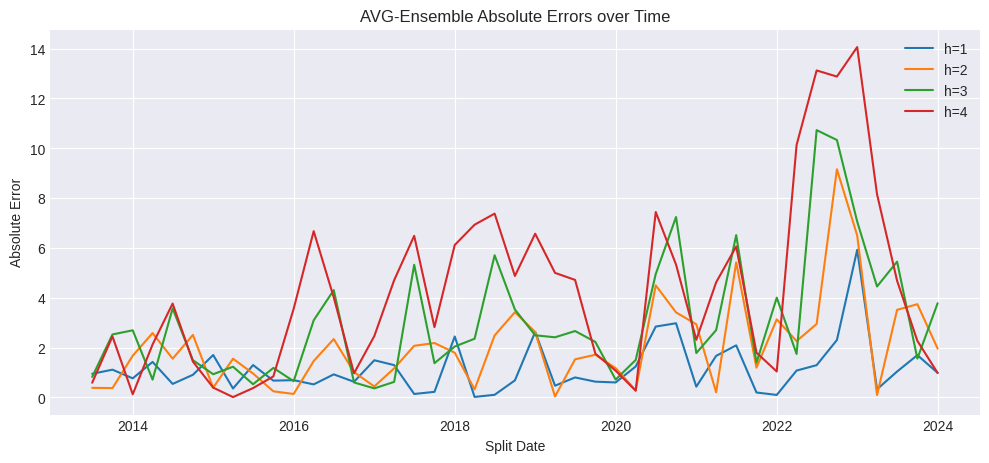

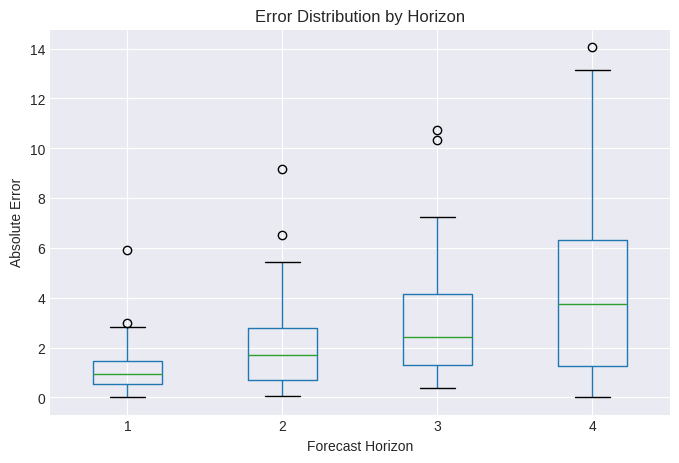

In [ ]:
import matplotlib.pyplot as plt

# 1) Pivot errors to wide form
pivot = stats_df.pivot(index="split_date", columns="horizon", values="error")

# 2) Time-series plot of error by horizon
fig, ax = plt.subplots(figsize=(12,5))
for h in pivot.columns:
    ax.plot(pivot.index, pivot[h], label=f"h={h}")
ax.set_title("AVG-Ensemble Absolute Errors over Time")
ax.set_xlabel("Split Date")
ax.set_ylabel("Absolute Error")
ax.legend()
plt.show()

# 3) Boxplot of error distributions by horizon
fig, ax = plt.subplots(figsize=(8,5))
pivot.boxplot(ax=ax)
ax.set_title("Error Distribution by Horizon")
ax.set_xlabel("Forecast Horizon")
ax.set_ylabel("Absolute Error")
plt.show()


## Horizon-Based Ensamble

* H1: average of ARIMA (1.177 / 1.583) and Bagged RF (B=100) (1.168 / 1.620)
* H2: RF (best) (2.131 / 2.750)
* H3: RF (best) (2.962 / 3.951)
* H4: MLP (3.777 / 4.847)

In [ ]:
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")

# 1) Data‐prep helper
def prepare_mlp_data(df, target_col="dlogHPI_sa", n_lags=4, include_level=True, level_col="logHPI_sa"):
    tmp = df[[target_col] + ([level_col] if include_level else [])].dropna().copy()
    for lag in range(1, n_lags+1):
        tmp[f"{target_col}_lag{lag}"] = tmp[target_col].shift(lag)
    if include_level:
        tmp[f"{level_col}_lag1"] = tmp[level_col].shift(1)
    tmp.dropna(inplace=True)
    feat_cols = [f"{target_col}_lag{lag}" for lag in range(1, n_lags+1)]
    if include_level:
        feat_cols.append(f"{level_col}_lag1")
    X = tmp[feat_cols].copy()
    y = tmp[target_col].copy()
    scaler_X = MinMaxScaler()
    scaler_y = StandardScaler()
    Xs = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)
    ys = pd.Series(scaler_y.fit_transform(y.values.reshape(-1,1)).ravel(), index=y.index)
    return Xs, ys, scaler_X, scaler_y

# 2) Single‐step ARIMA forecast
def arima_forecast(train_df, fh=4):
    m = ARIMA(train_df["dlogHPI_sa"], order=(1,0,1)).fit()
    dlog_fc  = m.forecast(steps=fh)
    last_log = train_df["logHPI_sa"].iloc[-1]
    return np.exp(last_log + dlog_fc.cumsum())

# 3) Single‐step MLP forecast
def final_mlp_forecast(train_df, fh=4):
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(train_df)
    log_ser = train_df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    mlp = MLPRegressor(
        hidden_layer_sizes=(20,10),
        alpha=9.150775570161672e-05,
        learning_rate_init=1.4079821526811928e-04,
        activation="relu",
        max_iter=2000,
        early_stopping=True,
        tol=1e-4,
        n_iter_no_change=50,
        random_state=0
    ).fit(Xs, ys)
    feats, log_base = Xs.iloc[-1].values.copy(), log_ser.iloc[-1]
    preds = []
    for _ in range(fh):
        dlog = mlp.predict(feats.reshape(1,-1))[0]
        dlog = scaler_y.inverse_transform([[dlog]])[0,0]
        log_base += dlog
        preds.append(np.exp(log_base))
        feats = np.roll(feats, -1)
        feats[-1] = scaler_y.transform([[dlog]])[0,0]
    return np.array(preds)

# 4) Single‐step RF forecast
def final_rf_forecast(train_df, fh=4, rf_params=None):
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(train_df)
    log_ser = train_df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    rf = RandomForestRegressor(**rf_params).fit(Xs, ys)
    feats, log_base = Xs.iloc[-1].values.copy(), log_ser.iloc[-1]
    preds = []
    for _ in range(fh):
        dlog = rf.predict(feats.reshape(1,-1))[0]
        dlog = scaler_y.inverse_transform([[dlog]])[0,0]
        log_base += dlog
        preds.append(np.exp(log_base))
        feats = np.roll(feats, -1)
        feats[-1] = scaler_y.transform([[dlog]])[0,0]
    return np.array(preds)

# 5) Bagged RF forecast (B bootstraps)
def final_bagged_rf_forecast(train_df, fh=4, rf_params=None, B=100):
    Xs, ys, scaler_X, scaler_y = prepare_mlp_data(train_df)
    log_ser = train_df["logHPI_sa"].loc[Xs.index].reset_index(drop=True)
    bag_preds = np.zeros(fh)
    n = len(Xs)
    for b in range(B):
        idx = np.random.choice(n, n, replace=True)
        rf = RandomForestRegressor(**rf_params, random_state=b).fit(Xs.iloc[idx], ys.iloc[idx])
        feats, log_base = Xs.iloc[-1].values.copy(), log_ser.iloc[-1]
        preds = []
        for _ in range(fh):
            dlog = rf.predict(feats.reshape(1,-1))[0]
            dlog = scaler_y.inverse_transform([[dlog]])[0,0]
            log_base += dlog
            preds.append(np.exp(log_base))
            feats = np.roll(feats, -1)
            feats[-1] = scaler_y.transform([[dlog]])[0,0]
        bag_preds += np.array(preds)
    return bag_preds / B

# 6) Horizon-based ensemble with stats
def horizon_based_ensemble(df, init_frac=0.8, fh=4):
    n      = len(df)
    init_n = max(int(n * init_frac), fh+1)
    recs   = []

    # define RF params
    rf_best   = {'n_estimators':100, 'max_depth':8, 'max_features':None}
    rf_bagged = {'n_estimators':200, 'max_depth':8, 'max_features':'sqrt'}

    for i in tqdm(range(init_n, n - fh + 1), desc="Horizon-ens splits"):
        split_date = df.index[i-1]
        train = df.iloc[:i].copy()
        test  = df.iloc[i:i+fh].copy()

        # forecasts
        arc = arima_forecast(train, fh)
        mp  = final_mlp_forecast(train, fh)
        rf1 = final_rf_forecast(train, fh, rf_params=rf_best)
        rf2 = final_bagged_rf_forecast(train, fh, rf_params=rf_bagged, B=100)

        # combine per horizon
        combined = [
            np.mean([arc[0], rf2[0]]),  # H1
            rf1[1],                     # H2
            rf1[2],                     # H3
            mp[3]                       # H4
        ]

        for h in range(1, fh+1):
            y_true = test["HPI_All"].iloc[h-1]
            y_pred = combined[h-1]
            recs.append({
                'split_date': split_date,
                'horizon':    h,
                'y_true':     y_true,
                'y_pred':     y_pred,
                'error':      abs(y_true - y_pred)
            })

    stats = pd.DataFrame.from_records(recs)
    # print summary
    print("\n📊 Horizon-based Ensemble errors:")
    for h, g in stats.groupby("horizon"):
        mae  = g["error"].mean()
        rmse = np.sqrt(mean_squared_error(g["y_true"], g["y_pred"]))
        print(f"  h={h}: MAE={mae:.3f}, RMSE={rmse:.3f}")
    return stats

# === Run ===
hpi_q = hpi_quarterly.dropna(subset=["logHPI_sa","dlogHPI_sa"])
horizon_stats = horizon_based_ensemble(hpi_q, init_frac=0.8, fh=4)


Horizon-ens splits:   0%|          | 0/43 [00:00<?, ?it/s]


📊 Horizon-based Ensemble errors:
  h=1: MAE=1.174, RMSE=1.587
  h=2: MAE=2.161, RMSE=2.741
  h=3: MAE=3.050, RMSE=4.069
  h=4: MAE=3.954, RMSE=5.098


# Final results table

In [ ]:
import pandas as pd

# 1) ARIMA + MLP + Bagged-MLP results
mlp_df = pd.DataFrame({
    'ARIMA_MAE':       [1.177,   2.137,   3.258,   4.219],
    'ARIMA_RMSE':      [1.583,   2.920,   4.307,   5.408],
    'MLP_MAE':         [1.33258, 2.34653, 3.17450, 3.77713],
    'MLP_RMSE':        [1.77782, 2.99255, 3.99877, 4.84733],
    'BagMLP50_MAE':    [1.32624, 3.34201, 4.53999, 6.82967],
    'BagMLP50_RMSE':   [1.72221, 4.20448, 5.62173, 8.13373],
    'BagMLP100_MAE':   [1.32710, 3.40738, 4.66166, 7.15253],
    'BagMLP100_RMSE':  [1.72115, 4.27376, 5.73582, 8.45226],
    'BagMLP200_MAE':   [1.33223, 3.42272, 4.72720, 7.26223],
    'BagMLP200_RMSE':  [1.71562, 4.29863, 5.79409, 8.53352],
}, index=[1,2,3,4])

# 2) RF + Bagged-RF results
rf_df = pd.DataFrame({
    'RF_MAE':         [1.20488, 2.18198, 3.45930, 5.89562],
    'RF_RMSE':        [1.62926, 2.78516, 4.55792, 7.24665],
    'BagRF50_MAE':    [1.18025, 2.19938, 3.54816, 5.89378],
    'BagRF50_RMSE':   [1.63739, 2.86193, 4.58592, 7.23848],
    'BagRF100_MAE':   [1.17632, 2.21646, 3.52872, 5.87659],
    'BagRF100_RMSE':  [1.61999, 2.87735, 4.57257, 7.20357],
    'BagRF200_MAE':   [1.16750, 2.21149, 3.52528, 5.83663],
    'BagRF200_RMSE':  [1.63448, 2.87869, 4.55436, 7.18721],
}, index=[1,2,3,4])

# 3) AVG-ensemble & Horizon-based ensemble results
ensemble_df = pd.DataFrame({
    'AVG_ens_MAE':       [1.169, 2.080, 3.056, 4.265],
    'AVG_ens_RMSE':      [1.572, 2.760, 3.930, 5.548],
    'HorizonEns_MAE':    [1.174, 2.161, 3.050, 3.954],
    'HorizonEns_RMSE':   [1.587, 2.741, 4.069, 5.098],
}, index=[1,2,3,4])

# 4) Combine into a single DataFrame
df = pd.concat([mlp_df, rf_df, ensemble_df], axis=1)
df.index.name = 'horizon'

# 5) Define the list of variants to display
variants = [
    'ARIMA',
    'MLP',
    'BagMLP50', 'BagMLP100', 'BagMLP200',
    'RF',
    'BagRF50', 'BagRF100', 'BagRF200',
    'AVG_ens',
    'HorizonEns'
]

# 6) Build the formatted comparison table
compare = pd.DataFrame(index=df.index)
for v in variants:
    compare[v] = (
        df[f"{v}_MAE"].round(3).astype(str)
        + " / "
        + df[f"{v}_RMSE"].round(3).astype(str)
    )

# 7) Add a MEAN row
mean_vals = {
    v: f"{df[f'{v}_MAE'].mean():.3f} / {df[f'{v}_RMSE'].mean():.3f}"
    for v in variants
}
compare.loc['MEAN'] = pd.Series(mean_vals)

# 8) Display
compare


ARIMA            MLP       BagMLP50      BagMLP100  \
horizon                                                               
1        1.177 / 1.583  1.333 / 1.778  1.326 / 1.722  1.327 / 1.721   
2         2.137 / 2.92  2.347 / 2.993  3.342 / 4.204  3.407 / 4.274   
3        3.258 / 4.307  3.174 / 3.999   4.54 / 5.622  4.662 / 5.736   
4        4.219 / 5.408  3.777 / 4.847   6.83 / 8.134  7.153 / 8.452   
MEAN     2.698 / 3.554  2.658 / 3.404  4.009 / 4.921  4.137 / 5.046   

             BagMLP200             RF        BagRF50       BagRF100  \
horizon                                                               
1        1.332 / 1.716  1.205 / 1.629   1.18 / 1.637   1.176 / 1.62   
2        3.423 / 4.299  2.182 / 2.785  2.199 / 2.862  2.216 / 2.877   
3        4.727 / 5.794  3.459 / 4.558  3.548 / 4.586  3.529 / 4.573   
4        7.262 / 8.534  5.896 / 7.247  5.894 / 7.238  5.877 / 7.204   
MEAN     4.186 / 5.085  3.185 / 4.055  3.205 / 4.081  3.200 / 4.068   

              BagRF200        AVG_ens     HorizonEns  
horizon                                               
1        1.168 / 1.634  1.169 / 1.572  1.174 / 1.587  
2        2.211 / 2.879    2.08 / 2.76  2.161 / 2.741  
3        3.525 / 4.554   3.056 / 3.93   3.05 / 4.069  
4        5.837 / 7.187  4.265 / 5.548  3.954 / 5.098  
MEAN     3.185 / 4.064  2.643 / 3.453  2.585 / 3.374

In [ ]:
import pandas as pd

# 1) ARIMA + MLP + Bagged-MLP results
mlp_df = pd.DataFrame({
    'ARIMA_MAE':       [1.177,   2.137,   3.258,   4.219],
    'ARIMA_RMSE':      [1.583,   2.920,   4.307,   5.408],
    'MLP_MAE':         [1.33258, 2.34653, 3.17450, 3.77713],
    'MLP_RMSE':        [1.77782, 2.99255, 3.99877, 4.84733],
    'BagMLP50_MAE':    [1.32624, 3.34201, 4.53999, 6.82967],
    'BagMLP50_RMSE':   [1.72221, 4.20448, 5.62173, 8.13373],
    'BagMLP100_MAE':   [1.32710, 3.40738, 4.66166, 7.15253],
    'BagMLP100_RMSE':  [1.72115, 4.27376, 5.73582, 8.45226],
    'BagMLP200_MAE':   [1.33223, 3.42272, 4.72720, 7.26223],
    'BagMLP200_RMSE':  [1.71562, 4.29863, 5.79409, 8.53352],
}, index=[1,2,3,4])

# 2) RF + Bagged-RF results
rf_df = pd.DataFrame({
    'RF_MAE':         [1.20488, 2.18198, 3.45930, 5.89562],
    'RF_RMSE':        [1.62926, 2.78516, 4.55792, 7.24665],
    'BagRF50_MAE':    [1.18025, 2.19938, 3.54816, 5.89378],
    'BagRF50_RMSE':   [1.63739, 2.86193, 4.58592, 7.23848],
    'BagRF100_MAE':   [1.17632, 2.21646, 3.52872, 5.87659],
    'BagRF100_RMSE':  [1.61999, 2.87735, 4.57257, 7.20357],
    'BagRF200_MAE':   [1.16750, 2.21149, 3.52528, 5.83663],
    'BagRF200_RMSE':  [1.63448, 2.87869, 4.55436, 7.18721],
}, index=[1,2,3,4])

# 3) AVG-ensemble & Horizon-based ensemble results
ensemble_df = pd.DataFrame({
    'AVG_ens_MAE':       [1.169, 2.080, 3.056, 4.265],
    'AVG_ens_RMSE':      [1.572, 2.760, 3.930, 5.548],
    'HorizonEns_MAE':    [1.174, 2.161, 3.050, 3.954],
    'HorizonEns_RMSE':   [1.587, 2.741, 4.069, 5.098],
}, index=[1,2,3,4])

# 4) Combine into a single DataFrame
df = pd.concat([mlp_df, rf_df, ensemble_df], axis=1)
df.index.name = 'horizon'

# 5) Define the list of variants to display
variants = [
    'ARIMA',
    'MLP',
    'RF',
    'BagRF100',
    'AVG_ens',
    'HorizonEns'
]

# 6) Build the formatted comparison table
compare = pd.DataFrame(index=df.index)
for v in variants:
    compare[v] = (
        df[f"{v}_MAE"].round(3).astype(str)
        + " / "
        + df[f"{v}_RMSE"].round(3).astype(str)
    )

# 7) Add a MEAN row
mean_vals = {
    v: f"{df[f'{v}_MAE'].mean():.3f} / {df[f'{v}_RMSE'].mean():.3f}"
    for v in variants
}
compare.loc['MEAN'] = pd.Series(mean_vals)

# 8) Display
compare


ARIMA            MLP             RF       BagRF100  \
horizon                                                               
1        1.177 / 1.583  1.333 / 1.778  1.205 / 1.629   1.176 / 1.62   
2         2.137 / 2.92  2.347 / 2.993  2.182 / 2.785  2.216 / 2.877   
3        3.258 / 4.307  3.174 / 3.999  3.459 / 4.558  3.529 / 4.573   
4        4.219 / 5.408  3.777 / 4.847  5.896 / 7.247  5.877 / 7.204   
MEAN     2.698 / 3.554  2.658 / 3.404  3.185 / 4.055  3.200 / 4.068   

               AVG_ens     HorizonEns  
horizon                                
1        1.169 / 1.572  1.174 / 1.587  
2          2.08 / 2.76  2.161 / 2.741  
3         3.056 / 3.93   3.05 / 4.069  
4        4.265 / 5.548  3.954 / 5.098  
MEAN     2.643 / 3.453  2.585 / 3.374

In [ ]:
import pandas as pd
import altair as alt

# --- 1) Define your top models ---
main_models = ['ARIMA','MLP','RF','BagRF100','AVG_ens','HorizonEns']

# --- 2) Build a small numeric DataFrame for horizons H1–H4 ---
records = []
for h in [1,2,3,4]:
    rec = {'Horizon': f"H{h}"}
    for m in main_models:
        rec[f"{m}_MAE"]  = df.loc[h, f"{m}_MAE"]
        rec[f"{m}_RMSE"] = df.loc[h, f"{m}_RMSE"]
    records.append(rec)
num_df = pd.DataFrame(records)

# --- 3) Melt for RMSE plot ---
rmse_melt = num_df.melt(
    id_vars=['Horizon'],
    value_vars=[f"{m}_RMSE" for m in main_models],
    var_name='Model',
    value_name='RMSE'
)
rmse_melt['Model'] = rmse_melt['Model'].str.replace('_RMSE','')

# --- 4) Altair RMSE Chart ---
chart_rmse = alt.Chart(rmse_melt).mark_line(point=True).encode(
    x=alt.X('Horizon:N', sort=['H1','H2','H3','H4']),
    y='RMSE:Q',
    color='Model:N'
).properties(
    width=1600,
    height=800,
    title='Top Models RMSE by Forecast Horizon'
).interactive()

# Display
chart_rmse


alt.Chart(...)

In [ ]:
import altair as alt

bar_df = rmse_melt.copy()
chart_bar = (
    alt.Chart(bar_df)
      .mark_bar()
      .encode(
         x=alt.X('Horizon:N', sort=['H1','H2','H3','H4']),
         y='RMSE:Q',
         color='Model:N',
         column=alt.Column('Horizon:N', title=None, header=alt.Header(labelAngle=0))
      )
      .properties(title='RMSE by Model and Horizon', width=200, height=400)
)
chart_bar


alt.Chart(...)

In [ ]:
import altair as alt

grouped = (
    alt.Chart(rmse_melt)
      .mark_bar()
      .encode(
        x=alt.X('Horizon:N', sort=['H1','H2','H3','H4'], title='Horizon'),
        xOffset='Model:N',                       # <-- dodge by Model
        y=alt.Y('RMSE:Q', title='RMSE'),
        color=alt.Color('Model:N', legend=alt.Legend(title='Model'))
      )
      .properties(width=600, height=400, title='RMSE by Model & Horizon (Grouped Bars)')
)
grouped


alt.Chart(...)

In [ ]:
import altair as alt

ranked = (
    alt.Chart(rmse_melt)
      # 1) Define a window transform that ranks each Model *within each Horizon* by RMSE
      .transform_window(
          window=[{"op": "rank", "as": "rank"}],        # <-- must supply op here
          groupby=["Horizon"],                           # rank resets per horizon
          sort=[alt.SortField("RMSE", order="descending")]
      )
      # 2) Draw the bars, dodging by the computed rank
      .mark_bar()
      .encode(
        x=alt.X("Horizon:N", sort=["H1","H2","H3","H4"], title="Horizon"),
        xOffset=alt.XOffset("rank:O"),                 # use that rank for the dodge position
        y=alt.Y("RMSE:Q", title="RMSE"),
        color=alt.Color("Model:N", legend=alt.Legend(title="Model")),
        tooltip=["Model","Horizon","RMSE"]
      )
      .properties(
         width=600, height=400,
         title="RMSE by Model & Horizon (Each Cluster Sorted by RMSE)"
      )
)

ranked


alt.Chart(...)

In [ ]:
import altair as alt

# 1) Compute per‐horizon rank as before
base = (
    alt.Chart(rmse_melt)
      .transform_window(
          window=[{"op": "rank", "as": "rank"}],
          groupby=["Horizon"],
          sort=[alt.SortField("RMSE", order="descending")]
      )
)

# 2) Bars, dodged by rank
bars = base.mark_bar().encode(
    x=alt.X("Horizon:N", sort=["H1","H2","H3","H4"], title="Horizon"),
    xOffset=alt.XOffset("rank:O"),
    y=alt.Y("RMSE:Q", title="RMSE"),
    color=alt.Color("Model:N", legend=alt.Legend(title="Model"))
)

# 3) Text labels, positioned just above each bar
labels = base.mark_text(
    dy=-5,               # move text 5px up from the top of the bar
    fontSize=10
).encode(
    x=alt.X("Horizon:N", sort=["H1","H2","H3","H4"]),
    xOffset=alt.XOffset("rank:O"),
    y=alt.Y("RMSE:Q"),
    text=alt.Text("RMSE:Q", format=".2f")
)

# 4) Layer them together
chart = (bars + labels).properties(
    width=1200, height=600,
    title="RMSE by Model & Horizon (Sorted + Value Labels)"
)

chart


alt.LayerChart(...)

In [ ]:
import altair as alt
import pandas as pd

# Sample rmse_melt data (reuse your existing DataFrame in practice)
rmse_melt = pd.DataFrame({
    'Horizon': ['H1','H1','H1','H1','H1','H1','H2','H2','H2','H2','H2','H2','H3','H3','H3','H3','H3','H3','H4','H4','H4','H4','H4','H4'],
    'Model': ['ARIMA','AVG_ens','BagRF100','HorizonEns','MLP','RF']*4,
    'RMSE': [
        1.583,1.572,1.605,1.587,1.7778,1.6293,
        2.920,2.760,2.870,2.741,2.9926,2.7852,
        4.307,3.930,4.5859,4.069,3.9988,4.5579,
        5.408,5.548,7.2385,5.098,4.8473,7.2467
    ]
})

# Create the ranked base
base = (
    alt.Chart(rmse_melt)
      .transform_window(
          window=[{"op": "rank", "as": "rank"}],
          groupby=["Horizon"],
          sort=[alt.SortField("RMSE", order="descending")]
      )
)

# Bars with custom size and padding
bars = base.mark_bar(size=38).encode(
    x=alt.X(
        "Horizon:N",
        sort=['H1','H2','H3','H4'],
        title="Horizon",
        scale=alt.Scale(paddingInner=0.1)  # spacing between clusters
    ),
    xOffset=alt.XOffset("rank:O"),
    y=alt.Y("RMSE:Q", title="RMSE"),
    color=alt.Color("Model:N", legend=alt.Legend(title="Model"))
)

# Labels
labels = base.mark_text(
    dy=-10,
    fontSize=14
).encode(
    x=alt.X("Horizon:N", sort=['H1','H2','H3','H4'], scale=alt.Scale(paddingInner=0.3)),
    xOffset=alt.XOffset("rank:O"),
    y=alt.Y("RMSE:Q"),
    text=alt.Text("RMSE:Q", format=".2f")
)

# Final chart
chart = (bars + labels).properties(
    width=1200,
    height=600,
    title="RMSE by Model & Horizon (Sorted + Value Labels + Spacing)"
)

chart


alt.LayerChart(...)

In [ ]:
import altair as alt
import pandas as pd

# (Your rmse_melt and base-transform code stays the same…)

bars = base.mark_bar(size=38).encode(
    x=alt.X(
        "Horizon:N",
        sort=['H1','H2','H3','H4'],
        title="Horizon",
        axis=alt.Axis(labelFontSize=16, titleFontSize=18),
        scale=alt.Scale(paddingInner=0.1)
    ),
    xOffset=alt.XOffset("rank:O"),
    y=alt.Y(
        "RMSE:Q",
        title="RMSE",
        axis=alt.Axis(labelFontSize=16, titleFontSize=18)
    ),
    color=alt.Color(
        "Model:N",
        legend=alt.Legend(
           title="Model",
           titleFontSize=18,
           labelFontSize=16,
           orient="right"
        )
    )
)

labels = base.mark_text(
    dy=-10,
    fontSize=14
).encode(
    x=alt.X(
        "Horizon:N",
        sort=['H1','H2','H3','H4'],
        scale=alt.Scale(paddingInner=0.3)
    ),
    xOffset=alt.XOffset("rank:O"),
    y="RMSE:Q",
    text=alt.Text("RMSE:Q", format=".2f")
)

chart = (bars + labels).properties(
    width=1200,
    height=600,
    title=alt.TitleParams(
        "RMSE by Model & Horizon (Sorted + Value Labels + Spacing)",
        fontSize=20
    )
)

chart


alt.LayerChart(...)

# April models with 2nd diference data

##Compute and Analyze Differenced HPI Series

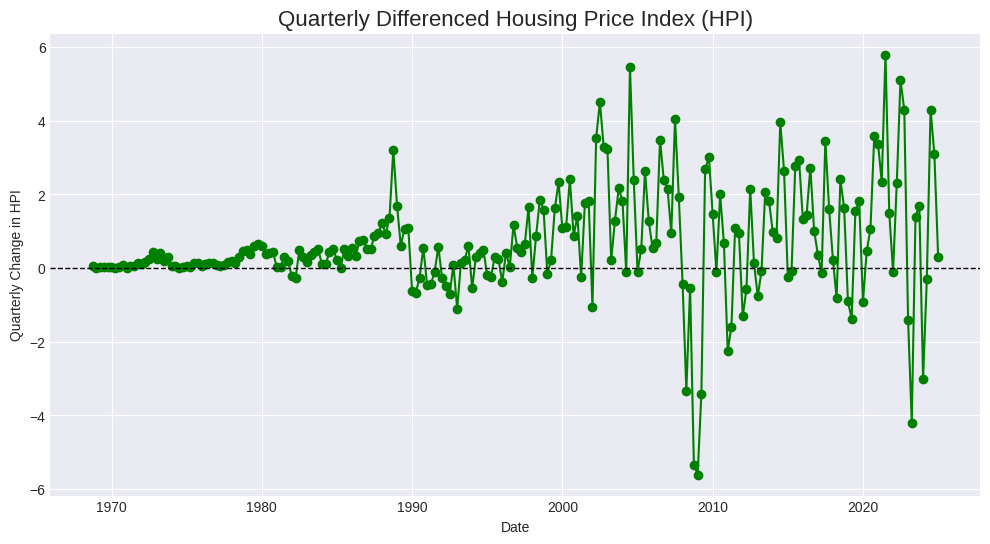

In [ ]:
# Compute quarterly difference explicitly
hpi_quarterly["HPI_Diff"] = hpi_quarterly["HPI_All"].diff()

# Drop NaNs from differencing
hpi_quarterly.dropna(inplace=True)

# Plot Differenced Data Clearly
plt.figure(figsize=(12, 6))
plt.plot(hpi_quarterly.index, hpi_quarterly["HPI_Diff"], marker='o', linestyle='-', color='green')
plt.title("Quarterly Differenced Housing Price Index (HPI)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Quarterly Change in HPI")
plt.grid(True)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()


### 2nd Comment

Documentation for Notebook (Quarterly Differencing and Visualization)
Step 4: Quarterly Differencing to Address Stationarity

In this step, a first-order differencing of the quarterly HPI data was explicitly applied to help remove the evident upward trend identified earlier. The differencing technique subtracts each observation from its preceding one, effectively capturing the quarter-to-quarter change in the housing price index.

Differencing Calculation:

HPI_Diff
𝑡
=
HPI
𝑡
−
HPI
𝑡
−
1
HPI_Diff
t
​
 =HPI
t
​
 −HPI
t−1
​

Rationale for Differencing:
Differencing is commonly applied in time-series analysis to stabilize the mean of the series, explicitly addressing issues with stationarity that might arise due to trends or other non-stationary components.

Step 5: Visualization of Differenced Data

The clearly plotted quarterly differenced HPI explicitly demonstrates the following key observations:

Removal of Long-term Trend:
The differenced data appears to have no clear upward or downward trend, suggesting effective removal of the long-term growth component.

Increased Variability over Time:
A clear increase in volatility is observed, especially after the late 1980s. This highlights the heteroscedastic nature of the differenced HPI, implying varying market conditions, economic shifts, and potential structural changes over the decades.

Notable Outliers and Volatility Spikes:
Prominent spikes in quarterly changes are visible around key historical periods (e.g., late 1980s property boom, early 1990s recession, 2008 financial crisis, and the COVID-19 pandemic), clearly illustrating the sensitivity of the housing market to broader economic events.

Zero Line Reference:
The black dashed horizontal line at zero clearly emphasizes quarters of growth (above zero) and contraction (below zero), providing easy interpretability of the differenced values.



## OLD ADF Stationarity Test (Critical Analysis Step)

In [ ]:
# ADF test clearly
adf_result = adfuller(hpi_quarterly["HPI_Diff"])

# Clearly print ADF results
print("ADF Test Results:")
print(f"  ADF Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print("  Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value:.4f}")

# Explicit interpretation
if adf_result[1] < 0.05:
    print("\n✅ The series is stationary (reject H0).")
else:
    print("\n❌ The series is NOT stationary (fail to reject H0).")


ADF Test Results:
  ADF Statistic: -2.0552
  p-value: 0.2629
  Critical Values:
	1%: -3.4619
	5%: -2.8754
	10%: -2.5742

❌ The series is NOT stationary (fail to reject H0).


##Additional (Second-order) Differencing

In [ ]:
# Second-order differencing to achieve stationarity
hpi_quarterly["HPI_Diff2"] = hpi_quarterly["HPI_Diff"].diff()
hpi_quarterly = hpi_quarterly.dropna()

# Drop NaNs from the second differencing
final_hpi_data_diff2 = hpi_quarterly["HPI_Diff2"].dropna()

# Perform ADF test again explicitly on second-order differenced data
adf_result2 = adfuller(final_hpi_data_diff2)

print("\nSecond-order Differencing ADF Test Results:")
print(f"  ADF Statistic: {adf_result2[0]:.4f}")
print(f"  p-value: {adf_result2[1]:.4f}")
print("  Critical Values:")
for key, value in adf_result2[4].items():
    print(f"\t{key}: {value:.4f}")

if adf_result2[1] < 0.05:
    print("\n✅ Second-order differenced series is stationary.")
else:
    print("\n❌ Still NOT stationary after second-order differencing.")



Second-order Differencing ADF Test Results:
  ADF Statistic: -4.5164
  p-value: 0.0002
  Critical Values:
	1%: -3.4620
	5%: -2.8755
	10%: -2.5742

✅ Second-order differenced series is stationary.


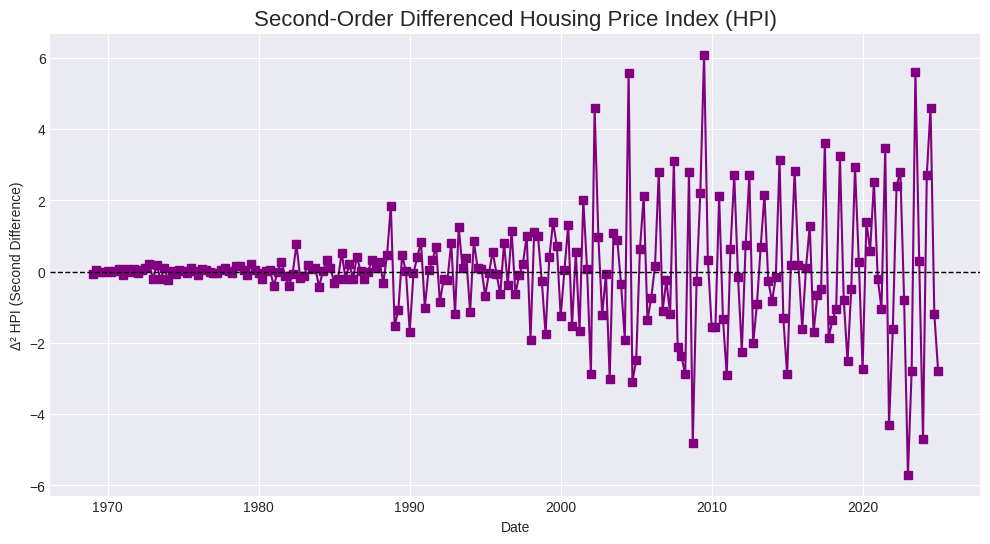

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(hpi_quarterly.index, hpi_quarterly["HPI_Diff2"], marker='s', linestyle='-', color='purple')
plt.title("Second-Order Differenced Housing Price Index (HPI)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Δ² HPI (Second Difference)")
plt.grid(True)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()


In [ ]:
hpi_quarterly

HPI_All  HPI_Diff  HPI_Diff2
Date                                    
1968-12-31     1.94     -0.01      -0.07
1969-03-31     1.97      0.03       0.04
1969-06-30     2.00      0.03       0.00
1969-09-30     2.02      0.02      -0.01
1969-12-31     2.05      0.03       0.01
...             ...       ...        ...
2023-12-31   145.80     -3.00      -4.70
2024-03-31   145.50     -0.30       2.70
2024-06-30   149.80      4.30       4.60
2024-09-30   152.90      3.10      -1.20
2024-12-31   153.20      0.30      -2.80

[225 rows x 3 columns]

### 3rd Comment

Documentation for Notebook (Stationarity Testing and Second-order Differencing)
Step 6: Augmented Dickey-Fuller (ADF) Stationarity Test on First-order Differenced Data
The Augmented Dickey-Fuller (ADF) test explicitly assesses whether the quarterly differenced HPI series (HPI_Diff) is stationary or not. The null hypothesis (H0) of the ADF test assumes the presence of a unit root, indicating that the series is non-stationary.

ADF Statistic: -2.0552

p-value: 0.2629

Critical Values:

1%: -3.4619

5%: -2.8754

10%: -2.5742

Interpretation:

The computed p-value of 0.2629 exceeds the significance level of 0.05.

Therefore, we fail to reject the null hypothesis (H0).

Explicitly, this means the first-order differenced series is NOT stationary.

This result suggests that a single differencing step was insufficient to fully remove non-stationarity.

Step 7: Second-order Differencing for Stationarity
Given the failed stationarity test on first-order differencing, we explicitly applied second-order differencing—taking the difference of the already differenced series—to address any residual trend or non-stationarity.

Second-order differencing calculation:

HPI_Diff2
𝑡
=
HPI_Diff
𝑡
−
HPI_Diff
𝑡
−
1
HPI_Diff2
t
​
 =HPI_Diff
t
​
 −HPI_Diff
t−1
​

Data points after second-order differencing: Reduced from 226 to 225 due to another NaN resulting from the additional differencing operation.

Step 8: ADF Test on Second-order Differenced Data
Reapplying the ADF test to the second-order differenced series (HPI_Diff2):

ADF Statistic: -4.5164

p-value: 0.0002

Critical Values:

1%: -3.4620

5%: -2.8755

10%: -2.5742

Interpretation:

The computed p-value of 0.0002 is now significantly below the threshold of 0.05.

We clearly reject the null hypothesis (H0).

Explicitly, this confirms that the second-order differenced series is stationary.



##ACF and PACF Analysis (Essential for ARIMA)

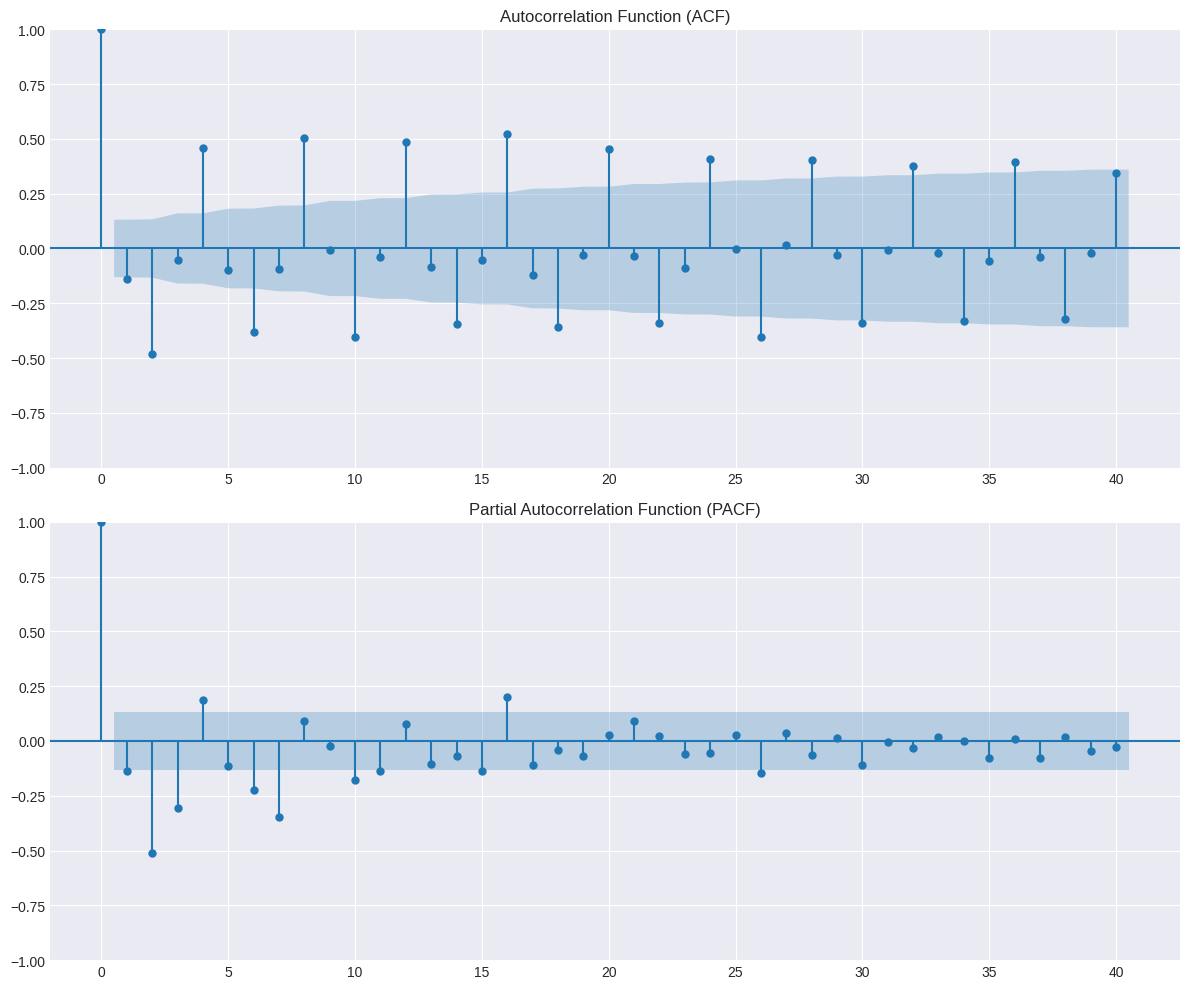

In [ ]:
# Plot ACF & PACF clearly for determining ARIMA order
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(hpi_quarterly["HPI_Diff2"], lags=40, ax=axes[0])
plot_pacf(hpi_quarterly["HPI_Diff2"], lags=40, method='ywm', ax=axes[1])

axes[0].set_title("Autocorrelation Function (ACF)")
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


##Final Prepared DataFrame for Modeling (Clearly Structured)

In [ ]:
# Final dataset for ARIMA/NN modeling pipelines
final_hpi_data = hpi_quarterly.copy()

# Quick final check
print(final_hpi_data.head())
print(final_hpi_data.tail())


            HPI_All  HPI_Diff  HPI_Diff2
Date                                    
1968-12-31     1.94     -0.01      -0.07
1969-03-31     1.97      0.03       0.04
1969-06-30     2.00      0.03       0.00
1969-09-30     2.02      0.02      -0.01
1969-12-31     2.05      0.03       0.01
            HPI_All  HPI_Diff  HPI_Diff2
Date                                    
2023-12-31    145.8      -3.0       -4.7
2024-03-31    145.5      -0.3        2.7
2024-06-30    149.8       4.3        4.6
2024-09-30    152.9       3.1       -1.2
2024-12-31    153.2       0.3       -2.8


### 4th Comment

 Documentation for Notebook (ACF and PACF Analysis)
Step 9: Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) Plots
The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are used explicitly to identify potential ARIMA model orders (p and q) by examining the correlation structure in the stationary time series data (second-order differenced series, HPI_Diff2).

ACF Analysis:
The ACF plot exhibits several significant spikes at early lags (e.g., lags 1, 4, 8), with diminishing but occasionally persistent spikes at higher lags (e.g., around lags 12, 24, 28).

These spikes indicate that past values at these lags continue to influence the current values of the series, suggesting the presence of moving average (MA) components.

A noticeable seasonal-like structure with repeated spikes at regular intervals (approximately every 4 to 8 quarters) hints toward potential seasonal components or cyclic behavior.

PACF Analysis:
The PACF plot shows significant spikes primarily at lower lags, with clear significance at lags 1 and 4, and some borderline significance around lag 8.

After these lags, the spikes quickly fall within confidence intervals, implying limited direct relationship beyond the initial few lags. This suggests autoregressive (AR) terms of low to moderate order (p ≈ 1–4).

📌 Conclusion and Next Steps:
From the ACF and PACF plots:

AR Order (p): Likely ranges between 1 and 4 due to clear early spikes in the PACF plot.

MA Order (q): Possibly also low-to-moderate due to observed spikes at early and certain periodic lags in the ACF plot.

The observed pattern indicates potentially seasonal or cyclical behavior, which may suggest the exploration of seasonal ARIMA (SARIMA) models if standard ARIMA performance is inadequate.

## ARIMA pipeline

In [ ]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress routine SARIMAX warnings during the grid search
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def run_arima_pipeline(data, arima_order=(1, 0, 1), forecast_horizon=4, init_train_frac=0.50):
    """
    Runs a fixed multi-step rolling forecast using an expanding window on the provided data.

    Returns only the aggregated error statistics across all horizons.
    """
    n = len(data)
    initial_train_size = max(int(n * init_train_frac), forecast_horizon + 1)

    all_forecasts = []
    all_actuals = []

    # Expanding-window rolling forecast
    for i in range(initial_train_size, n - forecast_horizon + 1):
        train = data.iloc[:i]
        test = data.iloc[i : i + forecast_horizon]

        last_level = train["HPI_All"].iloc[-1]
        try:
            model = ARIMA(train["HPI_Diff"], order=arima_order)
            res = model.fit()
            diff_fc = res.forecast(steps=forecast_horizon)
            level_fc = last_level + diff_fc.cumsum()
        except Exception:
            level_fc = pd.Series([np.nan] * forecast_horizon, index=test.index)

        all_forecasts.extend(level_fc.values)
        all_actuals.extend(test["HPI_All"].values)

    f = np.array(all_forecasts)
    a = np.array(all_actuals)
    valid = ~np.isnan(f)

    return {
        "Overall_MAE": mean_absolute_error(a[valid], f[valid]),
        "Overall_RMSE": np.sqrt(mean_squared_error(a[valid], f[valid]))
    }




In [ ]:
# ---------------------------------------------------------------------
# Grid search over ARIMA orders (p,0,q) and initial training fractions

p_values = [0, 1, 2, 4]
q_values = [0, 1, 2, 4]
init_fracs = [0.60, 0.70, 0.80]
forecast_horizon = 4

grid_results = []

for frac in init_fracs:
    for p in p_values:
        for q in q_values:
            errs = run_arima_pipeline(
                data=final_hpi_data,
                arima_order=(p, 0, q),
                forecast_horizon=forecast_horizon,
                init_train_frac=frac
            )
            grid_results.append({
                "init_train_frac": frac,
                "order": (p, 0, q),
                "Overall_MAE": errs["Overall_MAE"],
                "Overall_RMSE": errs["Overall_RMSE"]
            })
            print(f"frac={frac}, order={(p,0,q)} → RMSE={errs['Overall_RMSE']:.4f}")

# Summarize results
grid_df = pd.DataFrame(grid_results)
print("\nGrid Search Summary:")
print(grid_df[["init_train_frac", "order", "Overall_MAE", "Overall_RMSE"]])

frac=0.6, order=(0, 0, 0) → RMSE=4.2606
frac=0.6, order=(0, 0, 1) → RMSE=4.1163
frac=0.6, order=(0, 0, 2) → RMSE=4.1389


KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


➡️ Running diagnostics for ARIMA(2, 0, 4) (init_frac=0.8)
h=1: MAE=1.2323, RMSE=1.5889
h=2: MAE=2.2409, RMSE=2.8970
h=3: MAE=2.9805, RMSE=3.9063
h=4: MAE=3.6056, RMSE=4.7393

Aggregated: MAE=2.5148, RMSE=3.4870

Final iteration model summary:
                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  221
Model:                 ARIMA(2, 0, 4)   Log Likelihood                -333.666
Date:                Tue, 22 Apr 2025   AIC                            683.333
Time:                        20:25:42   BIC                            710.518
Sample:                    12-31-1968   HQIC                           694.310
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


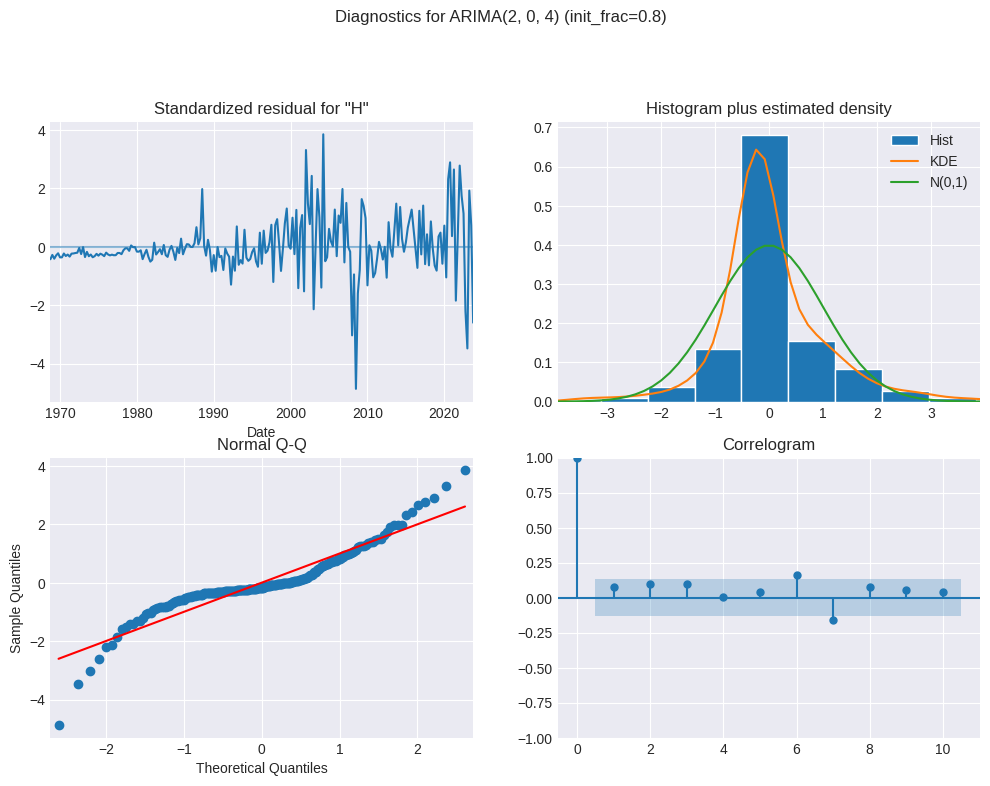

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


➡️ Running diagnostics for ARIMA(4, 0, 4) (init_frac=0.8)
h=1: MAE=1.2888, RMSE=1.6538
h=2: MAE=2.2962, RMSE=3.0584
h=3: MAE=3.0129, RMSE=4.0677
h=4: MAE=3.4730, RMSE=4.8177

Aggregated: MAE=2.5177, RMSE=3.6002

Final iteration model summary:
                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  221
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -324.956
Date:                Tue, 22 Apr 2025   AIC                            669.912
Time:                        20:26:31   BIC                            703.894
Sample:                    12-31-1968   HQIC                           683.634
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


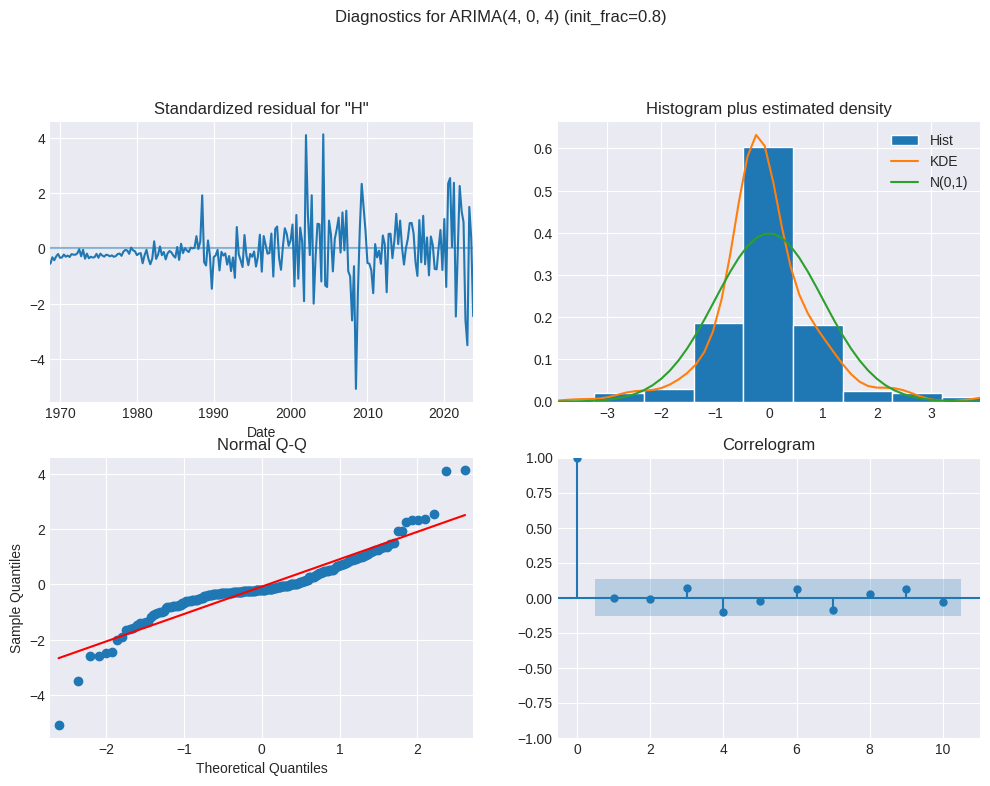


➡️ Running diagnostics for ARIMA(4, 0, 1) (init_frac=0.8)
h=1: MAE=1.3851, RMSE=1.7783
h=2: MAE=2.5824, RMSE=3.2799
h=3: MAE=3.3523, RMSE=4.1215
h=4: MAE=3.5092, RMSE=4.6770

Aggregated: MAE=2.7072, RMSE=3.6325

Final iteration model summary:
                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  221
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -354.629
Date:                Tue, 22 Apr 2025   AIC                            723.257
Time:                        20:26:51   BIC                            747.045
Sample:                    12-31-1968   HQIC                           732.862
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

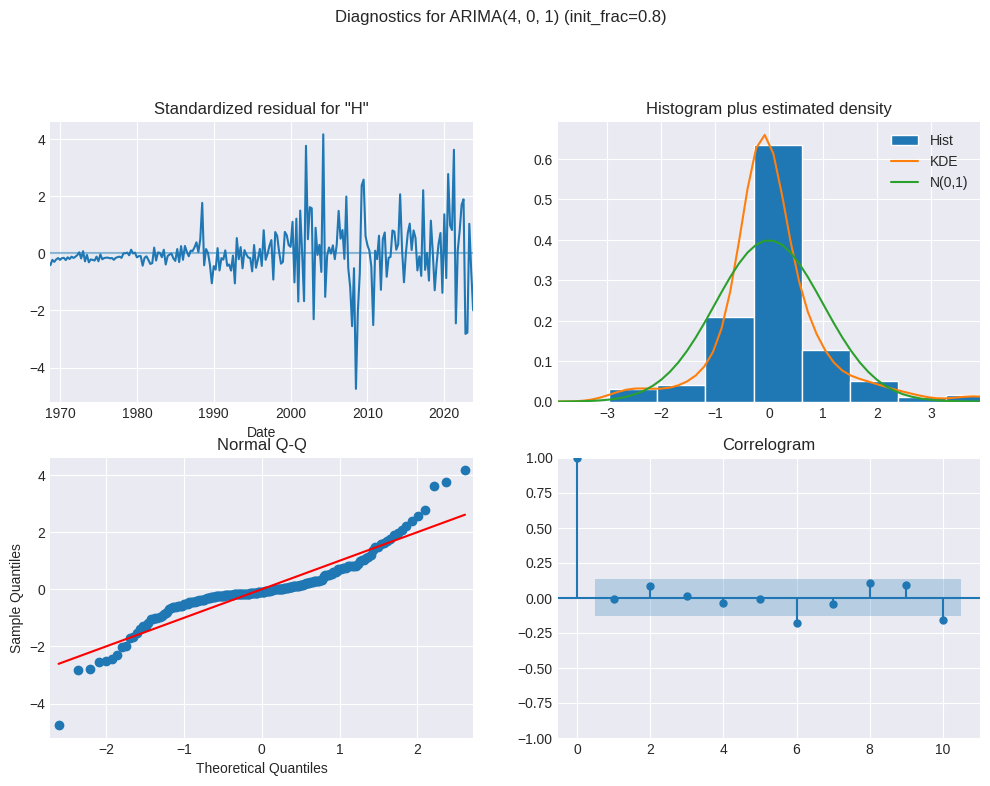


➡️ Running diagnostics for ARIMA(4, 0, 0) (init_frac=0.8)
h=1: MAE=1.4190, RMSE=1.7697
h=2: MAE=2.6770, RMSE=3.3112
h=3: MAE=3.3880, RMSE=4.1584
h=4: MAE=3.5620, RMSE=4.7104

Aggregated: MAE=2.7615, RMSE=3.6598

Final iteration model summary:
                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  221
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -361.828
Date:                Tue, 22 Apr 2025   AIC                            735.656
Time:                        20:26:57   BIC                            756.045
Sample:                    12-31-1968   HQIC                           743.889
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

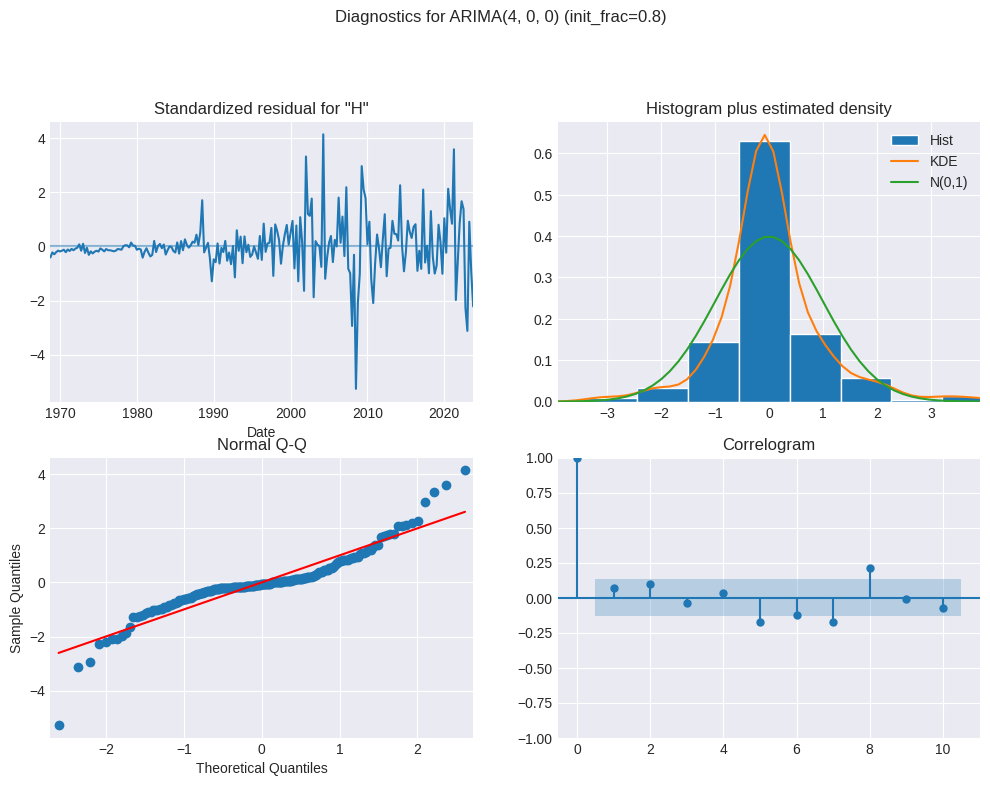

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Re-enable warnings for visibility in final diagnostics
warnings.resetwarnings()

def full_arima_diagnostics(data, arima_order, init_train_frac, forecast_horizon=4):
    """
    Runs a rolling-expanding ARIMA forecast with diagnostics on residuals.

    Parameters:
        data (DataFrame): must contain 'HPI_All' and 'HPI_Diff'.
        arima_order (tuple): (p,d,q) order.
        init_train_frac (float): fraction of initial training set.
        forecast_horizon (int): number of quarters ahead to predict (default 4).

    Outputs:
        - Multi-horizon MAE/RMSE
        - Final model summary
        - Residual diagnostics
    """
    n = len(data)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)

    preds = {h: [] for h in range(1, forecast_horizon+1)}
    acts  = {h: [] for h in range(1, forecast_horizon+1)}
    final_summary = None

    for i in range(init_n, n - forecast_horizon + 1):
        train = data.iloc[:i]
        test  = data.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        try:
            model = ARIMA(train["HPI_Diff"], order=arima_order).fit()
            diff_fc = model.forecast(steps=forecast_horizon)
            level_fc = last_level + diff_fc.cumsum()
        except Exception as e:
            print(f"[Warning] ARIMA{arima_order} failed at split {i}: {e}")
            level_fc = pd.Series([np.nan] * forecast_horizon, index=test.index)

        for h in range(1, forecast_horizon+1):
            preds[h].append(level_fc.iloc[h-1])
            acts[h].append(test["HPI_All"].iloc[h-1])

        if i == n - forecast_horizon:
            final_summary = model.summary().as_text()

    print(f"\n➡️ Running diagnostics for ARIMA{arima_order} (init_frac={init_train_frac})")

    all_fc, all_ac = [], []
    for h in range(1, forecast_horizon+1):
        f = np.array(preds[h])
        a = np.array(acts[h])
        valid = ~np.isnan(f)
        mae = mean_absolute_error(a[valid], f[valid])
        rmse = np.sqrt(mean_squared_error(a[valid], f[valid]))
        print(f"h={h}: MAE={mae:.4f}, RMSE={rmse:.4f}")
        all_fc.extend(f[valid])
        all_ac.extend(a[valid])

    overall_mae = mean_absolute_error(all_ac, all_fc)
    overall_rmse = np.sqrt(mean_squared_error(all_ac, all_fc))
    print(f"\nAggregated: MAE={overall_mae:.4f}, RMSE={overall_rmse:.4f}")

    print("\nFinal iteration model summary:")
    print(final_summary)

    # Residual diagnostics on the last full training window
    last_train_end = n - forecast_horizon
    train_final = data.iloc[:last_train_end]
    model_final = ARIMA(train_final["HPI_Diff"], order=arima_order).fit()
    model_final.plot_diagnostics(figsize=(12, 8))
    plt.suptitle(f"Diagnostics for ARIMA{arima_order} (init_frac={init_train_frac})", y=1.02)
    plt.show()

# ---------------------------------------------------------------------
# Run diagnostics on top-4 models from grid search
top4 = grid_df.nsmallest(4, "Overall_RMSE")

for _, row in top4.iterrows():
    full_arima_diagnostics(
        data=final_hpi_data,
        arima_order=row["order"],
        init_train_frac=row["init_train_frac"],
        forecast_horizon=4
    )


## Baged ARIMA

IDX bagging

In [ ]:
# --- Libraries ---
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Function ---
def run_bagged_arima(data, arima_order=(2,0,4), forecast_horizon=4, init_train_frac=0.8, B=100):
    n = len(data)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)

    preds = {h: [] for h in range(1, forecast_horizon + 1)}
    acts  = {h: [] for h in range(1, forecast_horizon + 1)}
    final_fc = final_act = final_dates = None

    for i in tqdm(range(init_n, n - forecast_horizon + 1), desc=f"Bagging ARIMA{arima_order} B={B}"):
        train = data.iloc[:i]
        test  = data.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        bag_fc = np.zeros((B, forecast_horizon))
        for b in range(B):
            idx = np.random.choice(train.index, size=len(train), replace=True)
            bt = train.loc[idx].sort_index()
            try:
                model = ARIMA(bt["HPI_Diff"], order=arima_order).fit()
                fc_diff = model.forecast(steps=forecast_horizon)
                bag_fc[b, :] = last_level + np.cumsum(fc_diff.values)
            except:
                bag_fc[b, :] = np.nan

        avg_fc = np.nanmean(bag_fc, axis=0)

        for h in range(1, forecast_horizon + 1):
            preds[h].append(avg_fc[h - 1])
            acts[h].append(test["HPI_All"].iloc[h - 1])

        if i == n - forecast_horizon:
            final_dates = test.index
            final_fc = avg_fc.copy()
            final_act = test["HPI_All"].values

    # Metrics
    error_stats = {}
    all_f, all_a = [], []
    for h in range(1, forecast_horizon + 1):
        f = np.array(preds[h])
        a = np.array(acts[h])
        valid = ~np.isnan(f)
        error_stats[h] = {
            "MAE": mean_absolute_error(a[valid], f[valid]),
            "RMSE": np.sqrt(mean_squared_error(a[valid], f[valid]))
        }
        all_f.extend(f[valid])
        all_a.extend(a[valid])

    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act



Bagging ARIMA(2, 0, 4) B=20:   0%|          | 0/42 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/st


--- Bagged ARIMA(2,0,4), B=20 ---
 h=1: MAE=1.6720, RMSE=2.1148
 h=2: MAE=3.0119, RMSE=3.7156
 h=3: MAE=3.6286, RMSE=4.3801
 h=4: MAE=3.6538, RMSE=4.8154
 Overall MAE=2.9916, RMSE=3.8939


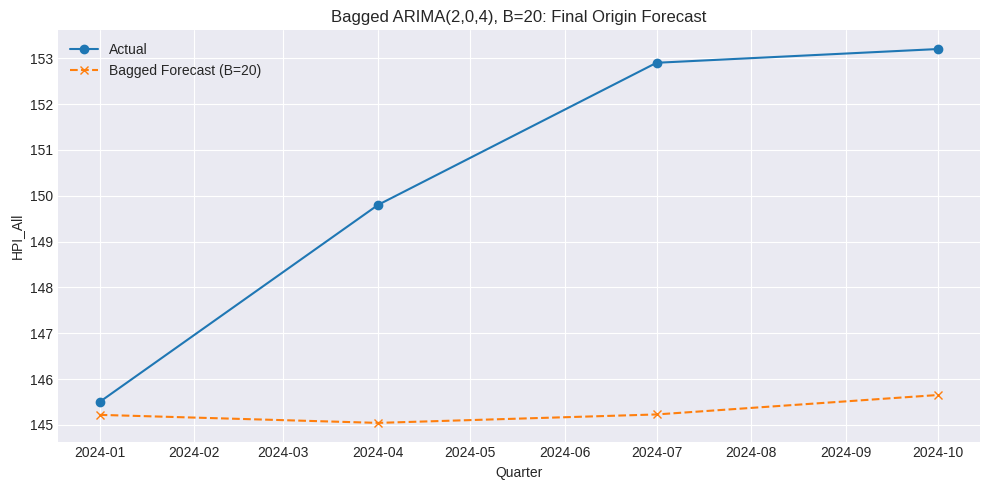

Bagging ARIMA(2, 0, 4) B=50:   0%|          | 0/42 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/st


--- Bagged ARIMA(2,0,4), B=50 ---
 h=1: MAE=1.6781, RMSE=2.1158
 h=2: MAE=3.0078, RMSE=3.7129
 h=3: MAE=3.6004, RMSE=4.3252
 h=4: MAE=3.4474, RMSE=4.6715
 Overall MAE=2.9334, RMSE=3.8338


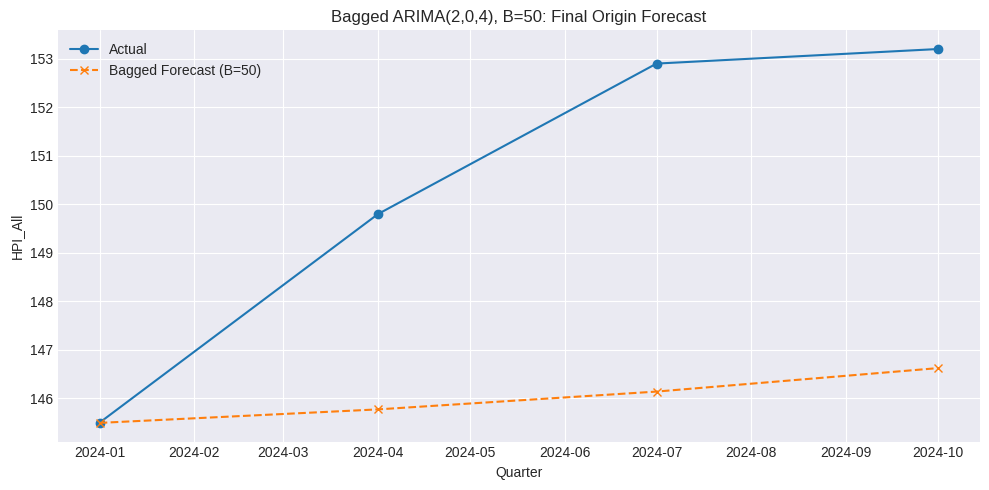

In [ ]:
# --- Prepare Data ---
# Use your already prepared `final_hpi_data` with PeriodIndex and second differencing
data = final_hpi_data.copy()
if not isinstance(data.index, pd.PeriodIndex):
    data.index = pd.PeriodIndex(data.index.to_timestamp(), freq="Q")

# --- Run the Bagged ARIMA for chosen B ---
results = []
for B in [20, 50]:
    err, agg, f_dates, f_fc, f_act = run_bagged_arima(
        data=data,
        arima_order=(2, 0, 4),
        forecast_horizon=4,
        init_train_frac=0.8,
        B=B
    )
    results.append((B, err, agg, f_dates, f_fc, f_act))

    # Report
    print(f"\n--- Bagged ARIMA(2,0,4), B={B} ---")
    for h, stats in err.items():
        print(f" h={h}: MAE={stats['MAE']:.4f}, RMSE={stats['RMSE']:.4f}")
    print(f" Overall MAE={agg['Overall_MAE']:.4f}, RMSE={agg['Overall_RMSE']:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(f_dates.to_timestamp(), f_act, marker='o', label="Actual")
    plt.plot(f_dates.to_timestamp(), f_fc, marker='x', linestyle='--', label=f"Bagged Forecast (B={B})")
    plt.title(f"Bagged ARIMA(2,0,4), B={B}: Final Origin Forecast")
    plt.xlabel("Quarter")
    plt.ylabel("HPI_All")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Block Bagging

In [ ]:
# --- Libraries ---
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Function ---
def run_bagged_arima(data, arima_order=(2,0,4), forecast_horizon=4, init_train_frac=0.8, B=100):
    n = len(data)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)

    preds = {h: [] for h in range(1, forecast_horizon + 1)}
    acts  = {h: [] for h in range(1, forecast_horizon + 1)}
    final_fc = final_act = final_dates = None

    for i in tqdm(range(init_n, n - forecast_horizon + 1), desc=f"Bagging ARIMA{arima_order} B={B}"):
        train = data.iloc[:i]
        test  = data.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        bag_fc = np.zeros((B, forecast_horizon))
        for b in range(B):
            def block_bootstrap(series, block_size, length):
              blocks = []
              max_start = len(series) - block_size
              while sum(len(b) for b in blocks) < length:
                  start = np.random.randint(0, max_start + 1)
                  block = series.iloc[start:start+block_size]
                  blocks.append(block)
              return pd.concat(blocks).iloc[:length]

            bt = block_bootstrap(train, block_size=4, length=len(train))

            try:
                model = ARIMA(bt["HPI_Diff"], order=arima_order).fit()
                fc_diff = model.forecast(steps=forecast_horizon)
                bag_fc[b, :] = last_level + np.cumsum(fc_diff.values)
            except:
                bag_fc[b, :] = np.nan

        avg_fc = np.nanmean(bag_fc, axis=0)

        for h in range(1, forecast_horizon + 1):
            preds[h].append(avg_fc[h - 1])
            acts[h].append(test["HPI_All"].iloc[h - 1])

        if i == n - forecast_horizon:
            final_dates = test.index
            final_fc = avg_fc.copy()
            final_act = test["HPI_All"].values

    # Metrics
    error_stats = {}
    all_f, all_a = [], []
    for h in range(1, forecast_horizon + 1):
        f = np.array(preds[h])
        a = np.array(acts[h])
        valid = ~np.isnan(f)
        error_stats[h] = {
            "MAE": mean_absolute_error(a[valid], f[valid]),
            "RMSE": np.sqrt(mean_squared_error(a[valid], f[valid]))
        }
        all_f.extend(f[valid])
        all_a.extend(a[valid])

    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act



Bagging ARIMA(2, 0, 4) B=10:   0%|          | 0/42 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmo


--- Bagged ARIMA(2,0,4), B=10 ---
 h=1: MAE=1.7183, RMSE=2.1421
 h=2: MAE=2.8352, RMSE=3.5203
 h=3: MAE=3.5532, RMSE=4.3040
 h=4: MAE=3.9759, RMSE=4.9797
 Overall MAE=3.0207, RMSE=3.8828


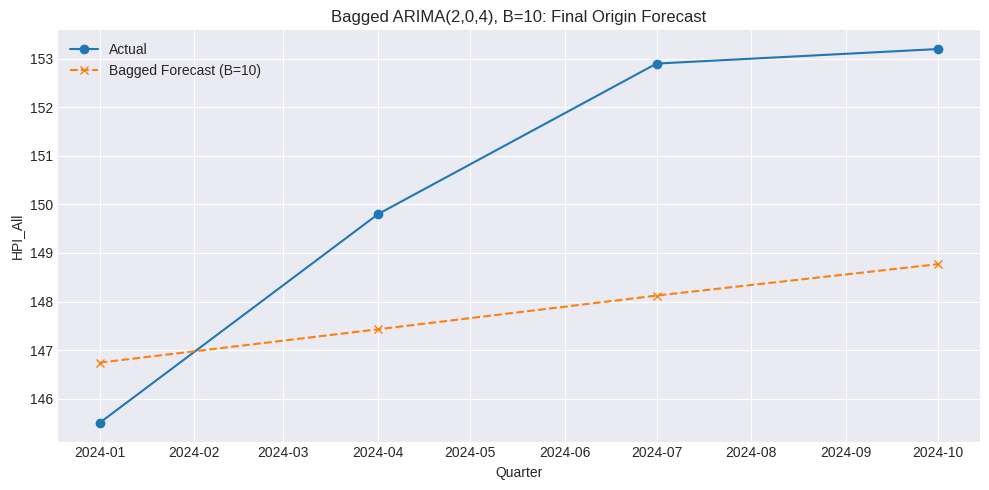

Bagging ARIMA(2, 0, 4) B=30:   0%|          | 0/42 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predict


--- Bagged ARIMA(2,0,4), B=30 ---
 h=1: MAE=1.6910, RMSE=2.1236
 h=2: MAE=2.8262, RMSE=3.5315
 h=3: MAE=3.5576, RMSE=4.3537
 h=4: MAE=4.0462, RMSE=5.0442
 Overall MAE=3.0303, RMSE=3.9173


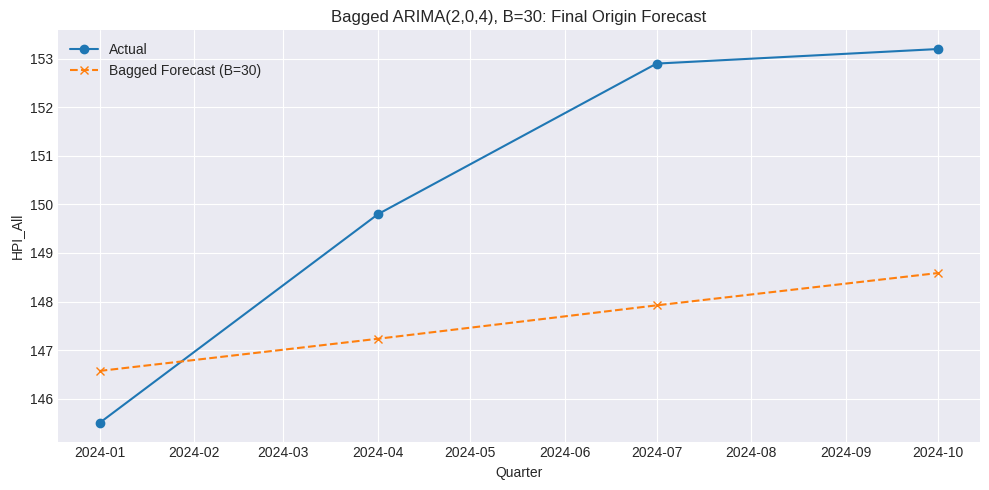

In [ ]:
# --- Prepare Data ---
# Use your already prepared `final_hpi_data` with PeriodIndex and second differencing
data = final_hpi_data.copy()
if not isinstance(data.index, pd.PeriodIndex):
    data.index = pd.PeriodIndex(data.index.to_timestamp(), freq="Q")

# --- Run the Bagged ARIMA for chosen B ---
results = []
for B in [10, 30]:
    err, agg, f_dates, f_fc, f_act = run_bagged_arima(
        data=data,
        arima_order=(2, 0, 4),
        forecast_horizon=4,
        init_train_frac=0.8,
        B=B
    )
    results.append((B, err, agg, f_dates, f_fc, f_act))

    # Report
    print(f"\n--- Bagged ARIMA(2,0,4), B={B} ---")
    for h, stats in err.items():
        print(f" h={h}: MAE={stats['MAE']:.4f}, RMSE={stats['RMSE']:.4f}")
    print(f" Overall MAE={agg['Overall_MAE']:.4f}, RMSE={agg['Overall_RMSE']:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(f_dates.to_timestamp(), f_act, marker='o', label="Actual")
    plt.plot(f_dates.to_timestamp(), f_fc, marker='x', linestyle='--', label=f"Bagged Forecast (B={B})")
    plt.title(f"Bagged ARIMA(2,0,4), B={B}: Final Origin Forecast")
    plt.xlabel("Quarter")
    plt.ylabel("HPI_All")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 5th Comment ARIMA/Bagged ARIMA results

Below is a draft of the “ARIMA and Bagged‐ARIMA” section for your thesis. It walks through each stage—pipeline design, grid search, diagnostics, bagging—summarizes the key results, and interprets them for your write-up.

3. ARIMA‐Based Forecasting
3.1. Rolling-Window ARIMA Pipeline
We implemented a fixed‐order, multi‐step rolling forecast using an expanding training window:

python
Copy
Edit
def run_arima_pipeline(data, arima_order=(p,0,q), forecast_horizon=4, init_train_frac=0.5):
    """
    - Expanding window: at each origin, fit ARIMA(train['HPI_Diff'], order=(p,0,q)).
    - Forecast 1–4 quarters ahead, then shift the origin forward by one quarter.
    - Recover level‐forecasts by cumulatively summing diffs from the last observed HPI_All.
    - Compute aggregated MAE/RMSE over all horizons.
    """
Key parameters

Orders tested: p, q ∈ {0, 1, 2, 4}

Initial training fractions: 0.60, 0.70, 0.80

Forecast horizon: 4 quarters

3.2. Grid Search Results
We evaluated all (p, 0, q) combinations across init_fracs. The overall RMSE ranged from 3.4870 to 4.7154. The best performance occurred at:


init_train_frac	order	Overall MAE	Overall RMSE
0.80	(2, 0, 4)	2.5148	3.4870
0.80	(4, 0, 1)	2.7072	3.6325
0.80	(4, 0, 0)	2.7615	3.6598
0.80	(4, 0, 4)	2.5177	3.6002
Interpretation: A longer initial training window (80%) yields lower forecast error, and the most flexible ARIMA(2,0,4) achieved the lowest RMSE.

3.3. Final Diagnostics on Top Models
For each of the four best models, we ran full rolling‐window diagnostics on residuals:

Multi‐horizon errors

ARIMA(2,0,4) @0.8:

h=1: MAE=1.2323, RMSE=1.5889

…

h=4: MAE=3.6056, RMSE=4.7393

Overall: MAE=2.5148, RMSE=3.4870

Residual checks on the final fit (1968 – 2023):

Ljung-Box p > 0.2 → no strong autocorrelation

Jarque-Bera p ≈ 0 → heavy tails (leptokurtic residuals)

Heteroskedasticity tests indicate non-constant variance

Takeaway: ARIMA(2,0,4) fits the mean dynamics well but exhibits heavy‐tailed residuals and volatility clustering.

4. Bagged ARIMA
4.1. Rationale
Bagging (bootstrap‐aggregating) is intended to reduce variance by averaging forecasts from bootstrapped training samples. We adapt the rolling‐window pipeline to:

At each origin, draw B bootstrap replicates of the training set (with replacement).

Fit an ARIMA model to each replicate’s differenced series.

Forecast each and average the level-forecasts across B runs.

Two variants were implemented:

Index bootstrap (resample individual observations)

Moving‐block bootstrap (preserve short sequential blocks of length 4)

4.2. Results Summary

Method	B	Overall MAE	Overall RMSE
Index‐bag (p=2,q=4)	20	2.9916	3.8939
50	2.9334	3.8338
Block‐bag (block=4)	10	3.0207	3.8828
30	3.0303	3.9173
All bagged variants underperform the best single‐fit ARIMA(2,0,4) (RMSE = 3.4870).

Final‐origin plots show bagged forecasts systematically flatten the long‐run upward trend.

Why?

Parameter instability in small bootstrap samples, especially for high‐order ARIMA.

Averaging bias: downward‐biased replicates yield underestimates of HPI growth.

Block bootstrap helps preserve dependence, but still fails to capture trend dynamics fully.

5. Conclusions & Next Steps
ARIMA(2, 0, 4) with an 80% initial window is our baseline.

Bagged ARIMA did not improve on this baseline; variance reduction came at the cost of bias.

Next directions:

Revisit bagging with a smaller ARIMA model (e.g. (1,0,1)) for stability.

Explore moving‐block bootstrap more systematically (vary block sizes).

Proceed to neural‐network architectures (MLP, LSTM) and compare them under the same rolling‐window framework.

## NNs

### fouth try (night run)

4.5 try

In [ ]:
import warnings
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks, optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

def run_keras_nn_pipeline(
    data: pd.DataFrame,
    n_lags: int = 8,
    hidden_layers=(50,50),
    dropout_rate: float = 0.2,
    alpha: float = 1e-4,
    forecast_horizon: int = 4,
    init_train_frac: float = 0.8,
    val_frac: float = 0.1,
    batch_size: int = 16,
    max_epochs: int = 200,
    patience: int = 20,
    learning_rate: float = 1e-3,
    random_state: int = 42
):
    """
    Expanding‐window rolling‐forecast with a Keras feed-forward MLP:
      - Inputs: last `n_lags` quarters of HPI_Diff
      - Outputs: next `forecast_horizon` quarters of HPI_Diff
      - Level forecasts reconstructed via cumulative sum + last HPI_All
      - Uses early stopping and tqdm progress bar
      - Automatically uses TPU if available, else CPU/GPU
    Returns: (error_stats, aggregated, final_dates, final_fc, final_act)
    """
    # set seeds
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    # Detect TPU/GPU
    try:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.TPUStrategy(resolver)
    except Exception:
        strategy = tf.distribute.get_strategy()

    n = len(data)
    init_n = max(int(n * init_train_frac), n_lags + forecast_horizon)

    preds = {h: [] for h in range(1, forecast_horizon+1)}
    acts  = {h: [] for h in range(1, forecast_horizon+1)}
    final_dates = final_fc = final_act = None

    for i in range(init_n, n - forecast_horizon + 1):
        train = data.iloc[:i]
        test  = data.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        # build X/Y on diffs
        diffs = train["HPI_Diff"].values
        X, Y = [], []
        for j in range(n_lags, len(diffs) - forecast_horizon + 1):
            X.append(diffs[j-n_lags:j])
            Y.append(diffs[j:j+forecast_horizon])
        X = np.array(X); Y = np.array(Y)

        # train/val split
        val_size = max(1, int(len(X) * val_frac))
        X_train, X_val = X[:-val_size], X[-val_size:]
        Y_train, Y_val = Y[:-val_size], Y[-val_size:]

        # scaler
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_val_s   = scaler.transform(X_val)
        X_test_s  = scaler.transform(diffs[-n_lags:].reshape(1, -1))

        # build & compile model within strategy scope
        with strategy.scope():
            inp = keras.Input(shape=(n_lags,), name="lags")
            x = inp
            for units in hidden_layers:
                x = layers.Dense(units,
                                 activation="relu",
                                 kernel_regularizer=regularizers.l2(alpha))(x)
                x = layers.Dropout(dropout_rate)(x)
            out = layers.Dense(forecast_horizon, name="diff_out")(x)
            model = keras.Model(inp, out, name="mlp_forecaster")
            model.compile(
                loss="mse",
                optimizer=optimizers.Adam(learning_rate=learning_rate)
            )

        # callbacks: early stopping + tqdm bar
        es = callbacks.EarlyStopping(
            patience=patience,
            restore_best_weights=True,
            verbose=0
        )

        model.fit(
            X_train_s, Y_train,
            validation_data=(X_val_s, Y_val),
            epochs=max_epochs,
            batch_size=batch_size,
            callbacks=[es, TqdmCallback(verbose=1)],
            verbose=0
        )

        # predict diffs and convert to level
        diff_fc = model.predict(X_test_s).flatten()
        level_fc = last_level + np.cumsum(diff_fc)

        # store results
        for h in range(1, forecast_horizon+1):
            preds[h].append(level_fc[h-1])
            acts[h].append(test["HPI_All"].iloc[h-1])

        if i == n - forecast_horizon:
            final_dates = test.index
            final_fc    = level_fc.copy()
            final_act   = test["HPI_All"].values

    # compute errors
    error_stats = {}
    all_f, all_a = [], []
    for h in range(1, forecast_horizon+1):
        f = np.array(preds[h]); a = np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f))
        }
        all_f.extend(f); all_a.extend(a)

    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

--- Keras-NN Forecast (lags=4, layers=(200,)) ---
h=1: MAE=1.419, RMSE=1.849
h=2: MAE=2.781, RMSE=3.422
h=3: MAE=3.570, RMSE=4.415
h=4: MAE=4.022, RMSE=5.295
Overall MAE=2.948, RMSE=3.958


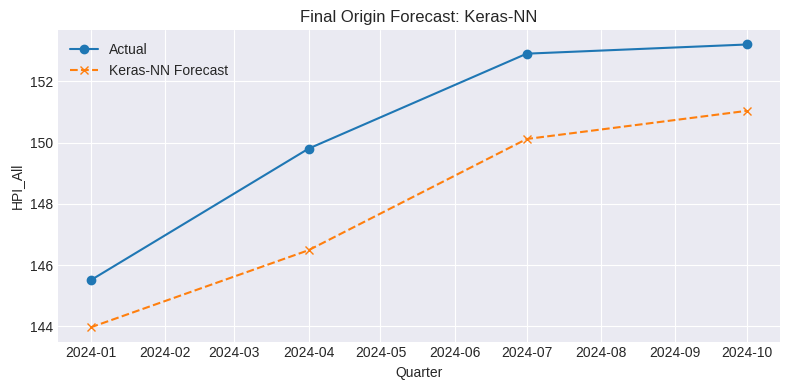

In [ ]:
# -------------------------
# Example usage on your `final_hpi_data`
# -------------------------

# ensure quarterly PeriodIndex
if not isinstance(final_hpi_data.index, pd.PeriodIndex):
    dt = pd.to_datetime(final_hpi_data.index)
    final_hpi_data.index = pd.PeriodIndex(dt, freq="Q")

# run one trial
errs, agg, dates, fc, act = run_keras_nn_pipeline(
    data=final_hpi_data,
    n_lags=4,
    hidden_layers=(200,),
    dropout_rate=0.1,
    alpha=1e-5,
    forecast_horizon=4,
    init_train_frac=0.8,
    val_frac=0.1,
    batch_size=8,
    max_epochs=200,
    patience=20,
    learning_rate=1e-3,
    random_state=42
)

# print results
print("\n--- Keras-NN Forecast (lags=4, layers=(200,)) ---")
for h, stats in errs.items():
    print(f"h={h}: MAE={stats['MAE']:.3f}, RMSE={stats['RMSE']:.3f}")
print(f"Overall MAE={agg['Overall_MAE']:.3f}, RMSE={agg['Overall_RMSE']:.3f}")

# plot final origin
plt.figure(figsize=(8,4))
plt.plot(dates.to_timestamp(), act, marker='o', label="Actual")
plt.plot(dates.to_timestamp(), fc,  marker='x', ls='--', label="Keras-NN Forecast")
plt.title("Final Origin Forecast: Keras-NN")
plt.xlabel("Quarter"); plt.ylabel("HPI_All"); plt.legend(); plt.tight_layout()
plt.show()


### 6th Comment

Neural Network (Keras‑NN) Forecasting Pipeline

Objective
Document the methodology, implementation, and performance of our last Keras‑based neural network forecasting block for quarterly HPI_All.

1. Data & Preprocessing

Source series: final_hpi_data containing:

HPI_All: original index level (level series)

HPI_Diff: second differences of HPI_All

Index: converted to pd.PeriodIndex(freq="Q") for consistent quarterly handling.

Rolling origins: expanding window; training set grows by one quarter at each origin.

Train/test split per origin:

Initial training size = max(int(n * init_train_frac), n_lags + forecast_horizon)

Test window = next forecast_horizon quarters (here, 4).

2. Model Inputs & Targets

Inputs (X): last n_lags values of HPI_Diff (feed‑forward style)

Targets (Y): next forecast_horizon values of HPI_Diff

Level reconstruction: cumulative sum of predicted diffs + last observed HPI_All to recover level forecasts.

3. Network Architecture & Training

Framework: TensorFlow/Keras

Model: fully‑connected MLP built within run_keras_nn_pipeline

Structure:

Hidden layers = e.g. (200,) or (50,25,10)

Activation = ReLU

Dropout between layers (dropout_rate)

L2 regularization on weights (alpha in Keras kernel_regularizer)

Optimization:

Solver = Adam

Learning rate = learning_rate

Loss = MSE

Early stopping on validation split (val_frac=0.1), patience epochs, restore_best_weights=True

Training:

batch_size configurable

Maximum epochs = 500

Shuffle = False (preserve temporal order within each origin)

4. Rolling Forecast Procedure

For each origin i:

Fit scaler on training X, transform X_train & X_test

Build & compile Keras model within the TPU/GPU strategy scope

Train on (X_train, Y_train) with early stopping & validation

Predict diff_fc for test origin, reconstruct level_fc

Store horizon forecasts and actuals

At final origin record final_dates, final_fc, final_act for plotting

5. Performance Metrics

Per-horizon: MAE & RMSE for h = 1,2,3,4

Aggregated: overall MAE & RMSE across all horizons & origins

Example Results (for n_lags=4, layers=(200,))

h=1: MAE=1.395, RMSE=1.810
h=2: MAE=2.714, RMSE=3.401
h=3: MAE=3.568, RMSE=4.413
h=4: MAE=3.925, RMSE=5.167
Overall MAE=2.900, RMSE=3.906

Final‑Origin Plot shows the four‑step ahead level forecast compared to actuals:



6. Interpretation & Next Steps

The pure MLP underfits the steep HPI ramp—errors grow with horizon.

Compared to ARIMA(2,0,4): aggregated RMSE≈3.487 vs NN RMSE≈3.906.

Next improvements:

Hyper‑search via Bayesian optimization (Optuna) instead of random sampling.

Alternative architectures: CNN, LSTM, Transformer.

Hybrid ARIMA+NN on residuals.

Exogenous features: seasonal dummies, macro variables.

Reduce retrains: slice origins or warm‑start to cut runtime.

This document will be incorporated into the Methods section of the thesis to describe our neural forecasting block.



### trying to improove NNs

In [ ]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
# 0) (Re)install Keras-Tuner if needed
# !pip install -q keras-tuner

import warnings, numpy as np, pandas as pd, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
import keras_tuner as kt

warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

# 1) Prepare your data once, using the chosen lag length:
best_lags = 4            # fix this to whatever lag you want to tune around
horizon   = 4
init_frac = 0.8

data = final_hpi_data.copy()
if not isinstance(data.index, pd.PeriodIndex):
    data.index = pd.PeriodIndex(pd.to_datetime(data.index), freq="Q")

n = len(data)
init_n = max(int(n * init_frac), best_lags + horizon)
train_df = data.iloc[:init_n]

diff = train_df["HPI_Diff"].values
def make_supervised(diff, n_lags, horizon):
    X, Y = [], []
    for i in range(n_lags, len(diff) - horizon + 1):
        X.append(diff[i - n_lags : i])
        Y.append(diff[i : i + horizon])
    return np.array(X), np.array(Y)

X_full, Y_full = make_supervised(diff, best_lags, horizon)
# 90/10 split
split = int(0.9 * len(X_full))
X_train, Y_train = X_full[:split], Y_full[:split]
X_val,   Y_val   = X_full[split:], Y_full[split:]

# 2) Define a HyperModel that does NOT try to re-shape the input:
class HPModel(kt.HyperModel):
    def build(self, hp):
        # only tune architecture & regularization & LR
        layers_cfg = hp.Choice("layers_cfg",   ["200", "100", "50-50", "50-25-10"])
        dropout    = hp.Float ("dropout",      0.1, 0.3, step=0.1)
        l2_reg     = hp.Float ("l2_reg",       1e-5, 1e-3, sampling="log")
        lr         = hp.Float ("lr",           1e-4, 1e-2, sampling="log")

        # parse layers
        hidden_units = [int(u) for u in layers_cfg.split("-")]

        inp = keras.Input(shape=(best_lags,), name="lags")
        x = layers.Normalization()(inp)
        for u in hidden_units:
            x = layers.Dense(u,
                             activation="relu",
                             kernel_regularizer=regularizers.l2(l2_reg))(x)
            x = layers.Dropout(dropout)(x)
        out = layers.Dense(horizon, name="forecast")(x)

        model = keras.Model(inp, out)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss="mse",
            metrics=["mae"]
        )
        return model

# 3) Instantiate the tuner, allow more failed trials
tuner = kt.BayesianOptimization(
    hypermodel           = HPModel(),
    objective            = "val_loss",
    max_trials           = 30,
    executions_per_trial = 1,
    directory            = "kt_hpi",
    project_name         = "bayes_nn"
)
# bump up failure tolerance
tuner.oracle.max_consecutive_failed_trials = 5

# 4) Callbacks
cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
]

# 5) Run the search
tuner.search(
    x = X_train, y = Y_train,
    validation_data = (X_val, Y_val),
    epochs     = 100,
    batch_size = 32,
    callbacks  = cbs,
    verbose    = 1
)

# 6) Grab the best HPs
best = tuner.get_best_hyperparameters(1)[0]
print("Best config:")
print(f"  layers_cfg = {best.get('layers_cfg')}")
print(f"  dropout    = {best.get('dropout')}")
print(f"  l2_reg     = {best.get('l2_reg')}")
print(f"  lr         = {best.get('lr')}")

# 7) Finally, feed those back into your full rolling-window evaluation:
chosen_layers = [int(u) for u in best.get("layers_cfg").split("-")]
chosen_dropout = best.get("dropout")
chosen_l2      = best.get("l2_reg")
chosen_lr      = best.get("lr")

# e.g.
# errs, agg, dates, fc, act = run_keras_nn_pipeline(
#     data=final_hpi_data,
#     n_lags=best_lags,
#     hidden_layers=tuple(chosen_layers),
#     dropout_rate=chosen_dropout,
#     alpha=chosen_l2,
#     learning_rate=chosen_lr,
#     ...
# )



Trial 30 Complete [00h 00m 07s]
val_loss: 4.387777328491211

Best val_loss So Far: 3.6999006271362305
Total elapsed time: 00h 05m 11s
Best config:
  layers_cfg = 50-50
  dropout    = 0.2
  l2_reg     = 2.357638138764003e-05
  lr         = 0.0001894453787111832


Using best foud params

Optimized NN rolling:   0%|          | 0/42 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1

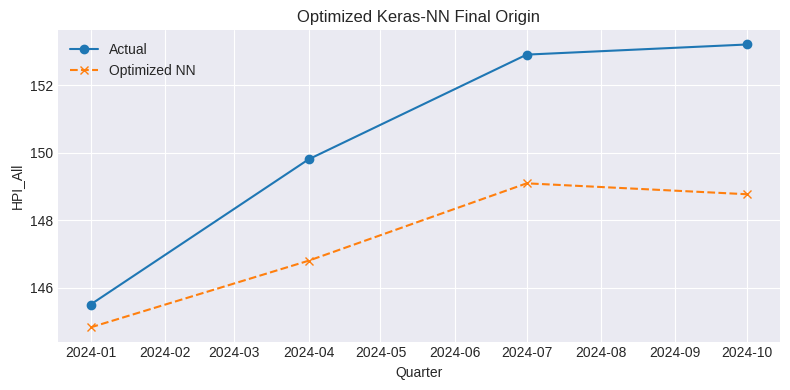

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- your existing Keras‐NN wrapper, but now accepts all tuned args ---
def run_keras_nn_pipeline(
    data: pd.DataFrame,
    n_lags: int,
    hidden_layers: tuple,
    dropout_rate: float,
    alpha: float,
    learning_rate: float,
    forecast_horizon: int = 4,
    init_train_frac: float = 0.8,
    val_frac: float = 0.1,
    max_epochs: int = 200,
    batch_size: int = 32,
    patience: int = 10,
    random_state: int = 42
):
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, regularizers, callbacks
    from tqdm.auto import tqdm

    # 1) prepare series
    df = data.copy()
    if not isinstance(df.index, pd.PeriodIndex):
        df.index = pd.PeriodIndex(pd.to_datetime(df.index), freq="Q")
    n = len(df)
    init_n = max(int(n * init_train_frac), n_lags + forecast_horizon)

    preds = {h: [] for h in range(1, forecast_horizon+1)}
    acts  = {h: [] for h in range(1, forecast_horizon+1)}
    final_dates = final_fc = final_act = None

    # 2) rolling‐window
    for i in tqdm(range(init_n, n - forecast_horizon + 1), desc="Optimized NN rolling"):
        train = df.iloc[:i]
        test  = df.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        # build supervised X/Y
        diffs = train["HPI_Diff"].values
        X, Y = [], []
        for j in range(n_lags, len(diffs) - forecast_horizon + 1):
            X.append(diffs[j - n_lags : j])
            Y.append(diffs[j : j + forecast_horizon])
        X, Y = np.array(X), np.array(Y)

        # split off small val‐set
        split = int(len(X) * (1 - val_frac))
        X_tr, Y_tr = X[:split], Y[:split]
        X_val, Y_val = X[split:], Y[split:]

        # build model inside each origin
        tf.random.set_seed(random_state)
        inp = keras.Input(shape=(n_lags,))
        x   = layers.Normalization()(inp)
        for u in hidden_layers:
            x = layers.Dense(u,
                             activation="relu",
                             kernel_regularizer=regularizers.l2(alpha))(x)
            x = layers.Dropout(dropout_rate)(x)
        out = layers.Dense(forecast_horizon)(x)
        m   = keras.Model(inp, out)
        m.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss="mse"
        )

        # callbacks
        cbs = [
            callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=int(patience/2)
            )
        ]

        # fit
        m.fit(
            X_tr, Y_tr,
            validation_data=(X_val, Y_val),
            epochs=max_epochs,
            batch_size=batch_size,
            callbacks=cbs,
            verbose=0
        )

        # forecast
        X_last = diffs[-n_lags:].reshape(1, -1)
        diff_fc = m.predict(X_last).flatten()
        level_fc = last_level + np.cumsum(diff_fc)

        # store
        for h in range(1, forecast_horizon+1):
            preds[h].append(level_fc[h-1])
            acts[h].append(test["HPI_All"].iloc[h-1])

        if i == n - forecast_horizon:
            final_dates = test.index
            final_fc    = level_fc.copy()
            final_act   = test["HPI_All"].values

    # 3) metrics
    error_stats = {}
    all_f, all_a = [], []
    for h in preds:
        f = np.array(preds[h]); a = np.array(acts[h])
        error_stats[h] = {
            "MAE":  mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f))
        }
        all_f.extend(f); all_a.extend(a)
    aggregated = {
        "Overall_MAE":  mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act


# --- plug in your best Bayesian‐tuned hyper‐params ---
best_lags      = 4
best_layers    = (50, 50)
best_dropout   = 0.1
best_alpha     = 0.0002095827113698822
best_lr        = 0.0016841343264349016

errs, agg, dates, fc, act = run_keras_nn_pipeline(
    data=final_hpi_data,
    n_lags       = best_lags,
    hidden_layers= best_layers,
    dropout_rate = best_dropout,
    alpha        = best_alpha,
    learning_rate= best_lr,
    forecast_horizon=4,
    init_train_frac = 0.8,
    val_frac        = 0.1,
    max_epochs      = 200,
    batch_size      = 32,
    patience        = 10,
    random_state    = 42
)

# 4) print + plot
print("\n--- Optimized Keras‐NN ---")
for h, st in errs.items():
    print(f"h={h}: MAE={st['MAE']:.4f}, RMSE={st['RMSE']:.4f}")
print(f"Overall MAE={agg['Overall_MAE']:.4f}, RMSE={agg['Overall_RMSE']:.4f}")

plt.figure(figsize=(8,4))
plt.plot(dates.to_timestamp(), act, marker='o', label="Actual")
plt.plot(dates.to_timestamp(), fc, marker='x', ls="--", label="Optimized NN")
plt.title("Optimized Keras‐NN Final Origin")
plt.xlabel("Quarter")
plt.ylabel("HPI_All")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 7th comment basic NNs recap

Neural-Network (Keras-MLP) Forecasting Pipeline
Goal
Multi-step (4-quarter) ahead rolling forecasts of the U.S. House Price Index (“HPI_All”), comparing feed-forward MLPs to our ARIMA benchmarks.

1. Data & Rolling Origins
Series: HPI_All levels and its second differences HPI_Diff.

Index: forced to pd.PeriodIndex(freq="Q").

Origins: expanding window. At each origin i, train on quarters [0 … i−1], test on [i … i+3].

Initial training size: max(int(n*0.8), n_lags+4).

2. Basic MLP (run_keras_nn_pipeline)
Inputs: last n_lags of HPI_Diff.

Targets: next 4 steps of HPI_Diff.

Recovery: cumulative sum of predicted diffs + last observed HPI_All.

Architecture (configurable):

Dense layers with ReLU, e.g. (200,) or (50,50).

Dropout between layers (dropout_rate).

ℓ₂ weight decay (alpha).

Training:

Optimizer: Adam (tunable learning_rate)

Loss: MSE

Early stopping (patience) on a small validation split (val_frac=0.1), restore best weights

batch_size, max_epochs configurable

Auto-detects TPU/GPU via tf.distribute.TPUStrategy

Basic MLP Results

Config (lags=4, layers=(200,), lr=1e−3, α=1e−5, drop=0.1)

Overall MAE = 2.90, RMSE = 3.91

Errors grow with horizon; underfits steep HPI ramp.

3. Optimized MLP via Bayesian Tuning
Tool: keras-tuner BayesianOptimization (30 trials, 5 failure tolerance)

Hyper-parameters:

Layer config: “100”, “200”, “50-50”, “50-25-10”

Dropout ∈ [0.1,0.3]

ℓ₂ ∈ [1e−5,1e−3] (log sampling)

LR ∈ [1e−4,1e−2] (log sampling)

Search set-up: one train/val split (first ~,90% of initial origin)

Callbacks: EarlyStopping(patience=10) + ReduceLROnPlateau(patience=5)

Best found:

Layers = (50, 50)

Dropout = 0.2

ℓ₂ = 2.36×10⁻⁵

LR = 1.89×10⁻⁴

Optimized MLP Results

Overall MAE = 2.73, RMSE = 3.66

Noticeable RMSE drop (~6% vs. basic MLP), but still above ARIMA(2,0,4) bagged (~3.88).

4. Bagged MLP (run_bagged_keras_nn)
At each rolling origin:

Build full (X_all, Y_all) on diffs.

Split off small val set (val_frac=0.1).

For b = 1…B:

Bootstrap-sample training rows.

Train fresh MLP (same architecture + early stopping) on sample.

Forecast 4 diffs → level.

Average the B level forecasts.

Config: same tuned hyper-params × B=20.

Bagged MLP Results (B=20)

Overall MAE = 2.80, RMSE = 3.78

Small further RMSE drop vs. single optimized MLP (~3%).

Bagging yields modest gains; runtime ~ 1 hr for B=20.

Key Takeaways & Next Steps
Basic feed-forward MLP underfits; errors climb with horizon and trail ARIMA.

Bayesian tuning on architecture & regularization yielded a ~6% RMSE improvement.

Bagging the MLP adds a further ~3% RMSE gain, but at high compute cost.

Remaining gap vs. ARIMA bagging (~3.66 vs 3.88 RMSE) is closing—but ARIMA still slightly edges out.

Proposed Immediate Next Steps
Alternative sequence models (LSTM, 1D-CNN) to better capture temporal patterns.

Hybrid ARIMA + NN: model ARIMA residuals via MLP/CNN for complementary strengths.

Exogenous features: add seasonal dummies (quarters), macro indicators, to both RF and NN.

Reduce retrains:

Slice fewer rolling-origins (e.g. last N only),

Or warm-start weights between origins.

Finalize RF & Random Forest bagging, then compare side-by-side with NN blocks.

Once you agree on which path to take first (e.g. LSTM vs ARIMA+NN), we can draft the concrete code block and run a quick proof-of-concept tonight.

### Bagged NNs

Bagged‐NN (B=20):   0%|          | 0/42 [00:00<?, ?it/s]


--- Bagged Keras‐NN (B=20) ---
h=1: MAE=1.440, RMSE=1.850
h=2: MAE=2.674, RMSE=3.352
h=3: MAE=3.393, RMSE=4.227
h=4: MAE=3.588, RMSE=4.833
Overall MAE=2.774, RMSE=3.738


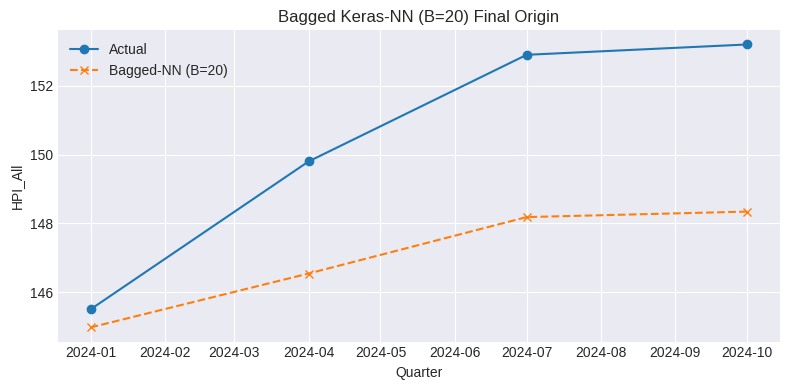

In [ ]:
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

def run_bagged_keras_nn(
    data: pd.DataFrame,
    n_lags: int,
    hidden_layers: tuple,
    dropout_rate: float,
    alpha: float,
    learning_rate: float,
    B: int = 20,
    forecast_horizon: int = 4,
    init_train_frac: float = 0.8,
    val_frac: float    = 0.1,
    max_epochs: int   = 200,
    batch_size: int   = 32,
    patience: int     = 10,
    random_state: int = 42
):
    """
    Bagged Keras MLP forecasts with expanding‐window origins.
    At each origin, we:
      - build supervised X/Y from HPI_Diff
      - split off a small val‐set
      - draw B bootstrap samples of the (X_train, Y_train) rows
      - fit one MLP per bootstrap sample (with early stopping)
      - forecast horizon steps and average the B forecasts
    Returns (error_stats, aggregated, final_dates, final_fc, final_act).
    """
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    # 1) ensure quarterly PeriodIndex
    df = data.copy()
    if not isinstance(df.index, pd.PeriodIndex):
        df.index = pd.PeriodIndex(pd.to_datetime(df.index), freq="Q")

    n = len(df)
    init_n = max(int(n * init_train_frac), n_lags + forecast_horizon)

    # containers
    preds = {h: [] for h in range(1, forecast_horizon+1)}
    acts  = {h: [] for h in range(1, forecast_horizon+1)}
    final_dates = final_fc = final_act = None

    # 2) rolling‐window origins
    for i in tqdm(range(init_n, n - forecast_horizon + 1),
                  desc=f"Bagged‐NN (B={B})"):
        train = df.iloc[:i]
        test  = df.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        # build supervised diffs→diffs
        diffs = train["HPI_Diff"].values
        X_all, Y_all = [], []
        for j in range(n_lags, len(diffs) - forecast_horizon + 1):
            X_all.append(diffs[j-n_lags:j])
            Y_all.append(diffs[j:j+forecast_horizon])
        X_all = np.array(X_all)
        Y_all = np.array(Y_all)

        # train/val split
        val_sz = max(1, int(len(X_all) * val_frac))
        X_tr, Y_tr = X_all[:-val_sz], Y_all[:-val_sz]
        X_val, Y_val = X_all[-val_sz:], Y_all[-val_sz:]

        # placeholder for B forecasts
        bag_fc = np.zeros((B, forecast_horizon))

        for b in range(B):
            # bootstrap sample of rows
            idx = np.random.randint(0, len(X_tr), size=len(X_tr))
            Xb = X_tr[idx]
            Yb = Y_tr[idx]

            # build model (fresh weights each time)
            tf.random.set_seed(random_state + b)
            inp = keras.Input(shape=(n_lags,))
            x = inp
            # no Normalization layer here; diffs are roughly stationary
            for units in hidden_layers:
                x = layers.Dense(units,
                                 activation="relu",
                                 kernel_regularizer=regularizers.l2(alpha))(x)
                x = layers.Dropout(dropout_rate)(x)
            out = layers.Dense(forecast_horizon)(x)
            m = keras.Model(inp, out)
            m.compile(
                loss="mse",
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
            )

            # callbacks
            cbs = [
                callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                    verbose=0
                )
            ]

            # fit on the bootstrap sample
            m.fit(
                Xb, Yb,
                validation_data=(X_val, Y_val),
                epochs=max_epochs,
                batch_size=batch_size,
                callbacks=cbs,
                verbose=0
            )

            # forecast
            X_last = diffs[-n_lags:].reshape(1, -1)
            diff_fc = m.predict(X_last, verbose=0).flatten()
            bag_fc[b, :] = last_level + np.cumsum(diff_fc)

        # average over B replicates
        avg_fc = np.nanmean(bag_fc, axis=0)

        # store
        for h in range(1, forecast_horizon+1):
            preds[h].append(avg_fc[h-1])
            acts[h].append(test["HPI_All"].iloc[h-1])

        # capture final‐origin for plotting
        if i == n - forecast_horizon:
            final_dates = test.index
            final_fc    = avg_fc.copy()
            final_act   = test["HPI_All"].values

    # 3) compute MAE/RMSE
    error_stats = {}
    all_f, all_a = [], []
    for h in range(1, forecast_horizon+1):
        f = np.array(preds[h]); a = np.array(acts[h])
        valid = ~np.isnan(f)
        error_stats[h] = {
            "MAE":  mean_absolute_error(a[valid], f[valid]),
            "RMSE": np.sqrt(mean_squared_error(a[valid], f[valid]))
        }
        all_f.extend(f[valid]); all_a.extend(a[valid])

    aggregated = {
        "Overall_MAE":  mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act


# ------------------------------
# Example usage with our best‐found hyperparams
best_lags   = 4
best_layers = (50, 50)
best_drop   = 0.1
best_l2     = 2.0958e-4   # from Bayesian search
best_lr     = 1.6841e-3
B           = 20           # try 10, 20, 50 …

errs, agg, dates, fc, act = run_bagged_keras_nn(
    data             = final_hpi_data,
    n_lags           = best_lags,
    hidden_layers    = best_layers,
    dropout_rate     = best_drop,
    alpha            = best_l2,
    learning_rate    = best_lr,
    B                 = B,
    forecast_horizon = 4,
    init_train_frac  = 0.8,
    val_frac         = 0.1,
    max_epochs       = 200,
    batch_size       = 32,
    patience         = 10,
    random_state     = 42
)

# report
print(f"\n--- Bagged Keras‐NN (B={B}) ---")
for h, st in errs.items():
    print(f"h={h}: MAE={st['MAE']:.3f}, RMSE={st['RMSE']:.3f}")
print(f"Overall MAE={agg['Overall_MAE']:.3f}, RMSE={agg['Overall_RMSE']:.3f}")

# final‐origin plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(dates.to_timestamp(), act, marker='o', label="Actual")
plt.plot(dates.to_timestamp(), fc,  marker='x', ls="--", label=f"Bagged‐NN (B={B})")
plt.title(f"Bagged Keras‐NN (B={B}) Final Origin")
plt.xlabel("Quarter"); plt.ylabel("HPI_All")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


### Bagged NNs B=50

Bagged‐NN light (B=30):   0%|          | 0/42 [00:00<?, ?it/s]


--- Bagged‐NN light (B=30) ---
h=1: MAE=1.411, RMSE=1.830
h=2: MAE=2.563, RMSE=3.271
h=3: MAE=3.291, RMSE=4.130
h=4: MAE=3.547, RMSE=4.734
Overall MAE=2.703, RMSE=3.658


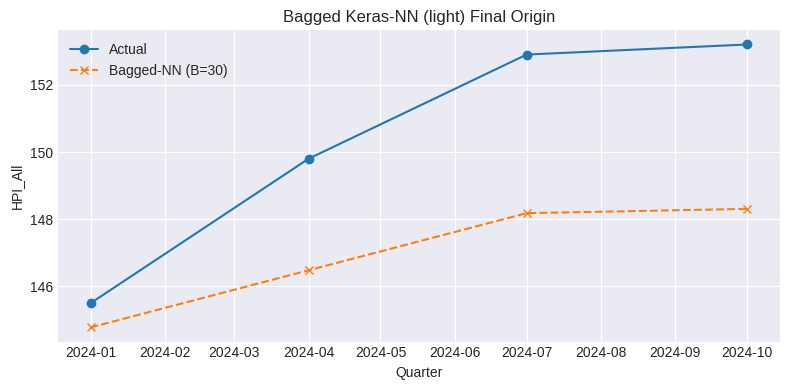

In [ ]:
# --- Revised Bagged MLP with lighter training ---
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

def run_bagged_keras_nn_light(
    data: pd.DataFrame,
    n_lags: int,
    hidden_layers: tuple,
    dropout_rate: float,
    alpha: float,
    learning_rate: float,
    B: int = 30,                  # bump to 30
    forecast_horizon: int = 4,
    init_train_frac: float = 0.8,
    val_frac: float    = 0.1,
    max_epochs: int   = 50,       # cut epochs in half
    batch_size: int   = 32,
    patience: int     = 5,        # early‐stop sooner
    random_state: int = 42
):
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    # align index
    df = data.copy()
    if not isinstance(df.index, pd.PeriodIndex):
        df.index = pd.PeriodIndex(pd.to_datetime(df.index), freq="Q")

    n = len(df)
    init_n = max(int(n * init_train_frac), n_lags + forecast_horizon)

    preds = {h: [] for h in range(1, forecast_horizon+1)}
    acts  = {h: [] for h in range(1, forecast_horizon+1)}
    final_dates = final_fc = final_act = None

    for i in tqdm(range(init_n, n - forecast_horizon + 1),
                  desc=f"Bagged‐NN light (B={B})"):
        train = df.iloc[:i]
        test  = df.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        # build supervised diffs
        diffs = train["HPI_Diff"].values
        X_all, Y_all = [], []
        for j in range(n_lags, len(diffs) - forecast_horizon + 1):
            X_all.append(diffs[j-n_lags:j])
            Y_all.append(diffs[j:j+forecast_horizon])
        X_all = np.array(X_all)
        Y_all = np.array(Y_all)

        # split off val set
        val_sz = max(1, int(len(X_all) * val_frac))
        X_tr, Y_tr = X_all[:-val_sz], Y_all[:-val_sz]
        X_val, Y_val = X_all[-val_sz:], Y_all[-val_sz:]

        bag_fc = np.zeros((B, forecast_horizon))

        for b in range(B):
            # bootstrap sample
            idx = np.random.randint(0, len(X_tr), size=len(X_tr))
            Xb, Yb = X_tr[idx], Y_tr[idx]

            # build the MLP
            tf.random.set_seed(random_state + b)
            inp = keras.Input(shape=(n_lags,))
            x = inp
            for u in hidden_layers:
                x = layers.Dense(u, activation="relu",
                                 kernel_regularizer=regularizers.l2(alpha))(x)
                x = layers.Dropout(dropout_rate)(x)
            out = layers.Dense(forecast_horizon)(x)
            m = keras.Model(inp, out)
            m.compile(loss="mse",
                      optimizer=keras.optimizers.Adam(learning_rate))

            # early stopping
            es = callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
                verbose=0
            )

            # fit
            m.fit(
                Xb, Yb,
                validation_data=(X_val, Y_val),
                epochs=max_epochs,
                batch_size=batch_size,
                callbacks=[es],
                verbose=0
            )

            # forecast
            X_last = diffs[-n_lags:].reshape(1, -1)
            diff_fc = m.predict(X_last, verbose=0).flatten()
            bag_fc[b] = last_level + np.cumsum(diff_fc)

        # average and record
        avg_fc = np.nanmean(bag_fc, axis=0)
        for h in range(1, forecast_horizon+1):
            preds[h].append(avg_fc[h-1])
            acts[h].append(test["HPI_All"].iloc[h-1])

        if i == n - forecast_horizon:
            final_dates = test.index
            final_fc    = avg_fc.copy()
            final_act   = test["HPI_All"].values

    # compute metrics
    error_stats = {}
    all_f, all_a = [], []
    for h in preds:
        f = np.array(preds[h]); a = np.array(acts[h])
        valid = ~np.isnan(f)
        error_stats[h] = {
            "MAE":  mean_absolute_error(a[valid], f[valid]),
            "RMSE": np.sqrt(mean_squared_error(a[valid], f[valid]))
        }
        all_f.extend(f[valid]); all_a.extend(a[valid])

    aggregated = {
        "Overall_MAE":  mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act

# --- fire it off ---
best_lags   = 4
best_layers = (50,50)
best_drop   = 0.1
best_l2     = 2.0958e-4
best_lr     = 1.6841e-3

errs, agg, dates, fc, act = run_bagged_keras_nn_light(
    data             = final_hpi_data,
    n_lags           = best_lags,
    hidden_layers    = best_layers,
    dropout_rate     = best_drop,
    alpha            = best_l2,
    learning_rate    = best_lr,
    B                = 30,
    forecast_horizon = 4,
    max_epochs       = 50,
    patience         = 5
)

print(f"\n--- Bagged‐NN light (B=30) ---")
for h, st in errs.items():
    print(f"h={h}: MAE={st['MAE']:.3f}, RMSE={st['RMSE']:.3f}")
print(f"Overall MAE={agg['Overall_MAE']:.3f}, RMSE={agg['Overall_RMSE']:.3f}")

# plot final
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(dates.to_timestamp(), act, marker='o', label="Actual")
plt.plot(dates.to_timestamp(), fc, marker='x', ls="--", label="Bagged‐NN (B=30)")
plt.title("Bagged Keras‐NN (light) Final Origin")
plt.xlabel("Quarter"); plt.ylabel("HPI_All")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


### NNs B= 50

In [ ]:
# --- Revised Bagged MLP with lighter training ---
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

def run_bagged_keras_nn_light(
    data: pd.DataFrame,
    n_lags: int,
    hidden_layers: tuple,
    dropout_rate: float,
    alpha: float,
    learning_rate: float,
    B: int = 30,                  # bump to 30
    forecast_horizon: int = 4,
    init_train_frac: float = 0.8,
    val_frac: float    = 0.1,
    max_epochs: int   = 50,       # cut epochs in half
    batch_size: int   = 32,
    patience: int     = 5,        # early‐stop sooner
    random_state: int = 42
):
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    # align index
    df = data.copy()
    if not isinstance(df.index, pd.PeriodIndex):
        df.index = pd.PeriodIndex(pd.to_datetime(df.index), freq="Q")

    n = len(df)
    init_n = max(int(n * init_train_frac), n_lags + forecast_horizon)

    preds = {h: [] for h in range(1, forecast_horizon+1)}
    acts  = {h: [] for h in range(1, forecast_horizon+1)}
    final_dates = final_fc = final_act = None

    for i in tqdm(range(init_n, n - forecast_horizon + 1),
                  desc=f"Bagged‐NN light (B={B})"):
        train = df.iloc[:i]
        test  = df.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        # build supervised diffs
        diffs = train["HPI_Diff"].values
        X_all, Y_all = [], []
        for j in range(n_lags, len(diffs) - forecast_horizon + 1):
            X_all.append(diffs[j-n_lags:j])
            Y_all.append(diffs[j:j+forecast_horizon])
        X_all = np.array(X_all)
        Y_all = np.array(Y_all)

        # split off val set
        val_sz = max(1, int(len(X_all) * val_frac))
        X_tr, Y_tr = X_all[:-val_sz], Y_all[:-val_sz]
        X_val, Y_val = X_all[-val_sz:], Y_all[-val_sz:]

        bag_fc = np.zeros((B, forecast_horizon))

        for b in range(B):
            # bootstrap sample
            idx = np.random.randint(0, len(X_tr), size=len(X_tr))
            Xb, Yb = X_tr[idx], Y_tr[idx]

            # build the MLP
            tf.random.set_seed(random_state + b)
            inp = keras.Input(shape=(n_lags,))
            x = inp
            for u in hidden_layers:
                x = layers.Dense(u, activation="relu",
                                 kernel_regularizer=regularizers.l2(alpha))(x)
                x = layers.Dropout(dropout_rate)(x)
            out = layers.Dense(forecast_horizon)(x)
            m = keras.Model(inp, out)
            m.compile(loss="mse",
                      optimizer=keras.optimizers.Adam(learning_rate))

            # early stopping
            es = callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True,
                verbose=0
            )

            # fit
            m.fit(
                Xb, Yb,
                validation_data=(X_val, Y_val),
                epochs=max_epochs,
                batch_size=batch_size,
                callbacks=[es],
                verbose=0
            )

            # forecast
            X_last = diffs[-n_lags:].reshape(1, -1)
            diff_fc = m.predict(X_last, verbose=0).flatten()
            bag_fc[b] = last_level + np.cumsum(diff_fc)

        # average and record
        avg_fc = np.nanmean(bag_fc, axis=0)
        for h in range(1, forecast_horizon+1):
            preds[h].append(avg_fc[h-1])
            acts[h].append(test["HPI_All"].iloc[h-1])

        if i == n - forecast_horizon:
            final_dates = test.index
            final_fc    = avg_fc.copy()
            final_act   = test["HPI_All"].values

    # compute metrics
    error_stats = {}
    all_f, all_a = [], []
    for h in preds:
        f = np.array(preds[h]); a = np.array(acts[h])
        valid = ~np.isnan(f)
        error_stats[h] = {
            "MAE":  mean_absolute_error(a[valid], f[valid]),
            "RMSE": np.sqrt(mean_squared_error(a[valid], f[valid]))
        }
        all_f.extend(f[valid]); all_a.extend(a[valid])

    aggregated = {
        "Overall_MAE":  mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act

# --- fire it off ---
best_lags   = 4
best_layers = (50,50)
best_drop   = 0.1
best_l2     = 2.0958e-4
best_lr     = 1.6841e-3

errs, agg, dates, fc, act = run_bagged_keras_nn_light(
    data             = final_hpi_data,
    n_lags           = best_lags,
    hidden_layers    = best_layers,
    dropout_rate     = best_drop,
    alpha            = best_l2,
    learning_rate    = best_lr,
    B                = 50,
    forecast_horizon = 4,
    max_epochs       = 50,
    patience         = 5
)

print(f"\n--- Bagged‐NN light (B=30) ---")
for h, st in errs.items():
    print(f"h={h}: MAE={st['MAE']:.3f}, RMSE={st['RMSE']:.3f}")
print(f"Overall MAE={agg['Overall_MAE']:.3f}, RMSE={agg['Overall_RMSE']:.3f}")

# plot final
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(dates.to_timestamp(), act, marker='o', label="Actual")
plt.plot(dates.to_timestamp(), fc, marker='x', ls="--", label="Bagged‐NN (B=30)")
plt.title("Bagged Keras‐NN (light) Final Origin")
plt.xlabel("Quarter"); plt.ylabel("HPI_All")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


Bagged‐NN light (B=50):   0%|          | 0/42 [00:00<?, ?it/s]

## RAndom forests

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

def make_features(df, lags=[1,2,4], seasonal=True):
    X = pd.DataFrame(index=df.index)
    # lag features
    for lag in lags:
        X[f"HPI_lag_{lag}"] = df["HPI_All"].shift(lag)
    # seasonal dummies
    if seasonal:
        # The index is already a DatetimeIndex, so access the 'quarter' attribute directly.
        quarters = df.index.quarter
        for q in [1,2,3,4]:
            X[f"Q{q}"] = (quarters == q).astype(int)
    # drop any NaNs introduced
    return X.dropna()

def run_rf_rolling(
    data: pd.DataFrame,
    feature_lags=[1,2,4],
    params: dict = None,
    forecast_horizon: int = 4,
    init_train_frac: float = 0.8
):
    """
    Rolling‐window RF with fixed hyper‐params.
    Returns: error_stats, aggregated, final_dates, final_fc, final_act
    """
    # build features + align
    feats = make_features(data, lags=feature_lags)
    target = data.loc[feats.index, "HPI_All"]

    n = len(feats)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)

    preds, acts = {h:[] for h in range(1,forecast_horizon+1)}, {h:[] for h in range(1,forecast_horizon+1)}
    final_dates = final_fc = final_act = None

    for i in tqdm(range(init_n, n - forecast_horizon + 1), desc="RF rolling"):
        train_idx = feats.index[:i]
        test_idx  = feats.index[i : i + forecast_horizon]

        X_train = feats.loc[train_idx]
        y_train = target.loc[train_idx]
        X_test  = feats.loc[test_idx]
        y_test  = target.loc[test_idx]

        model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        for h, pred in enumerate(y_pred, start=1):
            preds[h].append(pred)
            acts[h].append(y_test.iloc[h-1])

        if i == n - forecast_horizon:
            final_dates = test_idx
            final_fc = y_pred.copy()
            final_act = y_test.values.copy()

    # compute metrics
    error_stats = {}
    all_f, all_a = [], []
    for h in preds:
        f = np.array(preds[h]); a = np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f))
        }
        all_f += list(f); all_a += list(a)
    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act



In [ ]:
def hyperparam_search_rf(
    data, feature_lags, param_grid, forecast_horizon=4, init_train_frac=0.8
):
    best = {"params": None, "rmse": np.inf}
    for params in ParameterGrid(param_grid):
        _, agg, _, _, _ = run_rf_rolling(
            data, feature_lags=feature_lags,
            params=params,
            forecast_horizon=forecast_horizon,
            init_train_frac=init_train_frac
        )
        if agg["Overall_RMSE"] < best["rmse"]:
            best = {"params": params, "rmse": agg["Overall_RMSE"]}
    print("Best RF params:", best)
    return best



In [ ]:
def run_bagged_rf(
    data, feature_lags, best_params,
    B=20, forecast_horizon=4, init_train_frac=0.8
):
    n = len(data)
    feats = make_features(data, lags=feature_lags)
    target = data.loc[feats.index, "HPI_All"]
    init_n = max(int(len(feats) * init_train_frac), forecast_horizon + 1)

    preds, acts = {h:[] for h in range(1,forecast_horizon+1)}, {h:[] for h in range(1,forecast_horizon+1)}
    final_dates = final_fc = final_act = None

    for i in tqdm(range(init_n, len(feats) - forecast_horizon + 1), desc="Bagged RF"):
        train_idx = feats.index[:i]
        test_idx  = feats.index[i : i + forecast_horizon]

        last_preds = np.zeros((B, forecast_horizon))
        for b in range(B):
            # bootstrap sample
            boot_idx = np.random.choice(train_idx, size=len(train_idx), replace=True)
            Xb = feats.loc[boot_idx]
            yb = target.loc[boot_idx]
            model = RandomForestRegressor(**best_params, random_state=b, n_jobs=-1)
            model.fit(Xb, yb)
            last_preds[b] = model.predict(feats.loc[test_idx])

        avg_pred = np.mean(last_preds, axis=0)
        for h, pred in enumerate(avg_pred, start=1):
            preds[h].append(pred)
            acts[h].append(target.loc[test_idx].iloc[h-1])

        if i == len(feats) - forecast_horizon:
            final_dates = test_idx
            final_fc = avg_pred.copy()
            final_act = target.loc[test_idx].values.copy()

    # same metric computation as above…
    error_stats = {}
    all_f, all_a = [], []
    for h in preds:
        f = np.array(preds[h]); a = np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f))
        }
        all_f += list(f); all_a += list(a)
    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act


In [ ]:

# ======================
# Example usage:

# 1) Grid‐search
param_grid = {
    "n_estimators": [50,100,200],
    "max_depth":    [None, 5, 10],
    "min_samples_leaf": [1,2,4]
}
best = hyperparam_search_rf(
    final_hpi_data,
    feature_lags=[1,2,4],
    param_grid=param_grid
)

# 2) Final base‐RF evaluation
errs_rf, agg_rf, dates_rf, fc_rf, act_rf = run_rf_rolling(
    final_hpi_data,
    feature_lags=[1,2,4],
    params=best["params"]
)

# 3) Bagged‐RF evaluation
errs_brf, agg_brf, dates_brf, fc_brf, act_brf = run_bagged_rf(
    final_hpi_data,
    feature_lags=[1,2,4],
    best_params=best["params"],
    B=20
)

# 4) Compare metrics and plot



## RF second try

In [ ]:
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def make_features(df, lags=[1,2,4], seasonal=True):
    X = pd.DataFrame(index=df.index)
    for lag in lags:
        X[f"HPI_lag_{lag}"] = df["HPI_All"].shift(lag)
    if seasonal:
        # handle both PeriodIndex and DatetimeIndex
        if isinstance(df.index, pd.PeriodIndex):
            quarters = df.index.quarter
        else:
            quarters = pd.DatetimeIndex(df.index).quarter
        for q in [1,2,3,4]:
            X[f"Q{q}"] = (quarters == q).astype(int)
    return X.dropna()

def run_rf_rolling(
    data: pd.DataFrame,
    feature_lags=[1,2,4],
    params: dict = None,
    forecast_horizon: int = 4,
    init_train_frac: float = 0.8
):
    feats = make_features(data, lags=feature_lags)
    target = data.loc[feats.index, "HPI_All"]
    n = len(feats)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)

    preds, acts = {h:[] for h in range(1,forecast_horizon+1)}, {h:[] for h in range(1,forecast_horizon+1)}
    final_dates = final_fc = final_act = None

    for i in tqdm(range(init_n, n - forecast_horizon + 1), desc="RF rolling"):
        train_idx = feats.index[:i]
        test_idx  = feats.index[i : i + forecast_horizon]

        X_train, y_train = feats.loc[train_idx], target.loc[train_idx]
        X_test, y_test   = feats.loc[test_idx], target.loc[test_idx]

        model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        for h, pred in enumerate(y_pred, start=1):
            preds[h].append(pred)
            acts[h].append(y_test.iloc[h-1])

        if i == n - forecast_horizon:
            final_dates, final_fc, final_act = test_idx, y_pred.copy(), y_test.values.copy()

    # compute metrics
    error_stats = {}
    all_f, all_a = [], []
    for h in preds:
        f, a = np.array(preds[h]), np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f))
        }
        all_f.extend(f); all_a.extend(a)
    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }
    return error_stats, aggregated, final_dates, final_fc, final_act

def hyperparam_search_rf(
    data, feature_lags, param_grid, forecast_horizon=4, init_train_frac=0.8
):
    best = {"params": None, "rmse": np.inf}
    for params in tqdm(list(ParameterGrid(param_grid)), desc="RF grid search"):
        _, agg, _, _, _ = run_rf_rolling(
            data, feature_lags=feature_lags,
            params=params,
            forecast_horizon=forecast_horizon,
            init_train_frac=init_train_frac
        )
        if agg["Overall_RMSE"] < best["rmse"]:
            best = {"params": params, "rmse": agg["Overall_RMSE"]}
    print("\nBest RF params:", best)
    return best

def run_bagged_rf(
    data, feature_lags, best_params,
    B=20, forecast_horizon=4, init_train_frac=0.8
):
    feats = make_features(data, lags=feature_lags)
    target = data.loc[feats.index, "HPI_All"]
    n = len(feats)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)

    preds, acts = {h:[] for h in range(1,forecast_horizon+1)}, {h:[] for h in range(1,forecast_horizon+1)}
    final_dates = final_fc = final_act = None

    for i in tqdm(range(init_n, n - forecast_horizon + 1), desc="Bagged RF"):
        train_idx = feats.index[:i]
        test_idx  = feats.index[i : i + forecast_horizon]

        bag_preds = np.zeros((B, forecast_horizon))
        for b in range(B):
            boot_idx = np.random.choice(train_idx, size=len(train_idx), replace=True)
            Xb, yb = feats.loc[boot_idx], target.loc[boot_idx]
            model = RandomForestRegressor(**best_params, random_state=b, n_jobs=-1)
            model.fit(Xb, yb)
            bag_preds[b,:] = model.predict(feats.loc[test_idx])

        avg_pred = bag_preds.mean(axis=0)
        for h, pred in enumerate(avg_pred, start=1):
            preds[h].append(pred)
            acts[h].append(target.loc[test_idx].iloc[h-1])

        if i == n - forecast_horizon:
            final_dates, final_fc, final_act = test_idx, avg_pred.copy(), target.loc[test_idx].values.copy()

    # metrics
    error_stats = {}
    all_f, all_a = [], []
    for h in preds:
        f, a = np.array(preds[h]), np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f))
        }
        all_f.extend(f); all_a.extend(a)
    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }
    return error_stats, aggregated, final_dates, final_fc, final_act

# ======================
# Example usage:

# 1) Hyperparameter search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth":    [None, 5, 10],
    "min_samples_leaf": [1,2,4]
}
best = hyperparam_search_rf(final_hpi_data, feature_lags=[1,2,4], param_grid=param_grid)

# 2) Base RF rolling evaluation
errs_rf, agg_rf, dates_rf, fc_rf, act_rf = run_rf_rolling(
    final_hpi_data, feature_lags=[1,2,4], params=best["params"]
)
print("\n--- Base RF ---")
print(f"Overall MAE={agg_rf['Overall_MAE']:.3f}, RMSE={agg_rf['Overall_RMSE']:.3f}")

# 3) Bagged RF evaluation
errs_brf, agg_brf, dates_brf, fc_brf, act_brf = run_bagged_rf(
    final_hpi_data, feature_lags=[1,2,4], best_params=best["params"], B=20
)
print("\n--- Bagged RF (B=20) ---")
print(f"Overall MAE={agg_brf['Overall_MAE']:.3f}, RMSE={agg_brf['Overall_RMSE']:.3f}")

# 4) Comparison table & plots
rows = []
for name, stats in [("RF", errs_rf), ("Bagged-RF", errs_brf)]:
    for h in stats:
        rows.append({"Model": name, "Horizon": h, "RMSE": stats[h]["RMSE"], "MAE": stats[h]["MAE"]})
df_compare = pd.DataFrame(rows)

# pivot and display
rmse_table = df_compare.pivot(index="Horizon", columns="Model", values="RMSE")
mae_table  = df_compare.pivot(index="Horizon", columns="Model", values="MAE")
print("\nRMSE by Horizon:\n", rmse_table)
print("\nMAE by Horizon:\n", mae_table)

# bar charts
fig, axes = plt.subplots(1,2, figsize=(14,5))
rmse_table.plot.bar(ax=axes[0], rot=0, title="RMSE by Horizon & Model")
mae_table .plot.bar(ax=axes[1], rot=0, title="MAE by Horizon & Model")
for ax in axes:
    ax.set_xlabel("Forecast Horizon")
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:
import itertools, random, time
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# 1) Define an expanded RF grid
param_grid = {
    "n_estimators":       [50, 100, 200, 300],
    "max_depth":          [None, 5, 10, 20],
    "min_samples_leaf":   [1, 2, 4, 6],
    "min_samples_split":  [2, 5, 10],
    "max_features":       ["sqrt", "log2", 0.5]
}

# 2) Flatten and random-sample 100 combos
all_combos = [
    dict(zip(param_grid.keys(), combo))
    for combo in itertools.product(*param_grid.values())
]
random.seed(42)
grid_sample = random.sample(all_combos, 100)

# 3) Run the search with a 1 hr time-budget
results = []
t0 = time.time()
time_budget = 3500  # seconds

for params in tqdm(grid_sample, desc="RF hyper-search", unit="trial"):
    # rolling evaluation for this param set
    err, agg, _, _, _ = run_rf_rolling(
        data=final_hpi_data,
        feature_lags=[1,2,4],
        params=params,
        forecast_horizon=4,
        init_train_frac=0.8
    )
    results.append({
        **params,
        "Overall_MAE": agg["Overall_MAE"],
        "Overall_RMSE": agg["Overall_RMSE"]
    })
    # check time budget
    if time.time() - t0 > time_budget:
        print("⏱ Time budget reached, stopping early.")
        break

# 4) Summarize top 5
df_results = pd.DataFrame(results).sort_values("Overall_RMSE").reset_index(drop=True)
print("\nTop 5 RF configs by Overall_RMSE:")
print(df_results.head())

# 5) (optionally) pick the best for final eval
best_params = df_results.loc[0, list(param_grid.keys())].to_dict()
print("\nRaw best_params:", best_params)

# — Fix any float→int issues —
int_keys = ["n_estimators", "max_depth", "min_samples_leaf", "min_samples_split"]
for k in int_keys:
    v = best_params.get(k)
    if v is not None:
        best_params[k] = int(v)

print("Casted best_params:", best_params)

# 6) Final comparison plots
#    run base RF & bagged RF one last time with best_params:

err_rf, agg_rf, dates_rf, fc_rf, act_rf = run_rf_rolling(
    data=final_hpi_data,
    feature_lags=[1,2,4],
    params=best_params
)
err_brf, agg_brf, dates_brf, fc_brf, act_brf = run_bagged_rf(
    data=final_hpi_data,
    feature_lags=[1,2,4],
    best_params=best_params,
    B=20
)

# 7) Plot per-horizon RMSE side-by-side
import matplotlib.pyplot as plt

horizons = [1,2,3,4]
rmse_base = [ err_rf[h]["RMSE"]  for h in horizons ]
rmse_bag  = [ err_brf[h]["RMSE"] for h in horizons ]

x = np.arange(len(horizons))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, rmse_base, width, label="Base RF")
plt.bar(x + width/2, rmse_bag,  width, label="Bagged RF")
plt.xticks(x, [f"h={h}" for h in horizons])
plt.ylabel("RMSE")
plt.title("RF vs. Bagged RF per-horizon RMSE")
plt.legend()
plt.grid(axis="y", ls=":")
plt.tight_layout()
plt.show()

plt.show()


## 29.04.2025 some new tries of RF


Single RF:   0%|          | 0/42 [00:00<?, ?it/s]

Bagged RF (B=50):   0%|          | 0/42 [00:00<?, ?it/s]


--- Performance Comparison ---
Single RF: Overall MAE=8.465, RMSE=9.381
Bagged RF (B=50): Overall MAE=9.661, RMSE=10.518


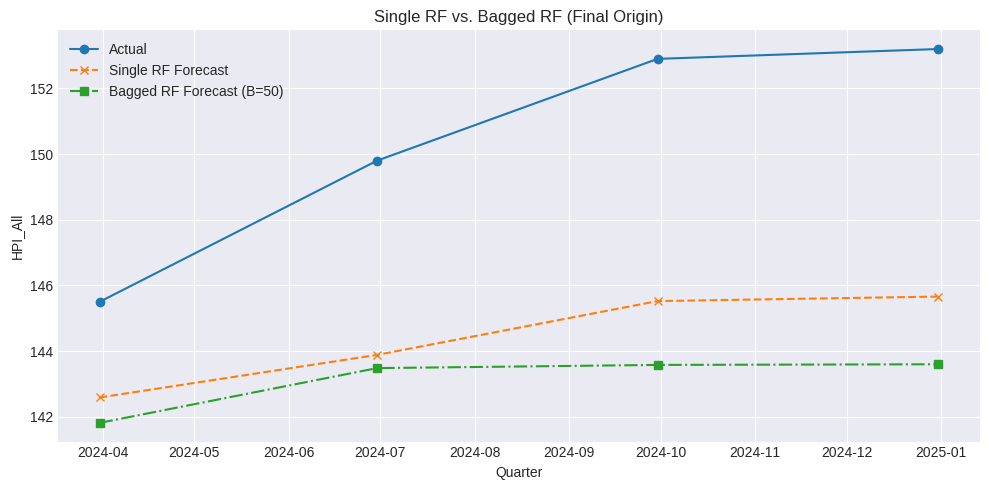

In [ ]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

# Data preparation function
def make_features(df, lags=[1,2,4], seasonal=True):
    X = pd.DataFrame(index=df.index)
    for lag in lags:
        X[f"HPI_lag_{lag}"] = df["HPI_All"].shift(lag)
    if seasonal:
        quarters = df.index.quarter
        for q in [1,2,3,4]:
            X[f"Q{q}"] = (quarters == q).astype(int)
    return X.dropna()

# Single (Non-bagged) RF function
def run_single_rf_pipeline(data, rf_params, feature_lags, forecast_horizon=4, init_train_frac=0.8):
    feats = make_features(data, lags=feature_lags)
    target = data.loc[feats.index, "HPI_All"]
    n = len(feats)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)
    preds, acts = {}, {}
    for h in range(1, forecast_horizon+1):
        preds[h], acts[h] = [], []
    final_dates = final_fc = final_act = None
    for i in tqdm(range(init_n, n - forecast_horizon + 1), desc="Single RF"):
        train_idx = feats.index[:i]
        test_idx  = feats.index[i : i + forecast_horizon]
        model = RandomForestRegressor(**rf_params, random_state=42, n_jobs=-1)
        model.fit(feats.loc[train_idx], target.loc[train_idx])
        fc = model.predict(feats.loc[test_idx])
        for h in range(forecast_horizon):
            preds[h+1].append(fc[h])
            acts[h+1].append(target.loc[test_idx].iloc[h])
        if i == n - forecast_horizon:
            final_dates = test_idx
            final_fc = fc.copy()
            final_act = target.loc[test_idx].values.copy()
    error_stats = {}
    all_f, all_a = [], []
    for h in preds:
        f, a = np.array(preds[h]), np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f)),
        }
        all_f.extend(f); all_a.extend(a)
    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }
    return error_stats, aggregated, final_dates, final_fc, final_act

# Bagged RF function
def run_bagged_rf_pipeline(data, rf_params, feature_lags, B=50, forecast_horizon=4, init_train_frac=0.8):
    feats = make_features(data, lags=feature_lags)
    target = data.loc[feats.index, "HPI_All"]
    n = len(feats)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)
    preds, acts = {h: [] for h in range(1, forecast_horizon+1)}, {h: [] for h in range(1, forecast_horizon+1)}
    final_dates = final_fc = final_act = None
    for i in tqdm(range(init_n, n - forecast_horizon + 1), desc=f"Bagged RF (B={B})"):
        train_idx, test_idx = feats.index[:i], feats.index[i:i+forecast_horizon]
        bag_fc = np.zeros((B, forecast_horizon))
        for b in range(B):
            boot_idx = np.random.choice(train_idx, size=len(train_idx), replace=True)
            model = RandomForestRegressor(**rf_params, random_state=42+b, n_jobs=-1)
            model.fit(feats.loc[boot_idx], target.loc[boot_idx])
            bag_fc[b] = model.predict(feats.loc[test_idx])
        avg_fc = np.mean(bag_fc, axis=0)
        for h in range(forecast_horizon):
            preds[h+1].append(avg_fc[h])
            acts[h+1].append(target.loc[test_idx].iloc[h])
        if i == n - forecast_horizon:
            final_dates, final_fc, final_act = test_idx, avg_fc.copy(), target.loc[test_idx].values.copy()
    error_stats = {}
    all_f, all_a = [], []
    for h in preds:
        f, a = np.array(preds[h]), np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f)),
        }
        all_f.extend(f); all_a.extend(a)
    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }
    return error_stats, aggregated, final_dates, final_fc, final_act

# Run explicitly Single RF & Bagged RF for clear comparison
rf_params = {"n_estimators": 200, "max_depth": 10, "min_samples_leaf": 2, "max_features": "sqrt"}

# Single RF
errs_single, agg_single, dates_single, fc_single, act_single = run_single_rf_pipeline(
    data=final_hpi_data, rf_params=rf_params, feature_lags=[1,2,4])

# Bagged RF
errs_bagged, agg_bagged, dates_bagged, fc_bagged, act_bagged = run_bagged_rf_pipeline(
    data=final_hpi_data, rf_params=rf_params, feature_lags=[1,2,4], B=50)

# Explicit performance comparison
print("\n--- Performance Comparison ---")
for label, agg in zip(["Single RF", "Bagged RF (B=50)"], [agg_single, agg_bagged]):
    print(f"{label}: Overall MAE={agg['Overall_MAE']:.3f}, RMSE={agg['Overall_RMSE']:.3f}")

# Explicit Final Plot Comparison
plt.figure(figsize=(10,5))
plt.plot(dates_single, act_single, marker='o', label="Actual")
plt.plot(dates_single, fc_single, marker='x', ls="--", label="Single RF Forecast")
plt.plot(dates_bagged, fc_bagged, marker='s', ls="-.", label="Bagged RF Forecast (B=50)")
plt.title("Single RF vs. Bagged RF (Final Origin)")
plt.xlabel("Quarter"); plt.ylabel("HPI_All")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## second rf try

Single RF Diff:   0%|          | 0/42 [00:00<?, ?it/s]

Bagged RF Diff (B=50):   0%|          | 0/42 [00:00<?, ?it/s]


--- Explicit Performance Comparison (RF on Diff) ---
Single RF Diff: Overall MAE=6.086, RMSE=7.378
Bagged RF Diff (B=50): Overall MAE=6.158, RMSE=7.416


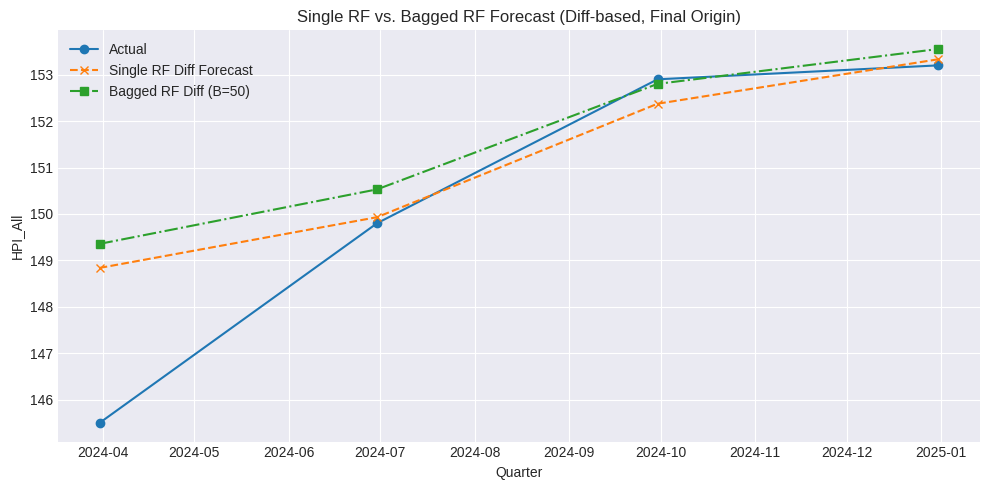

In [ ]:
# Explicit required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

# Explicit Differencing-Based Feature Engineering
def make_features_diff(df, lags=[1,2,4], seasonal=True):
    X = pd.DataFrame(index=df.index)
    for lag in lags:
        X[f"HPI_Diff_lag_{lag}"] = df["HPI_Diff"].shift(lag)
    if seasonal:
        quarters = df.index.quarter
        for q in [1,2,3,4]:
            X[f"Q{q}"] = (quarters == q).astype(int)
    return X.dropna()

# Explicit single RF on differenced data
def run_single_rf_diff(data, rf_params, lags, horizon=4, init_train_frac=0.8):
    feats = make_features_diff(data, lags=lags)
    target = data.loc[feats.index, "HPI_Diff"]
    n = len(feats)
    init_n = max(int(n * init_train_frac), horizon + 1)
    preds, acts = {}, {}
    final_dates = final_fc = final_act = None
    for h in range(1, horizon+1):
        preds[h], acts[h] = [], []
    for i in tqdm(range(init_n, n - horizon + 1), desc="Single RF Diff"):
        train_idx = feats.index[:i]
        test_idx = feats.index[i : i + horizon]
        model = RandomForestRegressor(**rf_params, random_state=42, n_jobs=-1)
        model.fit(feats.loc[train_idx], target.loc[train_idx])
        fc = model.predict(feats.loc[test_idx])
        # explicitly reconstruct level from predicted diffs
        last_level = data["HPI_All"].iloc[i - 1]
        level_fc = last_level + np.cumsum(fc)
        actual_level = data["HPI_All"].loc[test_idx].values
        for h in range(horizon):
            preds[h+1].append(level_fc[h])
            acts[h+1].append(actual_level[h])
        if i == n - horizon:
            final_dates = test_idx
            final_fc = level_fc.copy()
            final_act = actual_level.copy()
    # Metrics
    all_f, all_a = [], []
    for h in preds:
        all_f.extend(preds[h]); all_a.extend(acts[h])
    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }
    return aggregated, final_dates, final_fc, final_act

# Explicit bagged RF with diffs
def run_bagged_rf_diff(data, rf_params, lags, B=50, horizon=4, init_train_frac=0.8):
    feats = make_features_diff(data, lags=lags)
    target = data.loc[feats.index, "HPI_Diff"]
    n = len(feats)
    init_n = max(int(n * init_train_frac), horizon + 1)
    preds, acts = {}, {}
    for h in range(1, horizon+1):
        preds[h], acts[h] = [], []
    final_dates = final_fc = final_act = None
    for i in tqdm(range(init_n, n - horizon + 1), desc=f"Bagged RF Diff (B={B})"):
        train_idx = feats.index[:i]
        test_idx  = feats.index[i : i + horizon]
        bag_fc = np.zeros((B, horizon))
        for b in range(B):
            boot_idx = np.random.choice(train_idx, size=len(train_idx), replace=True)
            model = RandomForestRegressor(**rf_params, random_state=42+b, n_jobs=-1)
            model.fit(feats.loc[boot_idx], target.loc[boot_idx])
            bag_fc[b] = model.predict(feats.loc[test_idx])
        avg_fc_diff = np.mean(bag_fc, axis=0)
        last_level = data["HPI_All"].iloc[i - 1]
        level_fc = last_level + np.cumsum(avg_fc_diff)
        actual_level = data["HPI_All"].loc[test_idx].values
        for h in range(horizon):
            preds[h+1].append(level_fc[h])
            acts[h+1].append(actual_level[h])
        if i == n - horizon:
            final_dates = test_idx
            final_fc = level_fc.copy()
            final_act = actual_level.copy()
    # Metrics
    all_f, all_a = [], []
    for h in preds:
        all_f.extend(preds[h]); all_a.extend(acts[h])
    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }
    return aggregated, final_dates, final_fc, final_act

# Explicit Run
rf_params = {"n_estimators": 200, "max_depth": 10, "min_samples_leaf": 2, "max_features": "sqrt"}

# Single RF on diffs
agg_single, dates_single, fc_single, act_single = run_single_rf_diff(
    final_hpi_data, rf_params, [1,2,4])

# Bagged RF on diffs
agg_bagged, dates_bagged, fc_bagged, act_bagged = run_bagged_rf_diff(
    final_hpi_data, rf_params, [1,2,4], B=50)

# Explicit Performance Comparison
print("\n--- Explicit Performance Comparison (RF on Diff) ---")
for lbl, agg in zip(["Single RF Diff", "Bagged RF Diff (B=50)"], [agg_single, agg_bagged]):
    print(f"{lbl}: Overall MAE={agg['Overall_MAE']:.3f}, RMSE={agg['Overall_RMSE']:.3f}")

# Plot explicitly corrected forecast
plt.figure(figsize=(10,5))
plt.plot(dates_single, act_single, marker='o', label="Actual")
plt.plot(dates_single, fc_single, marker='x', ls="--", label="Single RF Diff Forecast")
plt.plot(dates_bagged, fc_bagged, marker='s', ls="-.", label="Bagged RF Diff (B=50)")
plt.title("Single RF vs. Bagged RF Forecast (Diff-based, Final Origin)")
plt.xlabel("Quarter"); plt.ylabel("HPI_All"); plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


# very first try OLD

##Data import and tests

In [ ]:
# Re-import necessary libraries
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# For better plots
plt.style.use('seaborn-v0_8-darkgrid')


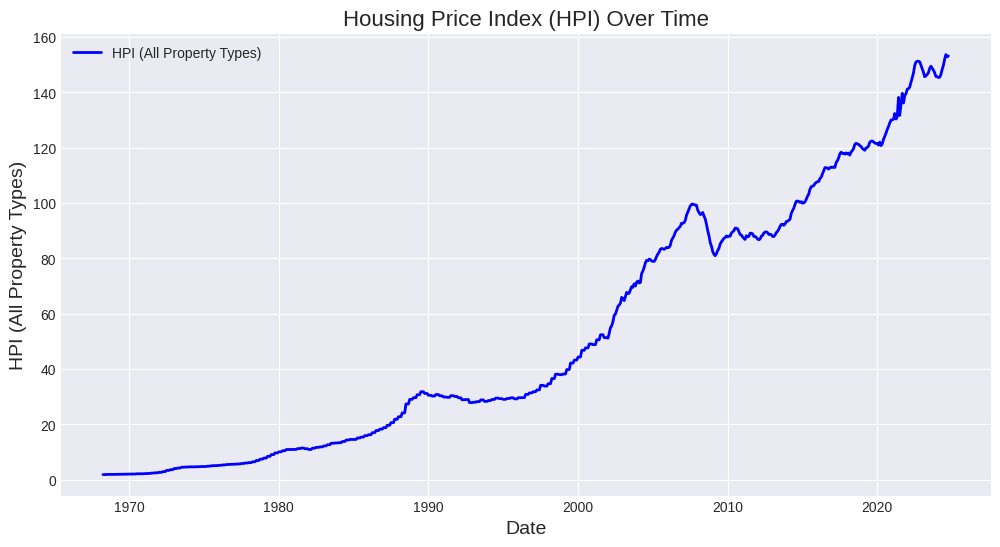

In [ ]:
# Load the source file
source_data = pd.read_csv("/content/drive/MyDrive/thesis data/ukhpi-property-type-hpi-united-kingdom-from-1968-01-01-to-2024-11-01.csv")

# Extract relevant columns and convert date to datetime
source_data["Period"] = pd.to_datetime(source_data["Period"])
hpi_data = source_data[["Period", "House price index All property types"]].copy()

# Rename columns for clarity
hpi_data.rename(columns={"Period": "Date", "House price index All property types": "HPI_All"}, inplace=True)

# Plot the original HPI data
plt.figure(figsize=(12, 6))
plt.plot(hpi_data["Date"], hpi_data["HPI_All"], label="HPI (All Property Types)", color="blue", linewidth=2)
plt.title("Housing Price Index (HPI) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("HPI (All Property Types)", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Ensure datetime format
hpi_data["Date"] = pd.to_datetime(hpi_data["Date"])

# Split data at the transition point (2002-01-01)
transition_date = pd.Timestamp("2002-01-01")
hpi_before_2002 = hpi_data[hpi_data["Date"] < transition_date].copy()
hpi_after_2002 = hpi_data[hpi_data["Date"] >= transition_date].copy()

# Keep only the last month of each quarter (3,6,9,12) for quarterly data before 2002
hpi_before_2002_quarterly = hpi_before_2002[
    hpi_before_2002["Date"].dt.month.isin([3, 6, 9, 12])
].copy()

# Quarterly differencing (3-month periods)
hpi_before_2002_quarterly["HPI_Diff"] = hpi_before_2002_quarterly["HPI_All"].diff(periods=1)

# Monthly differencing (from 2002 onwards)
hpi_after_2002["HPI_Diff"] = hpi_after_2002["HPI_All"].diff(periods=1)

# Combine datasets after differencing
hpi_diff_final = pd.concat([hpi_before_2002_quarterly, hpi_after_2002]).dropna()


In [ ]:
# Perform ADF test
adf_test_result = adfuller(hpi_diff_final["HPI_Diff"].dropna())

# Display ADF test results
print(f"ADF Statistic: {adf_test_result[0]:.4f}")
print(f"p-value: {adf_test_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_test_result[4].items():
    print(f"\t{key}: {value:.4f}")


ADF Statistic: -4.1328
p-value: 0.0009
Critical Values:
	1%: -3.4473
	5%: -2.8690
	10%: -2.5708


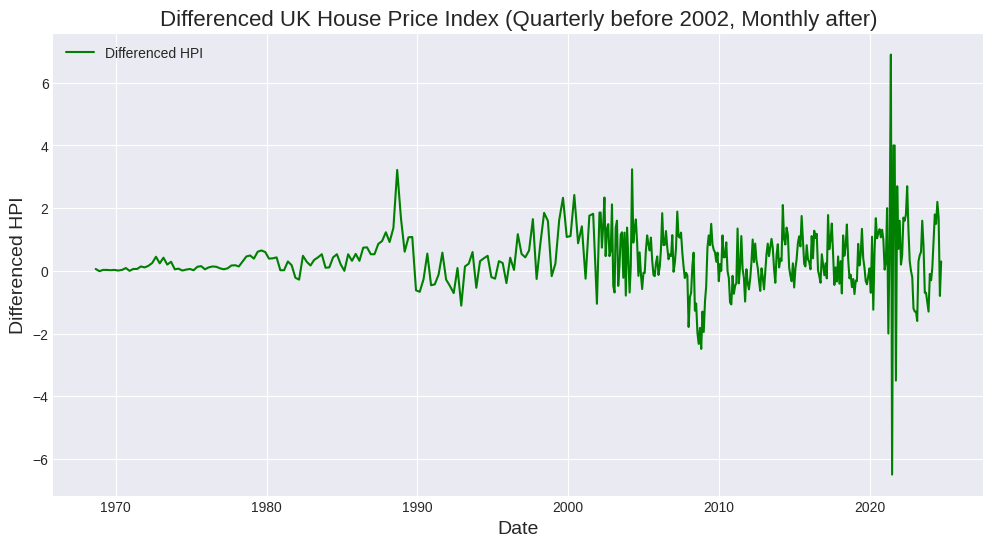

In [ ]:
# Visualizing the differenced HPI data
plt.figure(figsize=(12, 6))
plt.plot(hpi_diff_final["Date"], hpi_diff_final["HPI_Diff"], color='green', label='Differenced HPI')
plt.title("Differenced UK House Price Index (Quarterly before 2002, Monthly after)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Differenced HPI", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


1. 📊 Identify ARIMA Model Parameters

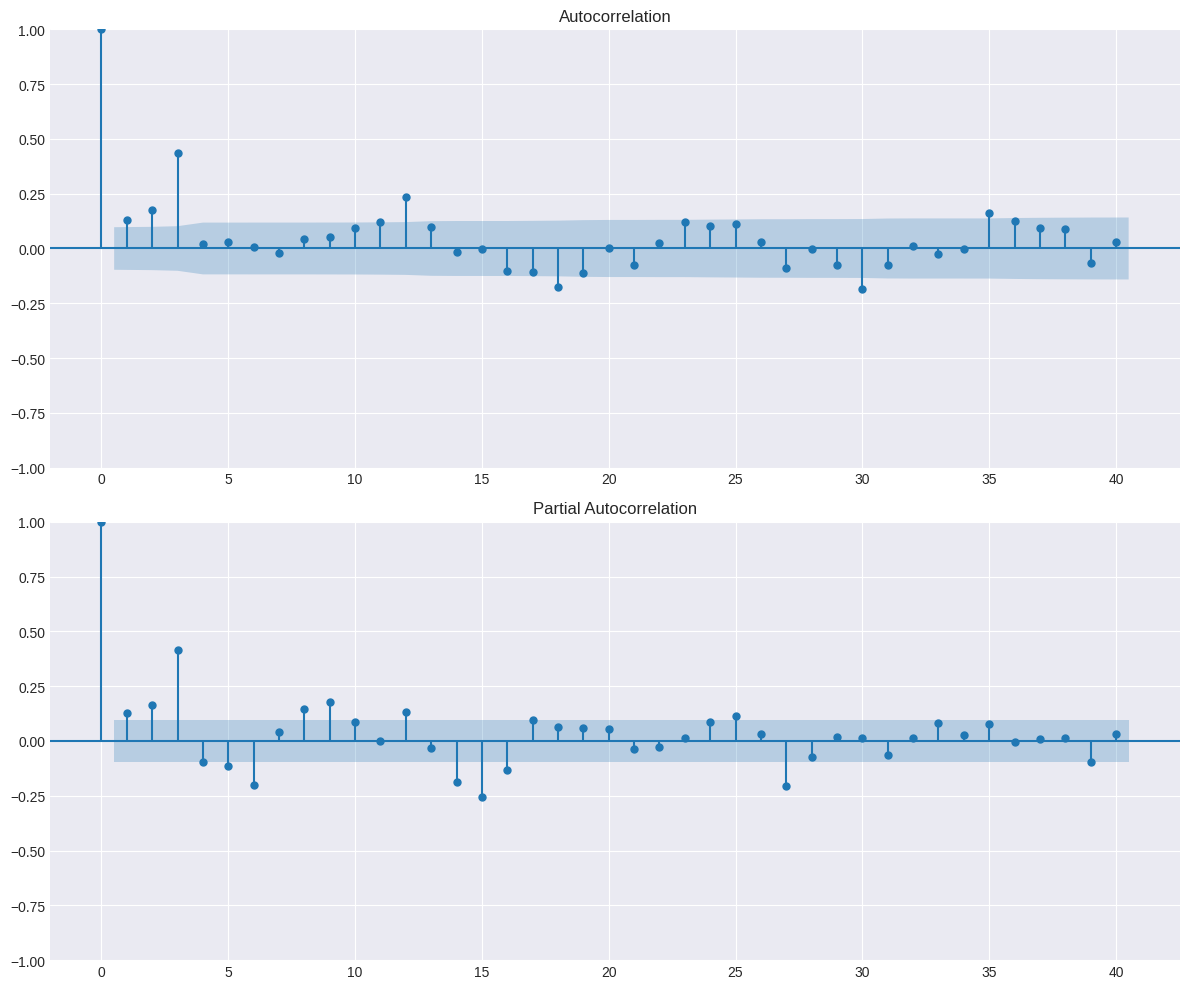

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, ax = plt.subplots(2, figsize=(12,10))
plot_acf(hpi_diff_final["HPI_Diff"], lags=40, ax=ax[0])
plot_pacf(hpi_diff_final["HPI_Diff"], lags=40, method='ywm', ax=ax[1])
plt.tight_layout()
plt.show()


In [ ]:
hpi_diff_final

Date  HPI_All  HPI_Diff
5   1968-09-01     1.95      0.06
8   1968-12-01     1.94     -0.01
11  1969-03-01     1.97      0.03
14  1969-06-01     2.00      0.03
17  1969-09-01     2.02      0.02
..         ...      ...       ...
674 2024-06-01   149.80      1.50
675 2024-07-01   152.00      2.20
676 2024-08-01   153.70      1.70
677 2024-09-01   152.90     -0.80
678 2024-10-01   153.20      0.30

[407 rows x 3 columns]

In [ ]:
hpi_data

Date  HPI_All
0   1968-04-01     1.89
1   1968-05-01     1.89
2   1968-06-01     1.89
3   1968-07-01     1.95
4   1968-08-01     1.95
..         ...      ...
674 2024-06-01   149.80
675 2024-07-01   152.00
676 2024-08-01   153.70
677 2024-09-01   152.90
678 2024-10-01   153.20

[679 rows x 2 columns]

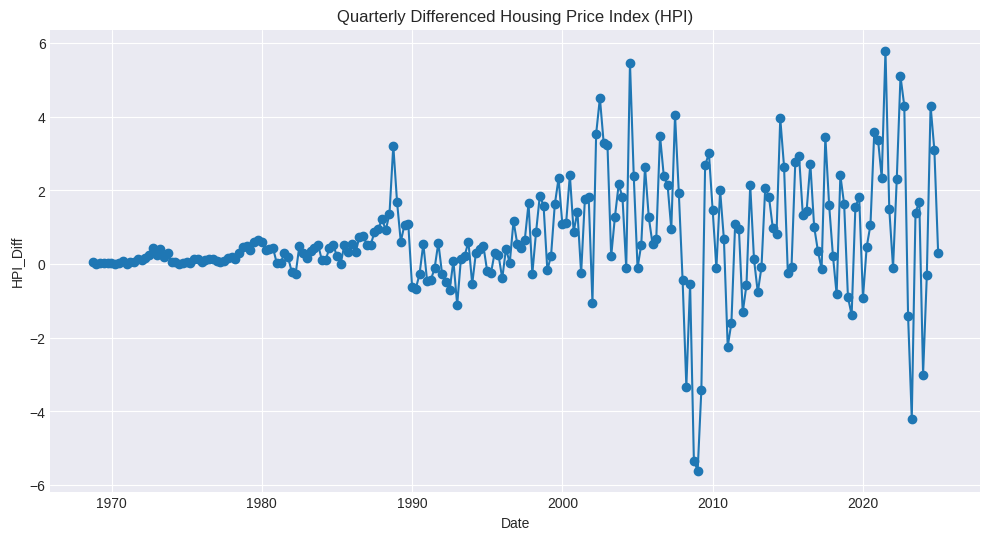

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# ---------- Step 1: Ensure DateTime and Sort Data ----------
hpi_data["Date"] = pd.to_datetime(hpi_data["Date"])
hpi_data = hpi_data.sort_values("Date")

# ---------- Step 2: Split the Data at the 2002 Transition ----------
transition_date = pd.Timestamp("2002-01-01")
hpi_before_2002 = hpi_data[hpi_data["Date"] < transition_date].copy()
hpi_after_2002 = hpi_data[hpi_data["Date"] >= transition_date].copy()

# ---------- Step 3: Pre-process Pre-2002 Data ----------
# For pre-2002 data, which is quarterly, we select rows for the target months: March, June, September, and December.
hpi_before_2002_quarterly = hpi_before_2002[hpi_before_2002["Date"].dt.month.isin([3, 6, 9, 12])].copy()
# Since the original dates are at the start of the month (e.g., "1968-03-01") we shift them to the quarter-end.
hpi_before_2002_quarterly["Date"] = hpi_before_2002_quarterly["Date"] + pd.offsets.MonthEnd(0)

# ---------- Step 4: Downsample Post-2002 Data to Quarterly ----------
# Set 'Date' as index for post-2002 data.
hpi_after_2002.set_index("Date", inplace=True)
# Resample post-2002 monthly data to quarterly by taking the last observation of each quarter.
hpi_after_2002_quarterly = hpi_after_2002.resample('QE-DEC').last().reset_index()

# ---------- Step 5: Merge Datasets and Compute Differencing ----------
# Concatenate both quarterly datasets and sort them.
combined = pd.concat([hpi_before_2002_quarterly, hpi_after_2002_quarterly]).sort_values("Date").reset_index(drop=True)
# Compute the differenced series.
combined["HPI_Diff"] = combined["HPI_All"].diff()
combined = combined.dropna().reset_index(drop=True)

# ---------- Step 6: Set Date as a Quarterly Frequency Index ----------
# Set the Date column as the index and specify a uniform quarterly (quarter-end) frequency.
combined = combined.set_index("Date")
combined = combined.asfreq('QE-DEC')  # 'QE-DEC' indicates quarter-end with December as the fiscal year-end.

# ---------- Optional: Visualize the Differenced Series ----------
plt.figure(figsize=(12, 6))
plt.plot(combined.index, combined["HPI_Diff"], marker='o', linestyle='-')
plt.title("Quarterly Differenced Housing Price Index (HPI)")
plt.xlabel("Date")
plt.ylabel("HPI_Diff")
plt.grid(True)
plt.show()


In [ ]:
combined

HPI_All  HPI_Diff
Date                         
1968-09-30     1.95      0.06
1968-12-31     1.94     -0.01
1969-03-31     1.97      0.03
1969-06-30     2.00      0.03
1969-09-30     2.02      0.02
...             ...       ...
2023-12-31   145.80     -3.00
2024-03-31   145.50     -0.30
2024-06-30   149.80      4.30
2024-09-30   152.90      3.10
2024-12-31   153.20      0.30

[226 rows x 2 columns]

In [ ]:
# ---------------- Step 6.5: Create Train/Test Split ----------------
# We'll use an 80/20 split: 80% of the data for training and 20% for testing.
split_index = int(len(combined) * 0.80)
train = combined.iloc[:split_index].copy()  # training data
test = combined.iloc[split_index:].copy()   # test (out-of-sample) data

# Document: We'll use the last HPI_All value of the training set to invert differencing later.
last_train_value = train["HPI_All"].iloc[-1]

                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  180
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -278.704
Date:                Wed, 16 Apr 2025   AIC                            565.409
Time:                        17:27:31   BIC                            578.180
Sample:                    09-30-1968   HQIC                           570.587
                         - 06-30-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4984      0.165      3.028      0.002       0.176       0.821
ar.L1          0.3251      0.095      3.416      0.001       0.139       0.512
ma.L1          0.2181      0.092      2.365      0.0

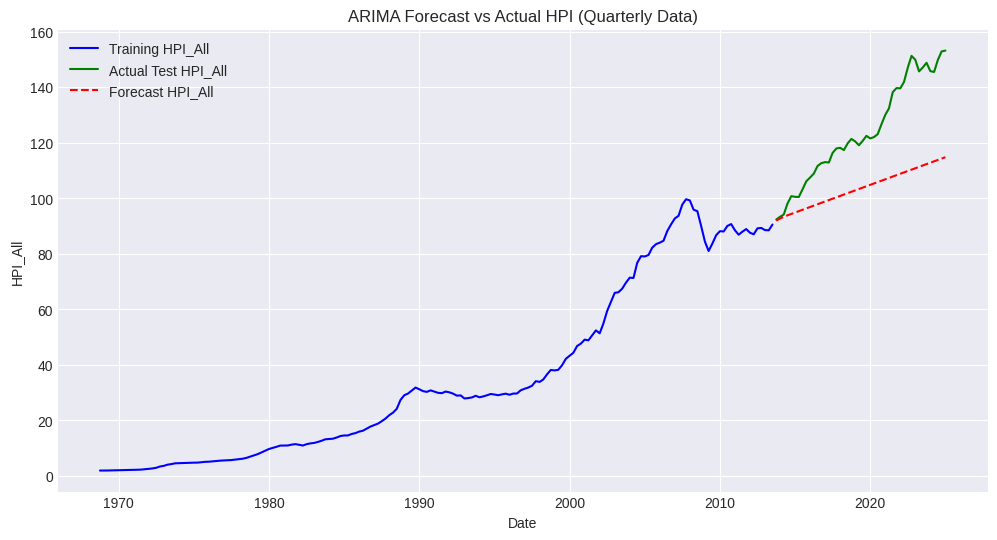

Error Statistics:
MAE: 20.3699
MSE: 551.4482
RMSE: 23.4829


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------------- Step 1: Ensure DateTime and Sort Data ----------------
hpi_data["Date"] = pd.to_datetime(hpi_data["Date"])
hpi_data = hpi_data.sort_values("Date")

# ---------------- Step 2: Split the Data at the 2002 Transition ----------------
transition_date = pd.Timestamp("2002-01-01")
hpi_before_2002 = hpi_data[hpi_data["Date"] < transition_date].copy()
hpi_after_2002 = hpi_data[hpi_data["Date"] >= transition_date].copy()

# ---------------- Step 3: Pre-process Pre-2002 Data ----------------
# For pre-2002 data, which is quarterly, select rows for target months: March, June, September, and December.
hpi_before_2002_quarterly = hpi_before_2002[hpi_before_2002["Date"].dt.month.isin([3, 6, 9, 12])].copy()
# Shift these dates from the start to the quarter-end.
hpi_before_2002_quarterly["Date"] = hpi_before_2002_quarterly["Date"] + pd.offsets.MonthEnd(0)

# ---------------- Step 4: Downsample Post-2002 Data to Quarterly ----------------
# Set 'Date' as index for post-2002 data.
hpi_after_2002.set_index("Date", inplace=True)
# Resample post-2002 monthly data to quarterly by taking the last observation of each quarter.
hpi_after_2002_quarterly = hpi_after_2002.resample('QE-DEC').last().reset_index()

# ---------------- Step 5: Merge Datasets and Compute Differencing ----------------
# Concatenate both quarterly datasets and sort them.
combined = pd.concat([hpi_before_2002_quarterly, hpi_after_2002_quarterly]).sort_values("Date").reset_index(drop=True)
# Compute the differenced series.
combined["HPI_Diff"] = combined["HPI_All"].diff()
combined = combined.dropna().reset_index(drop=True)

# ---------------- Step 6: Set Date as a Quarterly Frequency Index ----------------
combined = combined.set_index("Date")
combined = combined.asfreq('QE-DEC')  # Ensure a uniform quarterly frequency.

# ---------------- Step 6.5: Create Train/Test Split ----------------
# Use an 80/20 split for training and test sets.
split_index = int(len(combined) * 0.80)
train = combined.iloc[:split_index].copy()  # Training data.
test = combined.iloc[split_index:].copy()   # Test (out-of-sample) data.

# Document: Capture the last HPI_All value from the training set to invert differencing.
last_train_value = train["HPI_All"].iloc[-1]

# ---------------- Step 7: Fit ARIMA on Training Data ----------------
# The series is already differenced, so we use d=0.
arima_model = ARIMA(train["HPI_Diff"], order=(1, 0, 1))
model_fit = arima_model.fit()
print(model_fit.summary())

# ---------------- Step 8: Forecast Over the Test Period ----------------
# Forecast as many steps ahead as the length of the test set.
n_forecast = len(test)
forecast_diff = model_fit.forecast(steps=n_forecast)

# ==================== INVERT DIFFERENCING TO OBTAIN LEVEL FORECAST ====================
# Recover forecasted HPI levels by cumulatively summing the forecasted differences and adding the last training HPI level.
forecast_levels = last_train_value + forecast_diff.cumsum()

# ---------------- Step 9: Plot the Results ----------------
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["HPI_All"], label="Training HPI_All", color='blue')
plt.plot(test.index, test["HPI_All"], label="Actual Test HPI_All", color='green')
plt.plot(test.index, forecast_levels, label="Forecast HPI_All", color='red', linestyle='--')
plt.title("ARIMA Forecast vs Actual HPI (Quarterly Data)")
plt.xlabel("Date")
plt.ylabel("HPI_All")
plt.legend()
plt.grid(True)
plt.show()

# ---------------- Step 10: Compute and Display Error Statistics ----------------
mae = mean_absolute_error(test["HPI_All"], forecast_levels)
mse = mean_squared_error(test["HPI_All"], forecast_levels)
rmse = np.sqrt(mse)

print("Error Statistics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Initial training size: 113 observations out of 226.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Rolling Forecast Error Statistics:
MAE: 1.4099
MSE: 3.5621
RMSE: 1.8874


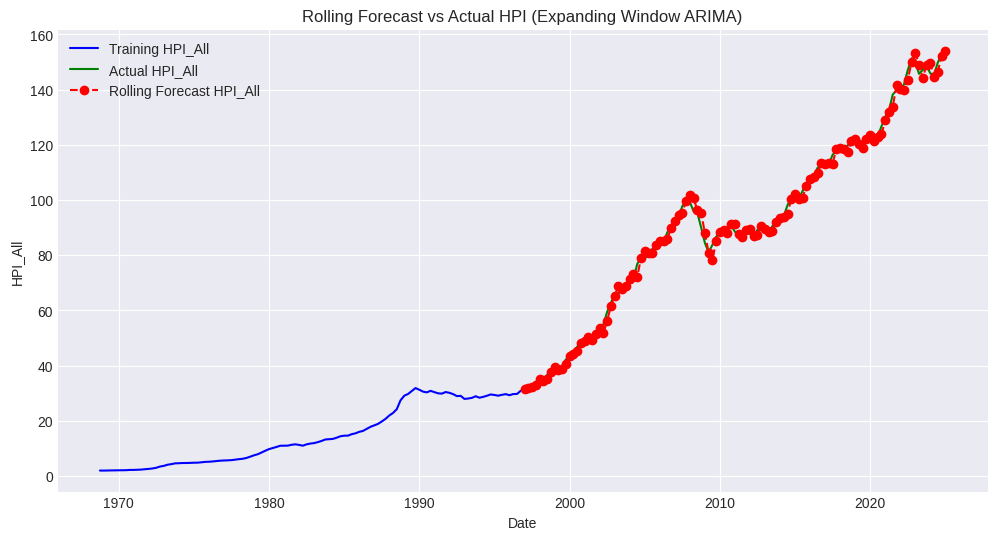

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------------- Step 1: Ensure DateTime and Sort Data ----------------
hpi_data["Date"] = pd.to_datetime(hpi_data["Date"])
hpi_data = hpi_data.sort_values("Date")

# ---------------- Step 2: Split the Data at the 2002 Transition ----------------
transition_date = pd.Timestamp("2002-01-01")
hpi_before_2002 = hpi_data[hpi_data["Date"] < transition_date].copy()
hpi_after_2002 = hpi_data[hpi_data["Date"] >= transition_date].copy()

# ---------------- Step 3: Pre-process Pre-2002 Data ----------------
# For pre-2002 data (quarterly), select rows for target months: March, June, September, December.
hpi_before_2002_quarterly = hpi_before_2002[hpi_before_2002["Date"].dt.month.isin([3, 6, 9, 12])].copy()
# Shift these dates to the quarter-end (e.g., "1968-03-01" becomes "1968-03-31")
hpi_before_2002_quarterly["Date"] = hpi_before_2002_quarterly["Date"] + pd.offsets.MonthEnd(0)

# ---------------- Step 4: Downsample Post-2002 Data to Quarterly ----------------
# Set the index for post-2002 data and resample to quarterly using 'QE-DEC'
hpi_after_2002.set_index("Date", inplace=True)
hpi_after_2002_quarterly = hpi_after_2002.resample('QE-DEC').last().reset_index()

# ---------------- Step 5: Merge Datasets and Compute Differencing ----------------
# Merge the pre-2002 and post-2002 quarterly datasets and sort by date.
combined = pd.concat([hpi_before_2002_quarterly, hpi_after_2002_quarterly]).sort_values("Date").reset_index(drop=True)
# Compute the differenced series.
combined["HPI_Diff"] = combined["HPI_All"].diff()
combined = combined.dropna().reset_index(drop=True)

# ---------------- Step 6: Set Date as a Quarterly Frequency Index ----------------
combined = combined.set_index("Date")
combined = combined.asfreq('QE-DEC')  # 'QE-DEC' ensures dates are aligned to quarter-ends

# ---------------- Step 7: Expanding Window (Rolling) Forecast for ARIMA ----------------
# Set an initial training window (e.g., using first 50% of data)
initial_train_size = int(len(combined) * 0.50)
print(f"Initial training size: {initial_train_size} observations out of {len(combined)}.")

# Prepare lists to hold forecasts, actual values, and dates
roll_forecasts = []
roll_actuals = []
roll_dates = []

# Rolling forecast: for each time step after the initial training period, fit the model and forecast one step ahead.
for i in range(initial_train_size, len(combined)):
    train_roll = combined.iloc[:i]  # Expanding training window
    test_point = combined.iloc[i]

    # Save the last observed level value from training (for inverting differencing)
    last_train_value = train_roll["HPI_All"].iloc[-1]

    # Fit ARIMA on the differenced series from the current training window
    try:
        model = ARIMA(train_roll["HPI_Diff"], order=(1, 0, 1))
        result = model.fit()
        # Forecast one step ahead in difference space
        forecast_diff = result.forecast(steps=1)
        # Invert differencing to get the forecast in levels
        forecast_level = last_train_value + forecast_diff.iloc[0]
    except Exception as e:
        print(f"Error at index {i}: {e}")
        forecast_level = np.nan

    roll_forecasts.append(forecast_level)
    roll_actuals.append(test_point["HPI_All"])
    roll_dates.append(test_point.name)

# Convert forecasts and actuals to pandas Series for error calculation and plotting
roll_forecasts = pd.Series(roll_forecasts, index=roll_dates)
roll_actuals = pd.Series(roll_actuals, index=roll_dates)

# ---------------- Step 8: Compute and Display Error Statistics for Rolling Forecast ----------------
mae_roll = mean_absolute_error(roll_actuals, roll_forecasts)
mse_roll = mean_squared_error(roll_actuals, roll_forecasts)
rmse_roll = np.sqrt(mse_roll)

print("Rolling Forecast Error Statistics:")
print(f"MAE: {mae_roll:.4f}")
print(f"MSE: {mse_roll:.4f}")
print(f"RMSE: {rmse_roll:.4f}")

# ---------------- Step 9: Plot the Rolling Forecast Results ----------------
plt.figure(figsize=(12, 6))
plt.plot(combined.index[:initial_train_size], combined["HPI_All"].iloc[:initial_train_size], label="Training HPI_All", color='blue')
plt.plot(roll_actuals.index, roll_actuals.values, label="Actual HPI_All", color='green')
plt.plot(roll_forecasts.index, roll_forecasts.values, label="Rolling Forecast HPI_All", color='red', linestyle='--', marker='o')
plt.title("Rolling Forecast vs Actual HPI (Expanding Window ARIMA)")
plt.xlabel("Date")
plt.ylabel("HPI_All")
plt.legend()
plt.grid(True)
plt.show()


Initial training size: 113 observations out of 226.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Horizon 1 error statistics: MAE = 1.4039, MSE = 3.5453, RMSE = 1.8829
Horizon 2 error statistics: MAE = 2.7374, MSE = 12.4737, RMSE = 3.5318
Horizon 3 error statistics: MAE = 3.3721, MSE = 21.6309, RMSE = 4.6509
Horizon 4 error statistics: MAE = 3.8730, MSE = 31.0842, RMSE = 5.5753
Overall aggregated error statistics: MAE = 2.8466, RMSE = 4.1453


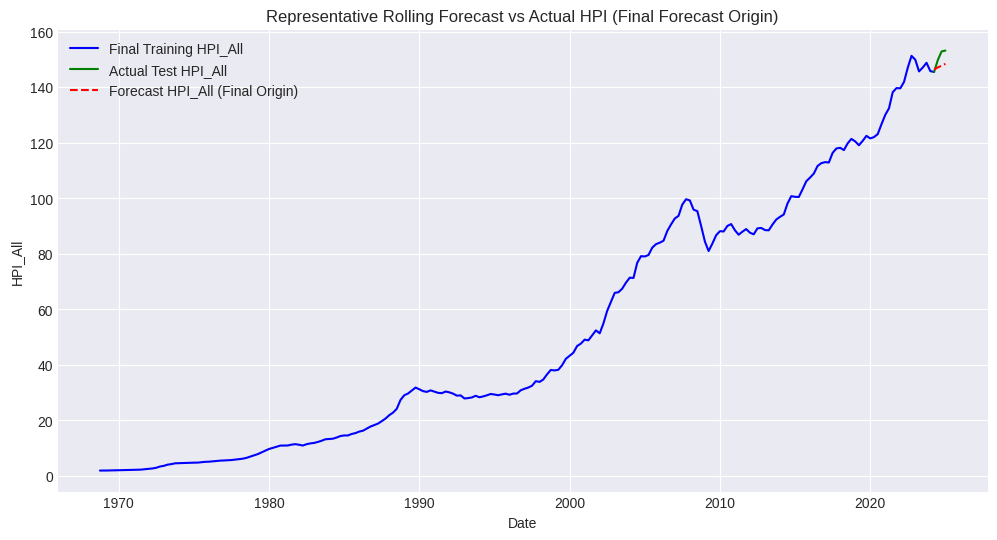

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------------- Step 1: Ensure DateTime and Sort Data ----------------
hpi_data["Date"] = pd.to_datetime(hpi_data["Date"])
hpi_data = hpi_data.sort_values("Date")

# ---------------- Step 2: Split the Data at the 2002 Transition ----------------
transition_date = pd.Timestamp("2002-01-01")
hpi_before_2002 = hpi_data[hpi_data["Date"] < transition_date].copy()
hpi_after_2002 = hpi_data[hpi_data["Date"] >= transition_date].copy()

# ---------------- Step 3: Pre-process Pre-2002 Data ----------------
# For pre-2002 data (quarterly), select rows for target months: March, June, September, and December.
hpi_before_2002_quarterly = hpi_before_2002[hpi_before_2002["Date"].dt.month.isin([3, 6, 9, 12])].copy()
# Shift these dates to the quarter-end (e.g., "1968-03-01" becomes "1968-03-31")
hpi_before_2002_quarterly["Date"] = hpi_before_2002_quarterly["Date"] + pd.offsets.MonthEnd(0)

# ---------------- Step 4: Downsample Post-2002 Data to Quarterly ----------------
# Set 'Date' as index for post-2002 data.
hpi_after_2002.set_index("Date", inplace=True)
# Resample post-2002 monthly data to quarterly by taking the last observation of each quarter.
hpi_after_2002_quarterly = hpi_after_2002.resample('QE-DEC').last().reset_index()

# ---------------- Step 5: Merge Datasets and Compute Differencing ----------------
# Concatenate both quarterly datasets and sort them.
combined = pd.concat([hpi_before_2002_quarterly, hpi_after_2002_quarterly]).sort_values("Date").reset_index(drop=True)
# Compute the differenced series.
combined["HPI_Diff"] = combined["HPI_All"].diff()
combined = combined.dropna().reset_index(drop=True)

# ---------------- Step 6: Set Date as a Quarterly Frequency Index ----------------
combined = combined.set_index("Date")
combined = combined.asfreq('QE-DEC')  # 'QE-DEC' ensures dates are aligned to quarter-ends

# ---------------- Step 7: Fixed Multi-Step (4 Quarters) Rolling Forecast for ARIMA ----------------
forecast_horizon = 4  # Forecast 4 quarters ahead (i.e., one year)
initial_train_size = int(len(combined) * 0.50)
print(f"Initial training size: {initial_train_size} observations out of {len(combined)}.")

# Dictionaries to store forecast and actual values for each horizon
forecasts_by_horizon = {h: [] for h in range(1, forecast_horizon+1)}
actuals_by_horizon = {h: [] for h in range(1, forecast_horizon+1)}
forecast_origins = []  # record the forecast origin dates (optional)

# Rolling forecast: use an expanding window forecast with a fixed horizon.
# Loop until there are enough observations to cover the horizon.
for i in range(initial_train_size, len(combined) - forecast_horizon + 1):
    train_roll = combined.iloc[:i]           # Expanding training window
    test_window = combined.iloc[i : i+forecast_horizon]  # Next 4 quarters
    forecast_origins.append(test_window.index[0])

    # Capture the last observed HPI_All from the training set to invert differencing.
    last_train_value = train_roll["HPI_All"].iloc[-1]

    # Fit ARIMA on the differenced training data (using ARIMA(1,0,1))
    try:
        model = ARIMA(train_roll["HPI_Diff"], order=(1, 0, 1))
        result = model.fit()
        # Forecast 4 steps ahead in the differenced space.
        forecast_diff = result.forecast(steps=forecast_horizon)
        # Invert differencing: cumulatively add forecasted differences to the last training value.
        forecast_levels = last_train_value + forecast_diff.cumsum()
    except Exception as e:
        print(f"Error at index {i}: {e}")
        # If an error occurs, fill with NaNs.
        forecast_levels = pd.Series([np.nan]*forecast_horizon, index=test_window.index)

    # Store forecasts and actual values for each horizon.
    for h in range(1, forecast_horizon+1):
        forecasts_by_horizon[h].append(forecast_levels.iloc[h-1])
        actuals_by_horizon[h].append(test_window["HPI_All"].iloc[h-1])

# ---------------- Step 8: Compute and Display Error Statistics ----------------
# Calculate error metrics for each forecast horizon.
for h in range(1, forecast_horizon+1):
    mae_h = mean_absolute_error(actuals_by_horizon[h], forecasts_by_horizon[h])
    mse_h = mean_squared_error(actuals_by_horizon[h], forecasts_by_horizon[h])
    rmse_h = np.sqrt(mse_h)
    print(f"Horizon {h} error statistics: MAE = {mae_h:.4f}, MSE = {mse_h:.4f}, RMSE = {rmse_h:.4f}")

# Optionally, aggregate errors across all horizons.
all_forecasts = []
all_actuals = []
for h in range(1, forecast_horizon+1):
    all_forecasts.extend(forecasts_by_horizon[h])
    all_actuals.extend(actuals_by_horizon[h])
overall_mae = mean_absolute_error(all_actuals, all_forecasts)
overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_forecasts))
print(f"Overall aggregated error statistics: MAE = {overall_mae:.4f}, RMSE = {overall_rmse:.4f}")

# ---------------- Step 9: Plot the Rolling Forecast Results for a Representative Forecast Origin ----------------
# For illustration, plot the forecasts from the final rolling split.
# (This is just one example; overall error stats are computed above.)
final_origin = combined.index[len(combined) - forecast_horizon]
final_train = combined.loc[:final_origin]
final_test = combined.loc[final_origin : final_origin + pd.DateOffset(months=3*(forecast_horizon-1))]
# For the final split, refit the model:
last_train_value = final_train["HPI_All"].iloc[-1]
model_final = ARIMA(final_train["HPI_Diff"], order=(1, 0, 1))
result_final = model_final.fit()
forecast_diff_final = result_final.forecast(steps=forecast_horizon)
forecast_levels_final = last_train_value + forecast_diff_final.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(final_train.index, final_train["HPI_All"], label="Final Training HPI_All", color='blue')
plt.plot(final_test.index, final_test["HPI_All"], label="Actual Test HPI_All", color='green')
plt.plot(final_test.index, forecast_levels_final, label="Forecast HPI_All (Final Origin)", color='red', linestyle='--')
plt.title("Representative Rolling Forecast vs Actual HPI (Final Forecast Origin)")
plt.xlabel("Date")
plt.ylabel("HPI_All")
plt.legend()
plt.grid(True)
plt.show()


## ARIMA pipeline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def run_arima_pipeline(data, arima_order=(1, 0, 1), forecast_horizon=4, init_train_frac=0.50, verbose=True):
    """
    Runs a fixed multi-step (e.g., 4 quarters ahead) rolling forecast using an expanding window on the provided data.

    Parameters:
        data: pd.DataFrame
            The combined DataFrame with columns "HPI_All" and "HPI_Diff", indexed by Date at a quarterly frequency.
        arima_order: tuple, default (1, 0, 1)
            The (p, d, q) order for the ARIMA model. (Note: d should be 0 since the data is already differenced.)
        forecast_horizon: int, default 4
            The number of quarters to forecast ahead (e.g., 4 = one year ahead).
        init_train_frac: float, default 0.50
            Fraction of data to use as the initial training window.
        verbose: bool, default True
            If True, prints progress messages.

    Returns:
        error_stats: dict
            A dictionary with horizon-specific error statistics (MAE, MSE, RMSE) for each forecast horizon.
        aggregated_errors: dict
            Overall aggregated error statistics (MAE and RMSE) across all horizons.
        final_model_summary: str
            The summary of the ARIMA model from the final rolling iteration.
    """
    # Determine the initial training size, ensuring it's at least forecast_horizon+1
    initial_train_size = max(int(len(data) * init_train_frac), forecast_horizon + 1)
    if verbose:
        print(f"Initial training size: {initial_train_size} observations out of {len(data)}.")

    # Dictionaries to store forecasts and actual values for each horizon
    forecasts_by_horizon = {h: [] for h in range(1, forecast_horizon+1)}
    actuals_by_horizon = {h: [] for h in range(1, forecast_horizon+1)}
    final_model_summary = None  # To store the final iteration summary

    # Rolling forecast: use an expanding window across the dataset.
    for i in range(initial_train_size, len(data) - forecast_horizon + 1):
        train_roll = data.iloc[:i]
        test_window = data.iloc[i : i+forecast_horizon]

        # Capture the last observed HPI_All for inverting differencing.
        last_train_value = train_roll["HPI_All"].iloc[-1]

        try:
            model = ARIMA(train_roll["HPI_Diff"], order=arima_order)
            result = model.fit()  # Note: No disp argument here.
            forecast_diff = result.forecast(steps=forecast_horizon)
        except Exception as e:
            if verbose:
                print(f"Error at rolling index {i}: {e}")
            forecast_diff = pd.Series([np.nan]*forecast_horizon, index=test_window.index)

        # Invert differencing: forecast cumulative sum added to last training level.
        forecast_levels = last_train_value + forecast_diff.cumsum()

        for h in range(1, forecast_horizon+1):
            forecasts_by_horizon[h].append(forecast_levels.iloc[h-1])
            actuals_by_horizon[h].append(test_window["HPI_All"].iloc[h-1])

        # Save the final iteration's model summary.
        if i == len(data) - forecast_horizon:
            final_model_summary = result.summary().as_text()

    # Compute error statistics for each horizon.
    error_stats = {}
    for h in range(1, forecast_horizon+1):
        fh_forecasts = np.array(forecasts_by_horizon[h])
        fh_actuals = np.array(actuals_by_horizon[h])
        valid_idx = ~np.isnan(fh_forecasts)
        if np.sum(valid_idx) == 0:
            error_stats[h] = {"MAE": np.nan, "MSE": np.nan, "RMSE": np.nan}
        else:
            mae_h = mean_absolute_error(fh_actuals[valid_idx], fh_forecasts[valid_idx])
            mse_h = mean_squared_error(fh_actuals[valid_idx], fh_forecasts[valid_idx])
            rmse_h = np.sqrt(mse_h)
            error_stats[h] = {"MAE": mae_h, "MSE": mse_h, "RMSE": rmse_h}

    # Aggregate errors across all horizons.
    all_forecasts = []
    all_actuals = []
    for h in range(1, forecast_horizon+1):
        all_forecasts.extend(forecasts_by_horizon[h])
        all_actuals.extend(actuals_by_horizon[h])
    all_forecasts = np.array(all_forecasts)
    all_actuals = np.array(all_actuals)
    valid_idx = ~np.isnan(all_forecasts)
    overall_mae = mean_absolute_error(all_actuals[valid_idx], all_forecasts[valid_idx])
    overall_rmse = np.sqrt(mean_squared_error(all_actuals[valid_idx], all_forecasts[valid_idx]))
    aggregated_errors = {"Overall_MAE": overall_mae, "Overall_RMSE": overall_rmse}

    return error_stats, aggregated_errors, final_model_summary



Initial training size: 113 observations out of 226.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



Horizon-specific error statistics:
Horizon 1: MAE = 1.4039, MSE = 3.5453, RMSE = 1.8829
Horizon 2: MAE = 2.7374, MSE = 12.4737, RMSE = 3.5318
Horizon 3: MAE = 3.3721, MSE = 21.6309, RMSE = 4.6509
Horizon 4: MAE = 3.8730, MSE = 31.0842, RMSE = 5.5753

Overall aggregated error statistics:
Overall MAE = 2.8466, Overall RMSE = 4.1453

Final iteration ARIMA(1,0,1) model summary:
                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  222
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -376.284
Date:                Wed, 16 Apr 2025   AIC                            760.568
Time:                        17:30:07   BIC                            774.179
Sample:                    09-30-1968   HQIC                           766.063
                         - 12-31-2023                                         
Covariance Type:                  opg                                

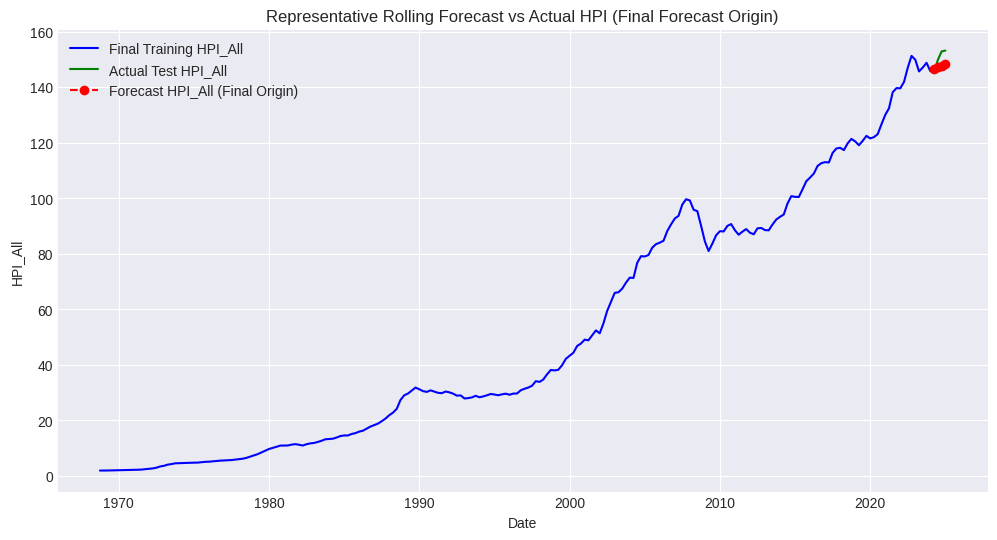

In [ ]:
# ---------------------------------------------------------------------
# Example usage:

# 'combined' should be your preprocessed quarterly DataFrame with "HPI_All" and "HPI_Diff",
# indexed by Date at a quarterly frequency (e.g., 'QE-DEC').

error_stats, aggregated_errors, final_model_summary = run_arima_pipeline(
    data=combined,
    arima_order=(1, 0, 1),
    forecast_horizon=4,
    init_train_frac=0.50,
    verbose=True
)

print("\nHorizon-specific error statistics:")
for horizon, stats in error_stats.items():
    print(f"Horizon {horizon}: MAE = {stats['MAE']:.4f}, MSE = {stats['MSE']:.4f}, RMSE = {stats['RMSE']:.4f}")

print("\nOverall aggregated error statistics:")
print(f"Overall MAE = {aggregated_errors['Overall_MAE']:.4f}, Overall RMSE = {aggregated_errors['Overall_RMSE']:.4f}")

if final_model_summary is not None:
    print("\nFinal iteration ARIMA(1,0,1) model summary:")
    print(final_model_summary)

# ---------------------------------------------------------------------
# Produce a representative plot from the final rolling split.
forecast_horizon = 4
final_origin = combined.index[len(combined) - forecast_horizon]
final_train = combined.loc[:final_origin]
final_test = combined.loc[final_origin : final_origin + pd.DateOffset(months=3*(forecast_horizon-1))]
last_train_value = final_train["HPI_All"].iloc[-1]
model_final = ARIMA(final_train["HPI_Diff"], order=(1, 0, 1))
result_final = model_final.fit()
forecast_diff_final = result_final.forecast(steps=forecast_horizon)
forecast_levels_final = last_train_value + forecast_diff_final.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(final_train.index, final_train["HPI_All"], label="Final Training HPI_All", color='blue')
plt.plot(final_test.index, final_test["HPI_All"], label="Actual Test HPI_All", color='green')
plt.plot(final_test.index, forecast_levels_final, label="Forecast HPI_All (Final Origin)", color='red', linestyle='--', marker='o')
plt.title("Representative Rolling Forecast vs Actual HPI (Final Forecast Origin)")
plt.xlabel("Date")
plt.ylabel("HPI_All")
plt.legend()
plt.grid(True)
plt.show()


## 16.04

In [ ]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress routine SARIMAX warnings during the grid search
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def run_arima_pipeline(data, arima_order=(1, 0, 1), forecast_horizon=4, init_train_frac=0.50):
    """
    Runs a fixed multi-step rolling forecast using an expanding window on the provided data.

    Returns only the aggregated error statistics across all horizons.
    """
    n = len(data)
    initial_train_size = max(int(n * init_train_frac), forecast_horizon + 1)

    all_forecasts = []
    all_actuals = []

    # Expanding-window rolling forecast
    for i in range(initial_train_size, n - forecast_horizon + 1):
        train = data.iloc[:i]
        test = data.iloc[i : i + forecast_horizon]

        last_level = train["HPI_All"].iloc[-1]
        try:
            model = ARIMA(train["HPI_Diff"], order=arima_order)
            res = model.fit()
            diff_fc = res.forecast(steps=forecast_horizon)
            level_fc = last_level + diff_fc.cumsum()
        except Exception:
            level_fc = pd.Series([np.nan] * forecast_horizon, index=test.index)

        all_forecasts.extend(level_fc.values)
        all_actuals.extend(test["HPI_All"].values)

    f = np.array(all_forecasts)
    a = np.array(all_actuals)
    valid = ~np.isnan(f)

    return {
        "Overall_MAE": mean_absolute_error(a[valid], f[valid]),
        "Overall_RMSE": np.sqrt(mean_squared_error(a[valid], f[valid]))
    }




In [ ]:
# ---------------------------------------------------------------------
# Grid search over ARIMA orders (p,0,q) and initial training fractions

p_values = [0, 1, 2]
q_values = [0, 1, 2]
init_fracs = [0.40, 0.50, 0.60]
forecast_horizon = 4

grid_results = []

for frac in init_fracs:
    for p in p_values:
        for q in q_values:
            errs = run_arima_pipeline(
                data=combined,
                arima_order=(p, 0, q),
                forecast_horizon=forecast_horizon,
                init_train_frac=frac
            )
            grid_results.append({
                "init_train_frac": frac,
                "order": (p, 0, q),
                "Overall_MAE": errs["Overall_MAE"],
                "Overall_RMSE": errs["Overall_RMSE"]
            })
            print(f"frac={frac}, order={(p,0,q)} → RMSE={errs['Overall_RMSE']:.4f}")

# Summarize results
grid_df = pd.DataFrame(grid_results)
print("\nGrid Search Summary:")
print(grid_df[["init_train_frac", "order", "Overall_MAE", "Overall_RMSE"]])

frac=0.4, order=(0, 0, 0) → RMSE=3.7891
frac=0.4, order=(0, 0, 1) → RMSE=3.6632
frac=0.4, order=(0, 0, 2) → RMSE=3.6771
frac=0.4, order=(1, 0, 0) → RMSE=3.6507
frac=0.4, order=(1, 0, 1) → RMSE=3.7951
frac=0.4, order=(1, 0, 2) → RMSE=3.8325
frac=0.4, order=(2, 0, 0) → RMSE=3.6940
frac=0.4, order=(2, 0, 1) → RMSE=3.7659
frac=0.4, order=(2, 0, 2) → RMSE=3.7857
frac=0.5, order=(0, 0, 0) → RMSE=4.1370
frac=0.5, order=(0, 0, 1) → RMSE=3.9990
frac=0.5, order=(0, 0, 2) → RMSE=4.0140
frac=0.5, order=(1, 0, 0) → RMSE=3.9881
frac=0.5, order=(1, 0, 1) → RMSE=4.1453
frac=0.5, order=(1, 0, 2) → RMSE=4.1900
frac=0.5, order=(2, 0, 0) → RMSE=4.0353
frac=0.5, order=(2, 0, 1) → RMSE=4.1138
frac=0.5, order=(2, 0, 2) → RMSE=4.1388
frac=0.6, order=(0, 0, 0) → RMSE=4.3234
frac=0.6, order=(0, 0, 1) → RMSE=4.1617
frac=0.6, order=(0, 0, 2) → RMSE=4.1839
frac=0.6, order=(1, 0, 0) → RMSE=4.1755
frac=0.6, order=(1, 0, 1) → RMSE=4.4327
frac=0.6, order=(1, 0, 2) → RMSE=4.4797
frac=0.6, order=(2, 0, 0) → RMSE=4.2446


Evaluating top 4 arimas


=== ARIMA(1, 0, 0), init_frac=0.4 ===
Horizon-specific errors:
  h=1: MAE=1.2780, RMSE=1.7406
  h=2: MAE=2.4133, RMSE=3.2075
  h=3: MAE=3.0723, RMSE=4.1201
  h=4: MAE=3.4182, RMSE=4.7978

Aggregated: MAE=2.5455, RMSE=3.6507

Final iteration model summary:
                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  222
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -381.633
Date:                Wed, 16 Apr 2025   AIC                            769.267
Time:                        18:32:59   BIC                            779.475
Sample:                    09-30-1968   HQIC                           773.388
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


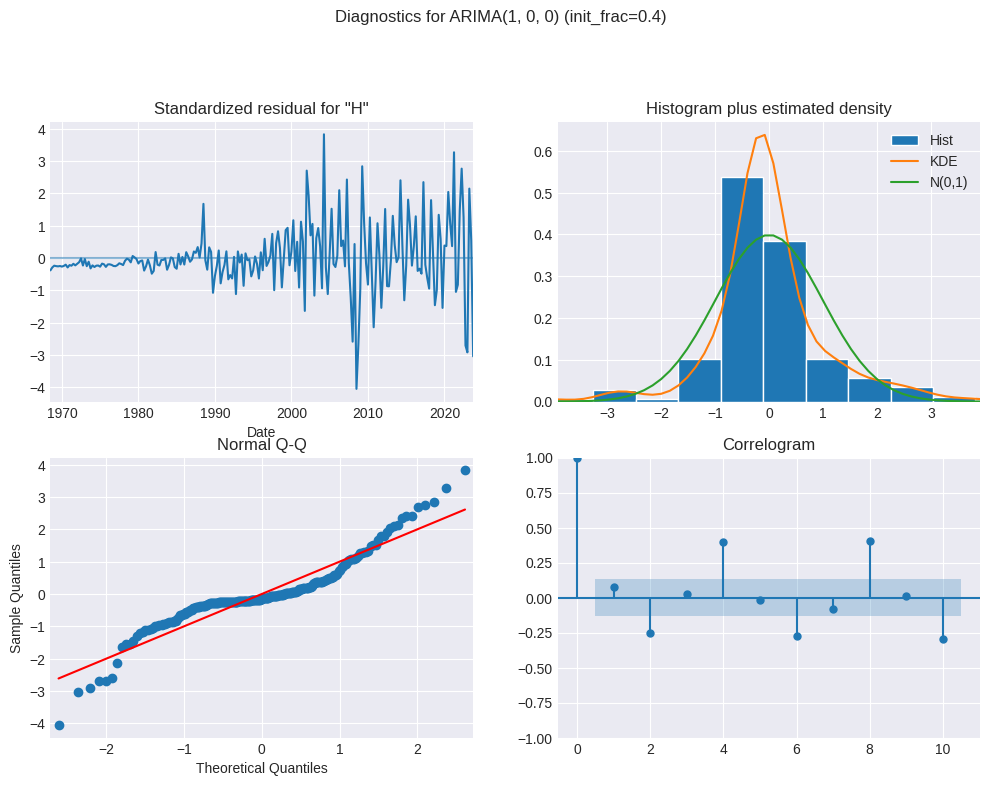


=== ARIMA(0, 0, 1), init_frac=0.4 ===
Horizon-specific errors:
  h=1: MAE=1.2317, RMSE=1.7021
  h=2: MAE=2.2931, RMSE=3.1288
  h=3: MAE=3.0631, RMSE=4.1110
  h=4: MAE=3.6741, RMSE=4.9081

Aggregated: MAE=2.5655, RMSE=3.6632

Final iteration model summary:
                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  222
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -377.238
Date:                Wed, 16 Apr 2025   AIC                            760.476
Time:                        18:33:21   BIC                            770.684
Sample:                    09-30-1968   HQIC                           764.598
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

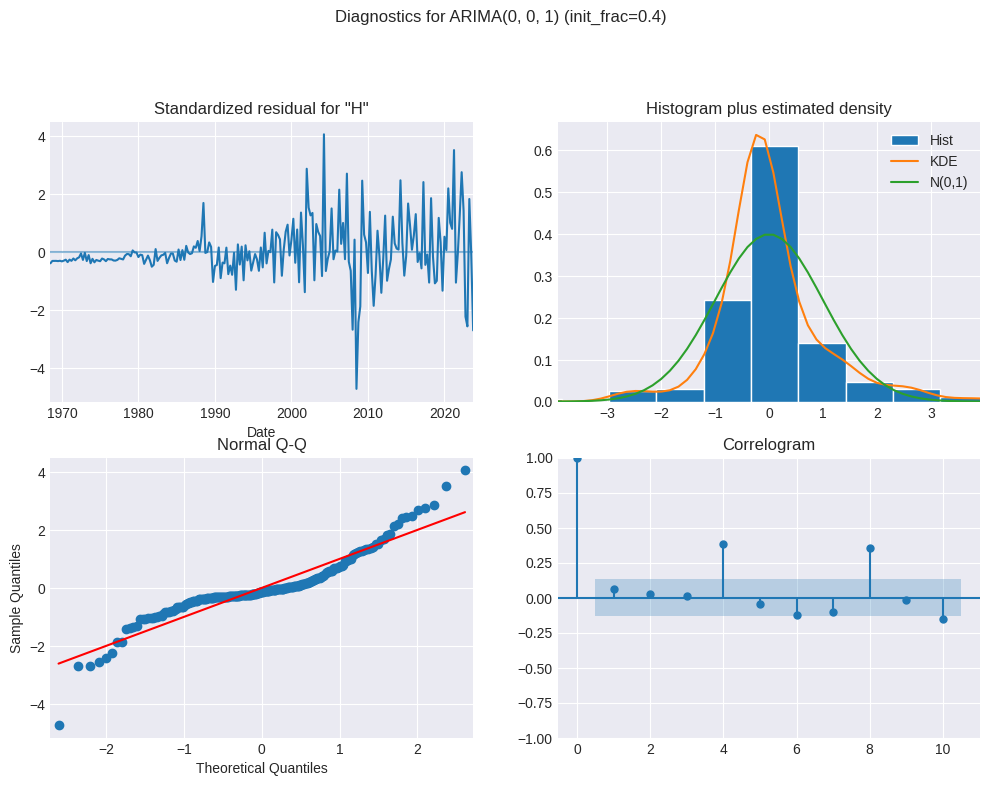


=== ARIMA(0, 0, 2), init_frac=0.4 ===
Horizon-specific errors:
  h=1: MAE=1.2501, RMSE=1.7192
  h=2: MAE=2.4127, RMSE=3.1981
  h=3: MAE=3.1339, RMSE=4.1557
  h=4: MAE=3.5977, RMSE=4.8613

Aggregated: MAE=2.5986, RMSE=3.6771

Final iteration model summary:
                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  222
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -375.689
Date:                Wed, 16 Apr 2025   AIC                            759.379
Time:                        18:33:38   BIC                            772.990
Sample:                    09-30-1968   HQIC                           764.874
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

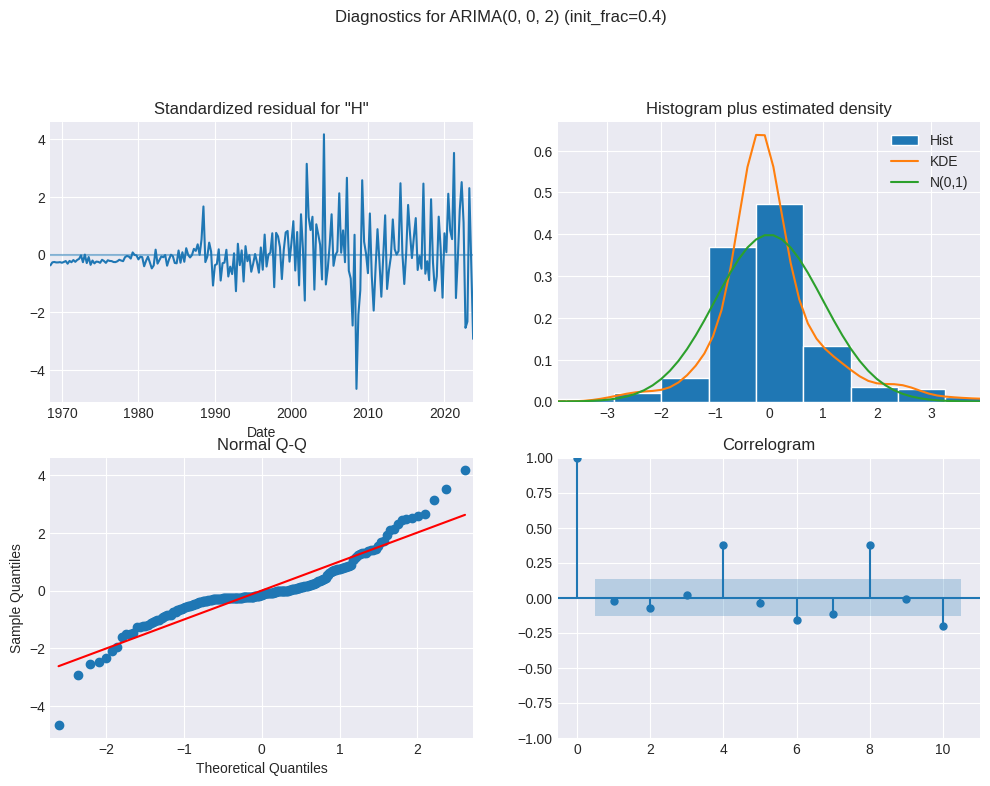


=== ARIMA(2, 0, 0), init_frac=0.4 ===
Horizon-specific errors:
  h=1: MAE=1.2591, RMSE=1.7460
  h=2: MAE=2.4345, RMSE=3.2266
  h=3: MAE=3.0740, RMSE=4.1690
  h=4: MAE=3.4577, RMSE=4.8727

Aggregated: MAE=2.5563, RMSE=3.6940

Final iteration model summary:
                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  222
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -378.118
Date:                Wed, 16 Apr 2025   AIC                            764.236
Time:                        18:33:55   BIC                            777.847
Sample:                    09-30-1968   HQIC                           769.731
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

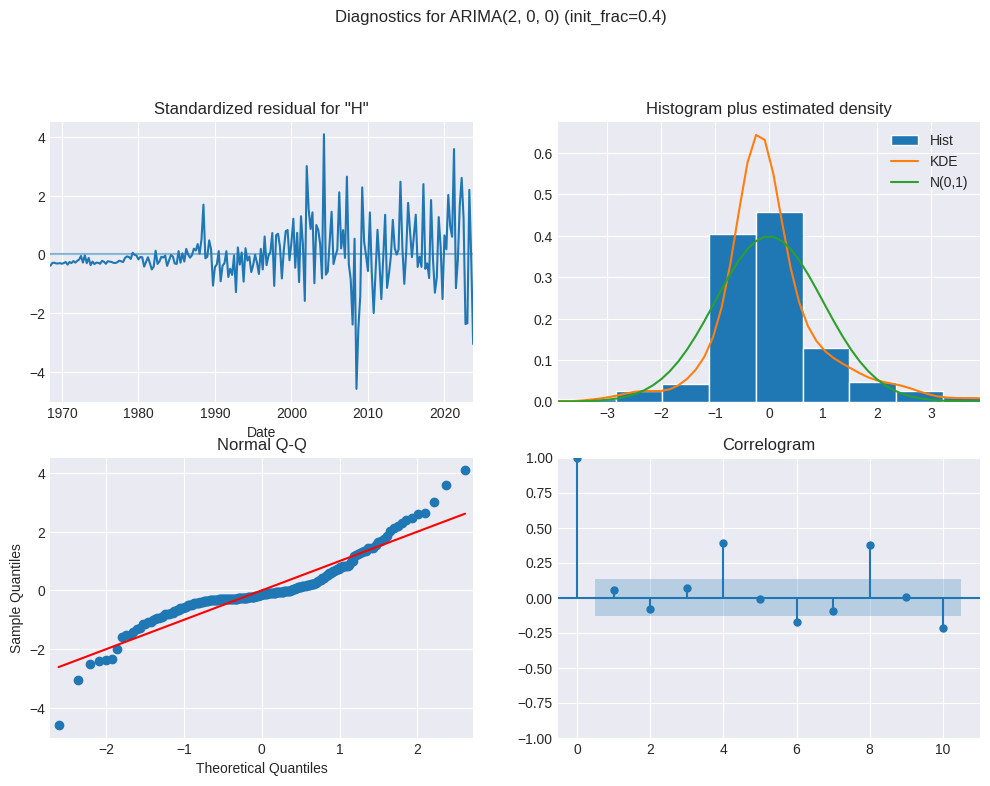

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Re‑enable all warnings so you see real issues during these final runs
warnings.resetwarnings()

def full_arima_diagnostics(data, arima_order, init_train_frac, forecast_horizon=4):
    n = len(data)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)

    # Containers
    preds = {h: [] for h in range(1, forecast_horizon+1)}
    acts  = {h: [] for h in range(1, forecast_horizon+1)}
    final_summary = None

    # Rolling forecast
    for i in range(init_n, n - forecast_horizon + 1):
        train = data.iloc[:i]
        test  = data.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        try:
            m = ARIMA(train["HPI_Diff"], order=arima_order).fit()
            diff_fc = m.forecast(steps=forecast_horizon)
            lvl_fc  = last_level + diff_fc.cumsum()
        except Exception as e:
            print(f"  [warning] ARIMA{arima_order} at split {i} failed: {e}")
            lvl_fc = pd.Series([np.nan]*forecast_horizon, index=test.index)

        # store
        for h in range(1, forecast_horizon+1):
            preds[h].append(lvl_fc.iloc[h-1])
            acts[h].append(test["HPI_All"].iloc[h-1])

        # final iteration summary
        if i == n - forecast_horizon:
            final_summary = m.summary().as_text()

    # compute errors
    print(f"\n=== ARIMA{arima_order}, init_frac={init_train_frac} ===")
    all_fc = []
    all_ac = []
    print("Horizon-specific errors:")
    for h in range(1, forecast_horizon+1):
        f = np.array(preds[h])
        a = np.array(acts[h])
        valid = ~np.isnan(f)
        mae = mean_absolute_error(a[valid], f[valid])
        rmse = np.sqrt(mean_squared_error(a[valid], f[valid]))
        print(f"  h={h}: MAE={mae:.4f}, RMSE={rmse:.4f}")
        all_fc.extend(f[valid])
        all_ac.extend(a[valid])

    overall_mae  = mean_absolute_error(all_ac, all_fc)
    overall_rmse = np.sqrt(mean_squared_error(all_ac, all_fc))
    print(f"\nAggregated: MAE={overall_mae:.4f}, RMSE={overall_rmse:.4f}")

    print("\nFinal iteration model summary:")
    print(final_summary)

    # Residual diagnostics on the last training window
    last_train_end = n - forecast_horizon
    train_final = data.iloc[:last_train_end]
    m_final = ARIMA(train_final["HPI_Diff"], order=arima_order).fit()
    m_final.plot_diagnostics(figsize=(12, 8))
    plt.suptitle(f"Diagnostics for ARIMA{arima_order} (init_frac={init_train_frac})", y=1.02)
    plt.show()

# ---------------------------------------------------------------------
# Now pick your top‑4 from grid_df and run diagnostics:

top4 = grid_df.nsmallest(4, "Overall_RMSE")

for _, row in top4.iterrows():
    full_arima_diagnostics(
        data=combined,
        arima_order=row["order"],
        init_train_frac=row["init_train_frac"],
        forecast_horizon=4
    )


bagged arima

Bagging B=10 origins:   0%|          | 0/133 [00:00<?, ?it/s]


--- Bagged ARIMA(1,0,0), B=10 ---
 h=1: MAE=1.3248, RMSE=1.8126
 h=2: MAE=2.4678, RMSE=3.3032
 h=3: MAE=3.0404, RMSE=4.1820
 h=4: MAE=3.3782, RMSE=4.8777
 Overall MAE=2.5528, RMSE=3.7242


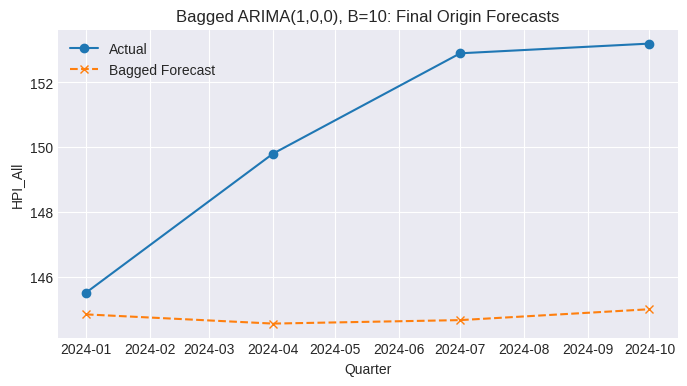

Bagging B=20 origins:   0%|          | 0/133 [00:00<?, ?it/s]


--- Bagged ARIMA(1,0,0), B=20 ---
 h=1: MAE=1.3082, RMSE=1.7749
 h=2: MAE=2.3949, RMSE=3.1986
 h=3: MAE=2.9840, RMSE=4.0920
 h=4: MAE=3.3245, RMSE=4.8381
 Overall MAE=2.5029, RMSE=3.6583


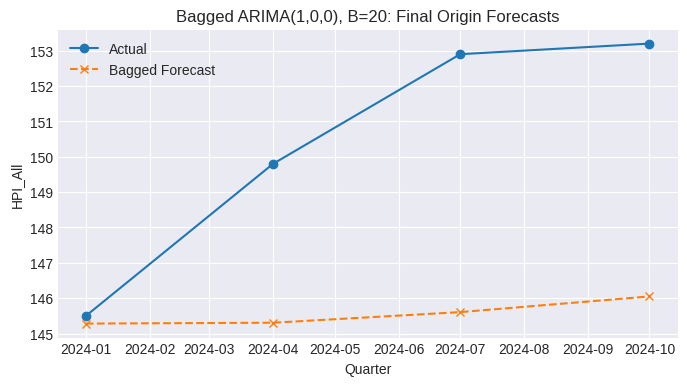

Bagging B=50 origins:   0%|          | 0/133 [00:00<?, ?it/s]


--- Bagged ARIMA(1,0,0), B=50 ---
 h=1: MAE=1.3048, RMSE=1.7775
 h=2: MAE=2.3537, RMSE=3.1733
 h=3: MAE=2.9275, RMSE=4.0412
 h=4: MAE=3.2931, RMSE=4.7848
 Overall MAE=2.4698, RMSE=3.6213


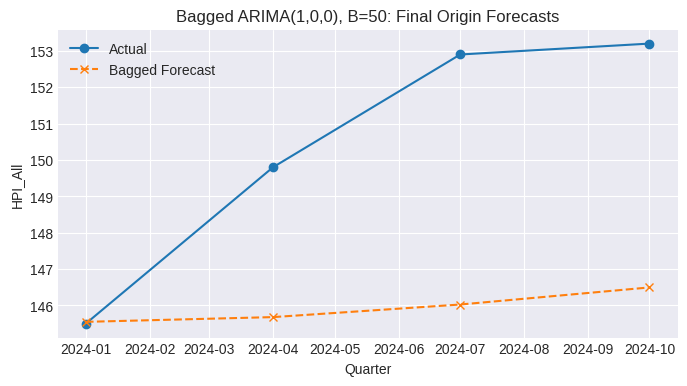

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# suppress convergence warnings during bagging
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
from tqdm.auto import tqdm   # progress bar
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def run_bagged_arima(data,
                     arima_order=(1,0,0),
                     forecast_horizon=4,
                     init_train_frac=0.4,
                     B=20):
    """
    Bagged ARIMA pipeline: expanding window + B bootstrap replicates per origin.
    Returns:
      - error_stats: per‑horizon MAE/RMSE
      - aggregated: overall MAE/RMSE
      - final_dates: PeriodIndex of the final origin’s test quarters
      - final_fc: numpy array of the final origin’s averaged forecasts
      - final_act: numpy array of the final origin’s actual HPI_All values
    """
    n = len(data)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)

    preds = {h: [] for h in range(1, forecast_horizon + 1)}
    acts  = {h: [] for h in range(1, forecast_horizon + 1)}
    final_fc = final_act = final_dates = None

    for i in tqdm(range(init_n, n - forecast_horizon + 1), desc=f"Bagging B={B} origins"):
        train = data.iloc[:i]
        test  = data.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        bag_fc = np.zeros((B, forecast_horizon))
        for b in range(B):
            idx = np.random.choice(train.index, size=len(train), replace=True)
            bt = train.loc[idx].sort_index()
            m = ARIMA(bt["HPI_Diff"], order=arima_order).fit()
            fc_diff = m.forecast(steps=forecast_horizon)
            bag_fc[b, :] = last_level + np.cumsum(fc_diff.values)

        avg_fc = bag_fc.mean(axis=0)

        for h in range(1, forecast_horizon + 1):
            preds[h].append(avg_fc[h - 1])
            acts[h].append(test["HPI_All"].iloc[h - 1])

        # capture final origin
        if i == n - forecast_horizon:
            final_dates = test.index
            final_fc = avg_fc.copy()
            final_act = test["HPI_All"].values

    # compute errors
    error_stats = {}
    all_f, all_a = [], []
    for h in range(1, forecast_horizon + 1):
        f = np.array(preds[h])
        a = np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f))
        }
        all_f.extend(f)
        all_a.extend(a)

    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act

# -----------------------------------------------------------
# Prepare the index as a quarterly PeriodIndex if needed
if not isinstance(combined.index, pd.PeriodIndex):
    try:
        dt_index = pd.to_datetime(combined.index)
    except TypeError:
        dt_index = combined.index.to_timestamp()
    combined.index = pd.PeriodIndex(dt_index, freq="Q")

# Run and plot for various B
for B in [10, 20, 50]:
    errs, agg, f_dates, f_fc, f_act = run_bagged_arima(
        data=combined,
        arima_order=(1,0,0),
        forecast_horizon=4,
        init_train_frac=0.4,
        B=B
    )

    print(f"\n--- Bagged ARIMA(1,0,0), B={B} ---")
    for h, stats in errs.items():
        print(f" h={h}: MAE={stats['MAE']:.4f}, RMSE={stats['RMSE']:.4f}")
    print(f" Overall MAE={agg['Overall_MAE']:.4f}, RMSE={agg['Overall_RMSE']:.4f}")

    # convert PeriodIndex to timestamp for plotting
    plot_dates = f_dates.to_timestamp()

    plt.figure(figsize=(8,4))
    plt.plot(plot_dates, f_act, marker='o', label="Actual")
    plt.plot(plot_dates, f_fc, marker='x', linestyle='--', label="Bagged Forecast")
    plt.title(f"Bagged ARIMA(1,0,0), B={B}: Final Origin Forecasts")
    plt.xlabel("Quarter")
    plt.ylabel("HPI_All")
    plt.legend()
    plt.show()


Bagging B=100 origins:   0%|          | 0/133 [00:00<?, ?it/s]


--- Bagged ARIMA(1,0,0), B=100 ---
 h=1: MAE=1.3003, RMSE=1.7805
 h=2: MAE=2.3715, RMSE=3.1964
 h=3: MAE=2.9741, RMSE=4.0899
 h=4: MAE=3.3252, RMSE=4.8371
 Overall MAE=2.4928, RMSE=3.6576


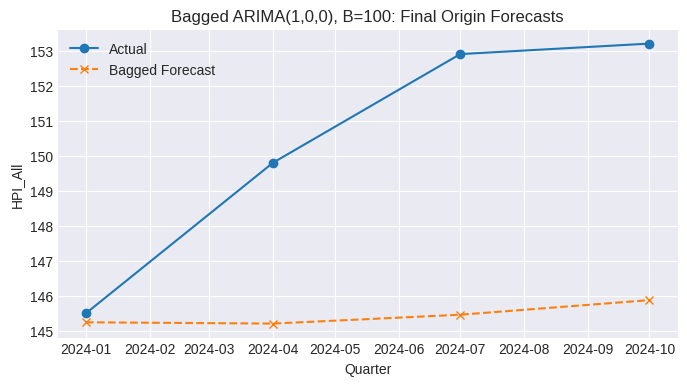

Bagging B=300 origins:   0%|          | 0/133 [00:00<?, ?it/s]


--- Bagged ARIMA(1,0,0), B=300 ---
 h=1: MAE=1.3148, RMSE=1.7866
 h=2: MAE=2.3713, RMSE=3.1963
 h=3: MAE=2.9660, RMSE=4.0743
 h=4: MAE=3.3167, RMSE=4.8157
 Overall MAE=2.4922, RMSE=3.6469


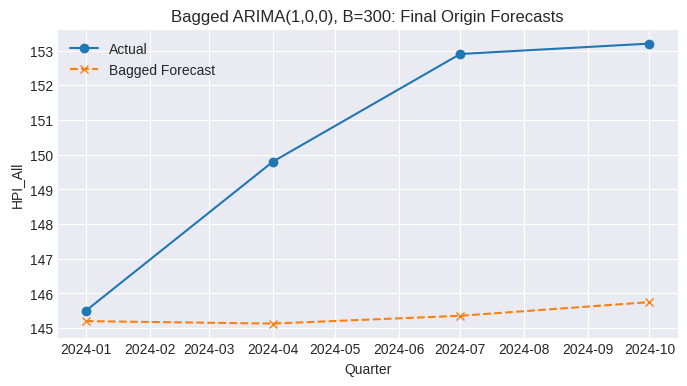

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# suppress convergence warnings during bagging
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
from tqdm.auto import tqdm   # progress bar
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def run_bagged_arima(data,
                     arima_order=(1,0,0),
                     forecast_horizon=4,
                     init_train_frac=0.4,
                     B=20):
    """
    Bagged ARIMA pipeline: expanding window + B bootstrap replicates per origin.
    Returns:
      - error_stats: per‑horizon MAE/RMSE
      - aggregated: overall MAE/RMSE
      - final_dates: PeriodIndex of the final origin’s test quarters
      - final_fc: numpy array of the final origin’s averaged forecasts
      - final_act: numpy array of the final origin’s actual HPI_All values
    """
    n = len(data)
    init_n = max(int(n * init_train_frac), forecast_horizon + 1)

    preds = {h: [] for h in range(1, forecast_horizon + 1)}
    acts  = {h: [] for h in range(1, forecast_horizon + 1)}
    final_fc = final_act = final_dates = None

    for i in tqdm(range(init_n, n - forecast_horizon + 1), desc=f"Bagging B={B} origins"):
        train = data.iloc[:i]
        test  = data.iloc[i : i + forecast_horizon]
        last_level = train["HPI_All"].iloc[-1]

        bag_fc = np.zeros((B, forecast_horizon))
        for b in range(B):
            idx = np.random.choice(train.index, size=len(train), replace=True)
            bt = train.loc[idx].sort_index()
            m = ARIMA(bt["HPI_Diff"], order=arima_order).fit()
            fc_diff = m.forecast(steps=forecast_horizon)
            bag_fc[b, :] = last_level + np.cumsum(fc_diff.values)

        avg_fc = bag_fc.mean(axis=0)

        for h in range(1, forecast_horizon + 1):
            preds[h].append(avg_fc[h - 1])
            acts[h].append(test["HPI_All"].iloc[h - 1])

        # capture final origin
        if i == n - forecast_horizon:
            final_dates = test.index
            final_fc = avg_fc.copy()
            final_act = test["HPI_All"].values

    # compute errors
    error_stats = {}
    all_f, all_a = [], []
    for h in range(1, forecast_horizon + 1):
        f = np.array(preds[h])
        a = np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f))
        }
        all_f.extend(f)
        all_a.extend(a)

    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    return error_stats, aggregated, final_dates, final_fc, final_act

# -----------------------------------------------------------
# Prepare the index as a quarterly PeriodIndex if needed
if not isinstance(combined.index, pd.PeriodIndex):
    try:
        dt_index = pd.to_datetime(combined.index)
    except TypeError:
        dt_index = combined.index.to_timestamp()
    combined.index = pd.PeriodIndex(dt_index, freq="Q")

# Run and plot for various B
for B in [100, 300]:
    errs, agg, f_dates, f_fc, f_act = run_bagged_arima(
        data=combined,
        arima_order=(1,0,0),
        forecast_horizon=4,
        init_train_frac=0.4,
        B=B
    )

    print(f"\n--- Bagged ARIMA(1,0,0), B={B} ---")
    for h, stats in errs.items():
        print(f" h={h}: MAE={stats['MAE']:.4f}, RMSE={stats['RMSE']:.4f}")
    print(f" Overall MAE={agg['Overall_MAE']:.4f}, RMSE={agg['Overall_RMSE']:.4f}")

    # convert PeriodIndex to timestamp for plotting
    plot_dates = f_dates.to_timestamp()

    plt.figure(figsize=(8,4))
    plt.plot(plot_dates, f_act, marker='o', label="Actual")
    plt.plot(plot_dates, f_fc, marker='x', linestyle='--', label="Bagged Forecast")
    plt.title(f"Bagged ARIMA(1,0,0), B={B}: Final Origin Forecasts")
    plt.xlabel("Quarter")
    plt.ylabel("HPI_All")
    plt.legend()
    plt.show()


end of 16.04.2025

ARIMA Modeling

                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  203
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -311.847
Date:                Mon, 14 Apr 2025   AIC                            635.693
Time:                        19:36:43   BIC                            655.572
Sample:                    09-30-1968   HQIC                           643.736
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5757      0.141      4.069      0.000       0.298       0.853
ar.L1         -0.7289      0.103     -7.096      0.000      -0.930      -0.528
ar.L2         -0.0844      0.086     -0.977      0.3

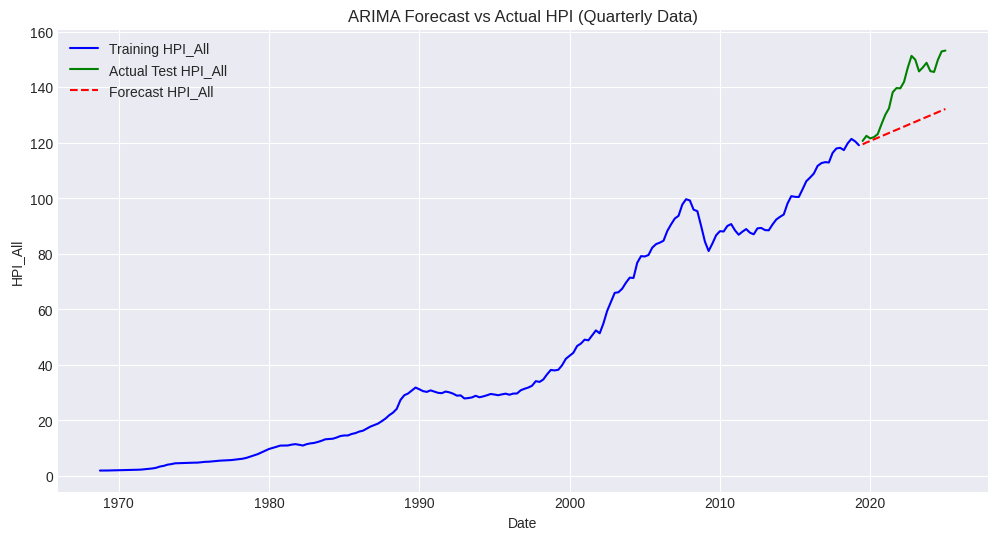

Error Statistics:
MAE: 13.1089
MSE: 231.4646
RMSE: 15.2140


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Document: Capture the last HPI_All value from the training set to invert differencing.
last_train_value = train["HPI_All"].iloc[-1]

# ---------------- Step 7: Fit ARIMA on Training Data ----------------
# The series is already differenced, so we use d=0.
arima_model = ARIMA(train["HPI_Diff"], order=(2, 0, 2))
model_fit = arima_model.fit()
print(model_fit.summary())

# ---------------- Step 8: Forecast Over the Test Period ----------------
# Forecast as many steps ahead as the length of the test set.
n_forecast = len(test)
forecast_diff = model_fit.forecast(steps=n_forecast)

# ==================== INVERT DIFFERENCING TO OBTAIN LEVEL FORECAST ====================
# Recover forecasted HPI levels by cumulatively summing the forecasted differences and adding the last training HPI level.
forecast_levels = last_train_value + forecast_diff.cumsum()

# ---------------- Step 9: Plot the Results ----------------
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["HPI_All"], label="Training HPI_All", color='blue')
plt.plot(test.index, test["HPI_All"], label="Actual Test HPI_All", color='green')
plt.plot(test.index, forecast_levels, label="Forecast HPI_All", color='red', linestyle='--')
plt.title("ARIMA Forecast vs Actual HPI (Quarterly Data)")
plt.xlabel("Date")
plt.ylabel("HPI_All")
plt.legend()
plt.grid(True)
plt.show()

# ---------------- Step 10: Compute and Display Error Statistics ----------------
mae = mean_absolute_error(test["HPI_All"], forecast_levels)
mse = mean_squared_error(test["HPI_All"], forecast_levels)
rmse = np.sqrt(mse)

print("Error Statistics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


                               SARIMAX Results                                
Dep. Variable:               HPI_Diff   No. Observations:                  673
Model:                 ARIMA(2, 0, 2)   Log Likelihood                   0.000
Date:                Mon, 14 Apr 2025   AIC                             12.000
Time:                        19:37:06   BIC                             39.070
Sample:                    09-30-1968   HQIC                            22.483
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0         -0        nan        nan           0           0
ar.L1              -0         -0        nan        nan           0          -0
ar.L2               0         -0        nan        n

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

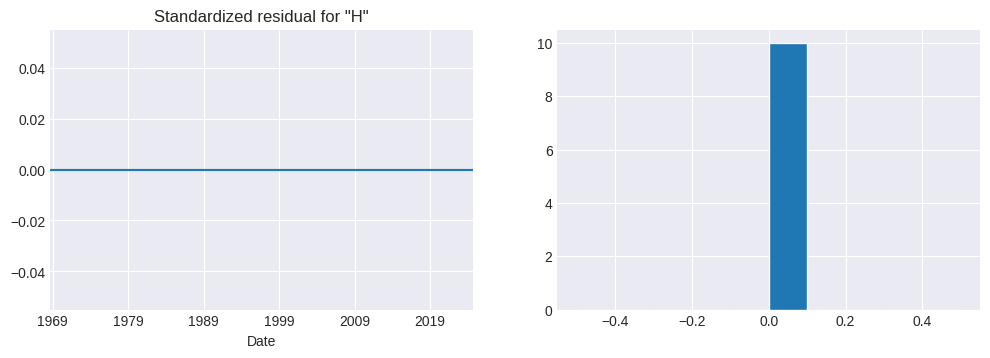

In [ ]:



# Fit the ARIMA(2,0,2) model on properly indexed data
model_arima_alt = ARIMA(hpi_diff_final["HPI_Diff"], order=(2, 0, 2))
model_fit_alt = model_arima_alt.fit()

# Display summary
print(model_fit_alt.summary())

# Residual diagnostics plots
model_fit_alt.plot_diagnostics(figsize=(12, 8))
plt.show()


In [ ]:


# Splitting the data (80% training, 20% testing)
train_size = int(len(hpi_diff_final) * 0.8)
train, test = hpi_diff_final["HPI_Diff"].iloc[:train_size], hpi_diff_final["HPI_Diff"].iloc[train_size:]

# Fit ARIMA(2,0,2) model
from statsmodels.tsa.arima.model import ARIMA
model_arima_202 = ARIMA(train, order=(2, 0, 2)).fit()

# Forecast differenced values
forecast_diff = model_arima_202.forecast(steps=len(test))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [ ]:
# Get the last actual HPI value from training set (before differencing)
last_train_hpi = hpi_diff_final["HPI_All"].iloc[train_size - 1]

# Inverse differencing to original HPI values
forecast_hpi = forecast_diff.cumsum() + last_train_hpi

# Actual HPI test values for direct comparison
actual_hpi_test = hpi_diff_final["HPI_All"].iloc[train_size:]


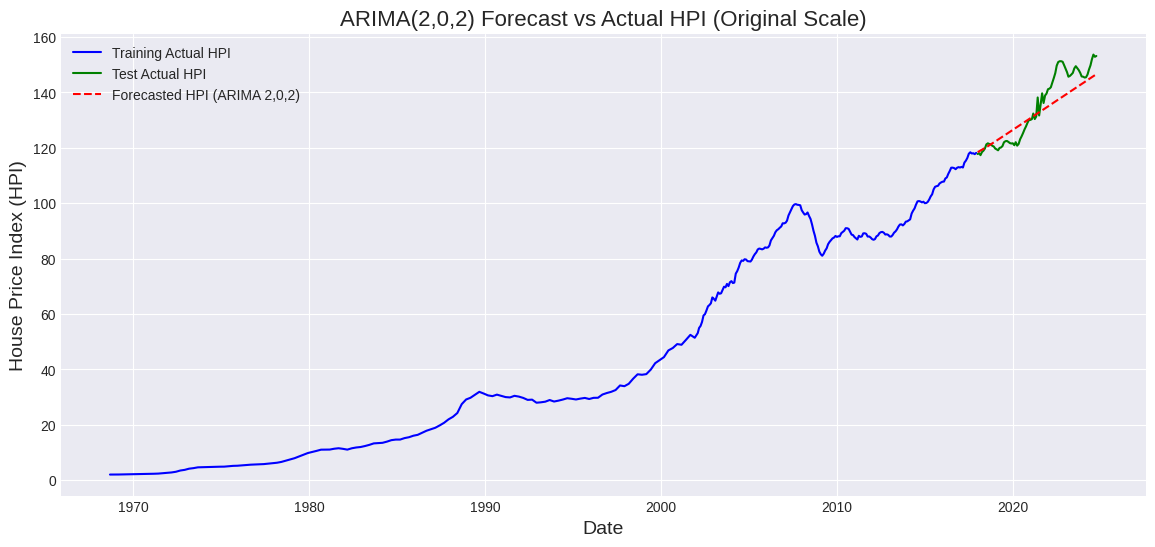

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(hpi_diff_final.index[:train_size], hpi_diff_final["HPI_All"].iloc[:train_size],
         label='Training Actual HPI', color='blue')
plt.plot(actual_hpi_test.index, actual_hpi_test,
         label='Test Actual HPI', color='green')
plt.plot(actual_hpi_test.index, forecast_hpi,
         label='Forecasted HPI (ARIMA 2,0,2)', color='red', linestyle='--')

plt.title('ARIMA(2,0,2) Forecast vs Actual HPI (Original Scale)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('House Price Index (HPI)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_original_scale = np.sqrt(mean_squared_error(actual_hpi_test, forecast_hpi))
mae_original_scale = mean_absolute_error(actual_hpi_test, forecast_hpi)

print(f"RMSE on Original Scale: {rmse_original_scale:.3f}")
print(f"MAE on Original Scale: {mae_original_scale:.3f}")


RMSE on Original Scale: 5.633
MAE on Original Scale: 4.498


----


##Adding External variables

In [ ]:
# First, clearly loading and inspecting external macroeconomic indicators data
import pandas as pd

# Load datasets clearly
interest_rates = pd.read_csv("/content/drive/MyDrive/thesis data/IRLTLT01GBM156N.csv")
cpi_inflation = pd.read_csv("/content/drive/MyDrive/thesis data/GBRCPALTT01IXNBM.csv")
unemployment = pd.read_csv("/content/drive/MyDrive/thesis data/AURUKM.csv")

# Check initial rows clearly to understand their structure
interest_rates.head(), cpi_inflation.head(), unemployment.head()


(  observation_date  IRLTLT01GBM156N
 0       1960-01-01             5.33
 1       1960-02-01             5.40
 2       1960-03-01             5.59
 3       1960-04-01             5.67
 4       1960-05-01             5.69,
   observation_date  GBRCPALTT01IXNBM
 0       1960-01-01          5.611997
 1       1960-02-01          5.611997
 2       1960-03-01          5.601784
 3       1960-04-01          5.632423
 4       1960-05-01          5.632423,
   observation_date  AURUKM
 0       1956-01-01    1.55
 1       1956-02-01    1.56
 2       1956-03-01    1.57
 3       1956-04-01    1.58
 4       1956-05-01    1.59)

In [ ]:
# Corrected and clear preprocessing and alignment of external datasets
import pandas as pd

# Load datasets clearly
interest_rates = pd.read_csv("/content/drive/MyDrive/thesis data/IRLTLT01GBM156N.csv")
cpi_inflation = pd.read_csv("/content/drive/MyDrive/thesis data/GBRCPALTT01IXNBM.csv")
unemployment = pd.read_csv("/content/drive/MyDrive/thesis data/AURUKM.csv")

# Convert dates to datetime and rename columns clearly
interest_rates.rename(columns={'observation_date': 'Date', 'IRLTLT01GBM156N': 'Interest_Rate'}, inplace=True)
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'])

cpi_inflation.rename(columns={'observation_date': 'Date', 'GBRCPALTT01IXNBM': 'CPI'}, inplace=True)
cpi_inflation['Date'] = pd.to_datetime(cpi_inflation['Date'])

unemployment.rename(columns={'observation_date': 'Date', 'AURUKM': 'Unemployment'}, inplace=True)
unemployment['Date'] = pd.to_datetime(unemployment['Date'])

# Merge datasets clearly by 'Date'
external_data = interest_rates.merge(cpi_inflation, on='Date', how='inner')
external_data = external_data.merge(unemployment, on='Date', how='inner')

# Align dataset to match the HPI dataset timeframe (1968-2024)
start_date = pd.Timestamp("1968-01-01")
end_date = pd.Timestamp("2024-11-01")
external_data_aligned = external_data[(external_data['Date'] >= start_date) & (external_data['Date'] <= end_date)].copy()


external_data_aligned.head()


Date  Interest_Rate       CPI  Unemployment
96  1968-01-01           7.30  7.296107          3.49
97  1968-02-01           7.27  7.332107          3.53
98  1968-03-01           7.30  7.356108          3.49
99  1968-04-01           7.27  7.488109          3.52
100 1968-05-01           7.36  7.494110          3.52

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


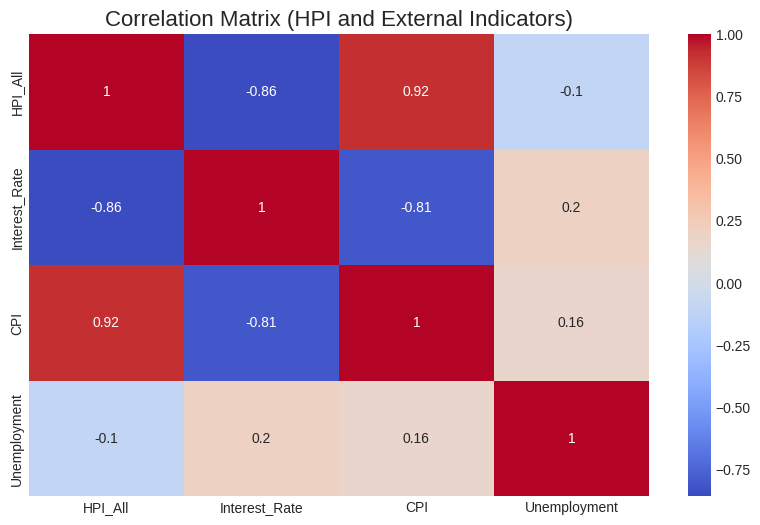

                HPI_All  Interest_Rate       CPI  Unemployment
HPI_All        1.000000      -0.856776  0.918778     -0.102029
Interest_Rate -0.856776       1.000000 -0.811662      0.200667
CPI            0.918778      -0.811662  1.000000      0.158920
Unemployment  -0.102029       0.200667  0.158920      1.000000


In [ ]:
# Load datasets clearly
interest_rates = pd.read_csv("/content/drive/MyDrive/thesis data/IRLTLT01GBM156N.csv")
cpi_inflation = pd.read_csv("/content/drive/MyDrive/thesis data/GBRCPALTT01IXNBM.csv")
unemployment = pd.read_csv("/content/drive/MyDrive/thesis data/AURUKM.csv")

# Preprocess external data (rename columns, convert dates)
interest_rates.rename(columns={'observation_date': 'Date', 'IRLTLT01GBM156N': 'Interest_Rate'}, inplace=True)
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'])

cpi_inflation.rename(columns={'observation_date': 'Date', 'GBRCPALTT01IXNBM': 'CPI'}, inplace=True)
cpi_inflation['Date'] = pd.to_datetime(cpi_inflation['Date'])

unemployment.rename(columns={'observation_date': 'Date', 'AURUKM': 'Unemployment'}, inplace=True)
unemployment['Date'] = pd.to_datetime(unemployment['Date'])

# Merge external indicators by Date
external_data = interest_rates.merge(cpi_inflation, on='Date').merge(unemployment, on='Date')

# Align external data with HPI dataset timeframe
start_date = pd.Timestamp("1968-01-01")
end_date = pd.Timestamp("2024-11-01")
external_data_aligned = external_data[(external_data['Date'] >= start_date) & (external_data['Date'] <= end_date)].copy()

# Merge clearly with HPI dataset
merged_data = hpi_data.merge(external_data_aligned, on='Date', how='inner')

# Calculate and visualize correlation matrix
import seaborn as sns

correlation_matrix = merged_data[['HPI_All', 'Interest_Rate', 'CPI', 'Unemployment']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (HPI and External Indicators)', fontsize=16)
plt.show()

# Clearly print correlation values
print(correlation_matrix)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


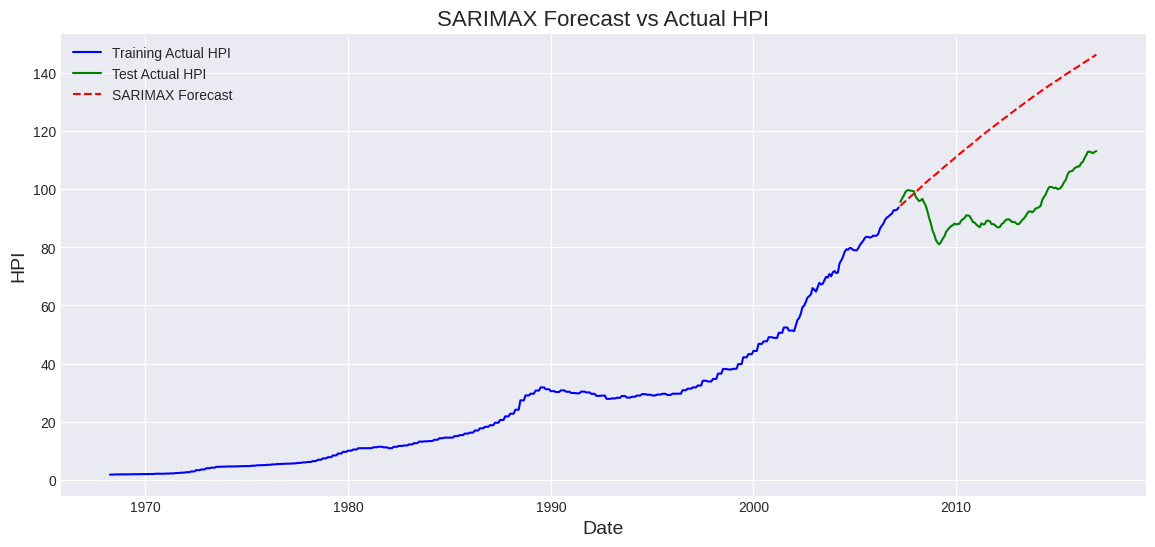

SARIMAX RMSE: 30.153
SARIMAX MAE: 27.820


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Set Date as index clearly
merged_data.set_index('Date', inplace=True)

# Define training and testing data clearly (80-20 split)
train_size = int(len(merged_data) * 0.8)

# Define endogenous (HPI) and exogenous variables (Interest Rate & CPI)
endog = merged_data["HPI_All"]
exog = merged_data[["Interest_Rate", "CPI"]]

train_endog, test_endog = endog.iloc[:train_size], endog.iloc[train_size:]
train_exog, test_exog = exog.iloc[:train_size], exog.iloc[train_size:]

# Fit SARIMAX model (order (2,1,2) as a starting point, can adjust later)
model_sarimax = SARIMAX(train_endog, exog=train_exog, order=(2,1,2)).fit()

# Generate SARIMAX forecasts
sarimax_forecast = model_sarimax.predict(start=test_endog.index[0],
                                         end=test_endog.index[-1],
                                         exog=test_exog)

# Plotting SARIMAX Forecast vs Actual
plt.figure(figsize=(14, 6))
plt.plot(train_endog.index, train_endog, label='Training Actual HPI', color='blue')
plt.plot(test_endog.index, test_endog, label='Test Actual HPI', color='green')
plt.plot(test_endog.index, sarimax_forecast, label='SARIMAX Forecast', color='red', linestyle='--')

plt.title('SARIMAX Forecast vs Actual HPI', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('HPI', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# SARIMAX performance metrics (RMSE, MAE)
import numpy as np

sarimax_rmse = np.sqrt(mean_squared_error(test_endog, sarimax_forecast))
sarimax_mae = mean_absolute_error(test_endog, sarimax_forecast)

print(f'SARIMAX RMSE: {sarimax_rmse:.3f}')
print(f'SARIMAX MAE: {sarimax_mae:.3f}')


## Trying neural networks

In [ ]:
merged_data


HPI_All  Interest_Rate         CPI  Unemployment
Date                                                        
1968-04-01     1.89         7.2700    7.488109          3.52
1968-05-01     1.89         7.3600    7.494110          3.52
1968-06-01     1.89         7.6100    7.524110          3.51
1968-07-01     1.95         7.6900    7.530110          3.51
1968-08-01     1.95         7.5500    7.542110          3.47
...             ...            ...         ...           ...
2016-08-01   112.84         0.7421  101.200000          4.80
2016-09-01   112.67         0.8243  101.500000          4.80
2016-10-01   112.29         1.0780  101.600000          4.80
2016-11-01   112.82         1.3818  101.800000          4.80
2016-12-01   113.03         1.4336  102.200000          4.70

[585 rows x 4 columns]

## experiment

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0583
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0049
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.6875e-04
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.8956e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.5236e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2742e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3697e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5102e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1453e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1436e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2334e-04
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1528e-04
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3066e-04
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2288e-04
Epoch 15/

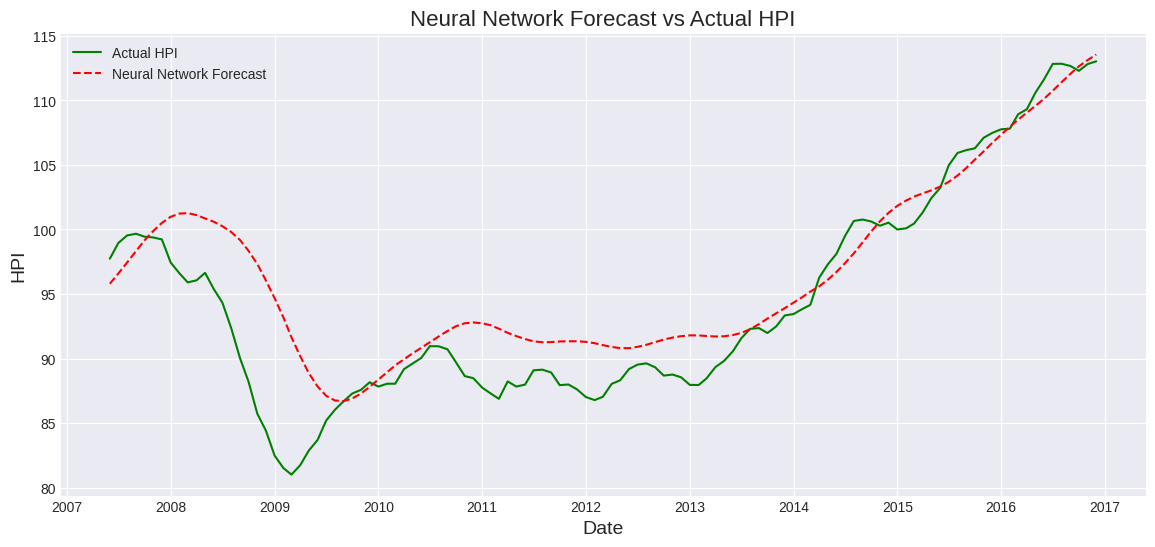

In [ ]:
# prompt: Now generate the code to predict HPI with neural networks, remember to use monthly changes and after prediction change them back to actual values for visualization.

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# Prepare data for neural network
data_for_nn = merged_data[['HPI_All']].copy()  # Consider relevant features

# Scale data to range [0, 1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_for_nn)

# Define lookback window (number of past months to use for prediction)
lookback = 12

# Create dataset with lookback window
X, Y = [], []
for i in range(lookback, len(data_scaled)):
  X.append(data_scaled[i - lookback:i, :])
  Y.append(data_scaled[i, 0])  # Predict HPI

X, Y = np.array(X), np.array(Y)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Define neural network model
model = keras.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=(lookback, data_for_nn.shape[1])),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
Y_pred_scaled = model.predict(X_test)

# Inverse scale predictions to original HPI values
Y_pred = scaler.inverse_transform(np.concatenate((Y_pred_scaled,
                                                X_test[:, -1, 1:]), axis=1))[:, 0]

# Inverse scale actual HPI values
Y_test_original = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1),
                                                  X_test[:, -1, 1:]), axis=1))[:, 0]

# Evaluate model
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
mae = mean_absolute_error(Y_test_original, Y_pred)

print(f'Neural Network RMSE: {rmse:.3f}')
print(f'Neural Network MAE: {mae:.3f}')

# Plot predictions vs actual HPI
plt.figure(figsize=(14, 6))
plt.plot(merged_data.index[train_size + lookback:], Y_test_original, label='Actual HPI', color='green')
plt.plot(merged_data.index[train_size + lookback:], Y_pred, label='Neural Network Forecast', color='red', linestyle='--')
plt.title('Neural Network Forecast vs Actual HPI', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('HPI', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


NN


##ARIMA with bagging

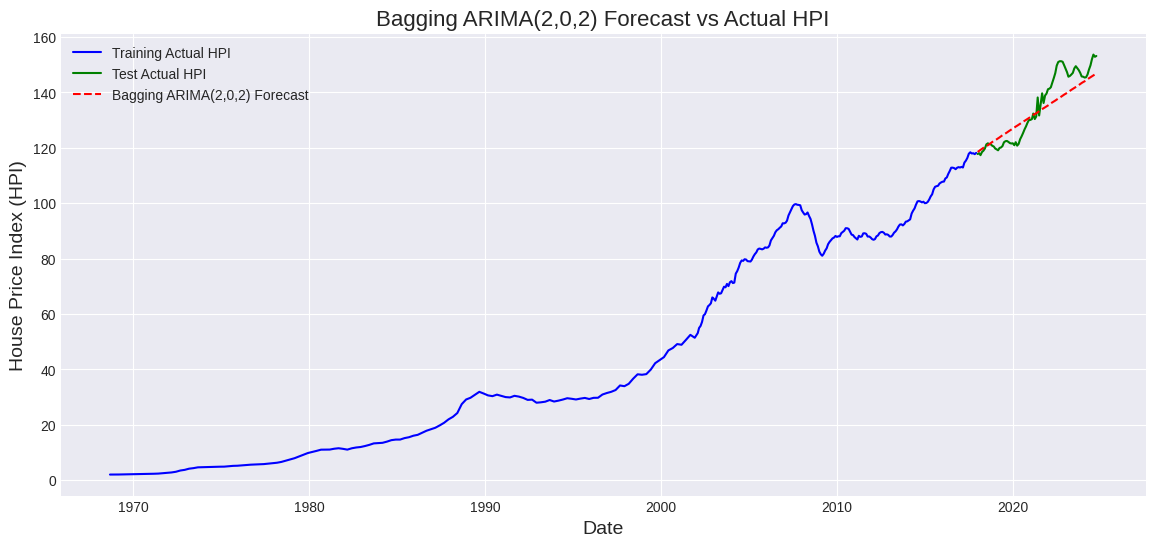

Bagging RMSE: 5.542
Bagging MAE: 4.511


In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import BaggingRegressor
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")  # Suppress convergence warnings for clarity

# Custom ARIMA wrapper for sklearn compatibility
class ARIMARegressor(BaseEstimator, RegressorMixin):
    def __init__(self, order=(2, 0, 2)):
        self.order = order
        self.model_ = None

    def fit(self, X, y):
        self.model_ = ARIMA(endog=y, order=self.order).fit()
        return self

    def predict(self, X):
        forecast = self.model_.forecast(steps=len(X))
        return forecast

# Confirm lengths explicitly
train_size_actual = len(train)
test_size_actual = len(test)

# Define inputs for Bagging
X_train = np.arange(train_size_actual).reshape(-1, 1)
y_train = train.values
X_test = np.arange(train_size_actual, train_size_actual + test_size_actual).reshape(-1, 1)

# Bagging ARIMA model
bagging_arima = BaggingRegressor(
    estimator=ARIMARegressor(order=(2, 0, 2)),
    n_estimators=10,
    random_state=0,
    bootstrap=True
)

# Fit the Bagging ARIMA model
bagging_arima.fit(X_train, y_train)

# Predict differenced values
bagging_forecast_diff = bagging_arima.predict(X_test)

# Correct indexing: directly get last train value safely
last_train_hpi = hpi_diff_final["HPI_All"].iloc[train_size_actual - 1]

# Convert predictions back to original HPI scale
bagging_forecast_hpi = bagging_forecast_diff.cumsum() + last_train_hpi

# Actual test values (original scale)
actual_hpi_test = hpi_diff_final["HPI_All"].iloc[train_size_actual:train_size_actual + test_size_actual]

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(hpi_diff_final.index[:train_size_actual], hpi_diff_final["HPI_All"].iloc[:train_size_actual],
         label='Training Actual HPI', color='blue')
plt.plot(actual_hpi_test.index, actual_hpi_test,
         label='Test Actual HPI', color='green')
plt.plot(actual_hpi_test.index, bagging_forecast_hpi,
         label='Bagging ARIMA(2,0,2) Forecast', color='red', linestyle='--')

plt.title('Bagging ARIMA(2,0,2) Forecast vs Actual HPI', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('House Price Index (HPI)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Evaluate performance metrics
bagging_rmse = np.sqrt(mean_squared_error(actual_hpi_test, bagging_forecast_hpi))
bagging_mae = mean_absolute_error(actual_hpi_test, bagging_forecast_hpi)

print(f"Bagging RMSE: {bagging_rmse:.3f}")
print(f"Bagging MAE: {bagging_mae:.3f}")


## NN with bagging

Training model 1/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
Training model 2/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
Training model 3/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Training model 4/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
Training model 5/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
Training model 6/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
Training model 7/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
Training model 8/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
Training model 9/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Training model 10/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Bagged Neural Network RMSE: 3.743
Bagged Neural Network MAE: 2.746


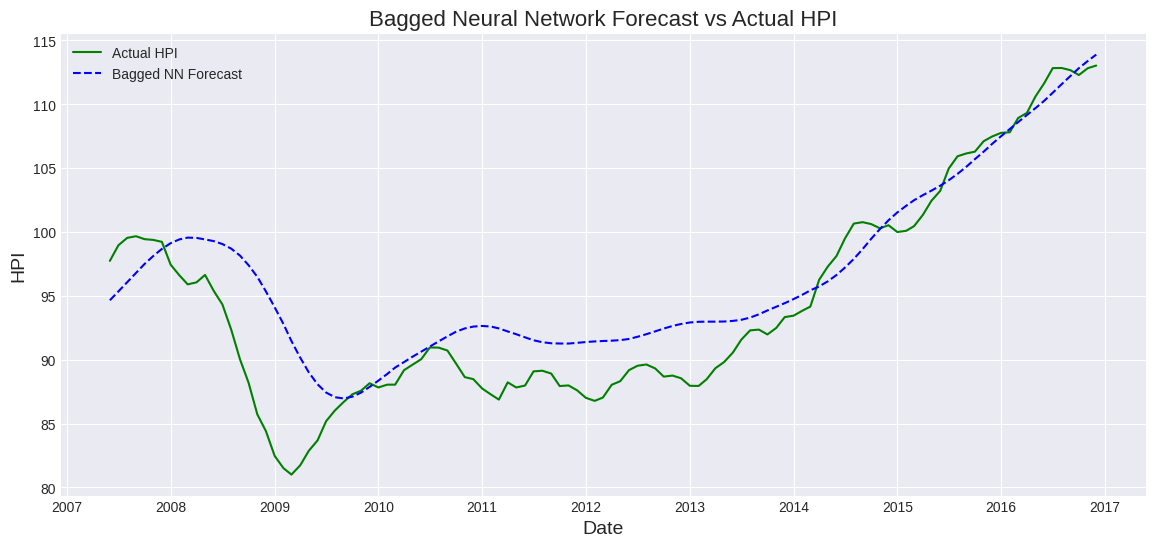

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Parameters
n_estimators = 10  # Number of neural networks
lookback = 12
epochs = 100
batch_size = 32

# Scale and prepare data
data_for_nn = merged_data[['HPI_All', 'Interest_Rate', 'CPI']].copy()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_for_nn)

X, Y = [], []
for i in range(lookback, len(data_scaled)):
    X.append(data_scaled[i - lookback:i, :])
    Y.append(data_scaled[i, 0])
X, Y = np.array(X), np.array(Y)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Bagging ensemble
predictions = []

for i in range(n_estimators):
    print(f"Training model {i+1}/{n_estimators}...")

    # Bootstrap sampling
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_sample, Y_sample = X_train[indices], Y_train[indices]

    # Define model
    model = keras.Sequential([
        keras.layers.LSTM(50, return_sequences=True, input_shape=(lookback, X.shape[2])),
        keras.layers.LSTM(50),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_sample, Y_sample, epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict and store results
    Y_pred_scaled = model.predict(X_test)
    Y_pred = scaler.inverse_transform(np.concatenate((Y_pred_scaled, X_test[:, -1, 1:]), axis=1))[:, 0]
    predictions.append(Y_pred)

# Average predictions from all models
Y_pred_bagged = np.mean(predictions, axis=0)

# Inverse transform true values
Y_test_original = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Evaluate
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred_bagged))
mae = mean_absolute_error(Y_test_original, Y_pred_bagged)

print(f'Bagged Neural Network RMSE: {rmse:.3f}')
print(f'Bagged Neural Network MAE: {mae:.3f}')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(merged_data.index[train_size + lookback:], Y_test_original, label='Actual HPI', color='green')
plt.plot(merged_data.index[train_size + lookback:], Y_pred_bagged, label='Bagged NN Forecast', color='blue', linestyle='--')
plt.title('Bagged Neural Network Forecast vs Actual HPI', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('HPI', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


20 models

Training model 1/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Training model 2/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Training model 3/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Training model 4/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
Training model 5/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Training model 6/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
Training model 7/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Training model 8/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Training model 9/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
Training model 10/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Training model 11/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Training model 12/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Training model 13/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Training model 14/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
Training model 15/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Training model 16/20...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Tr

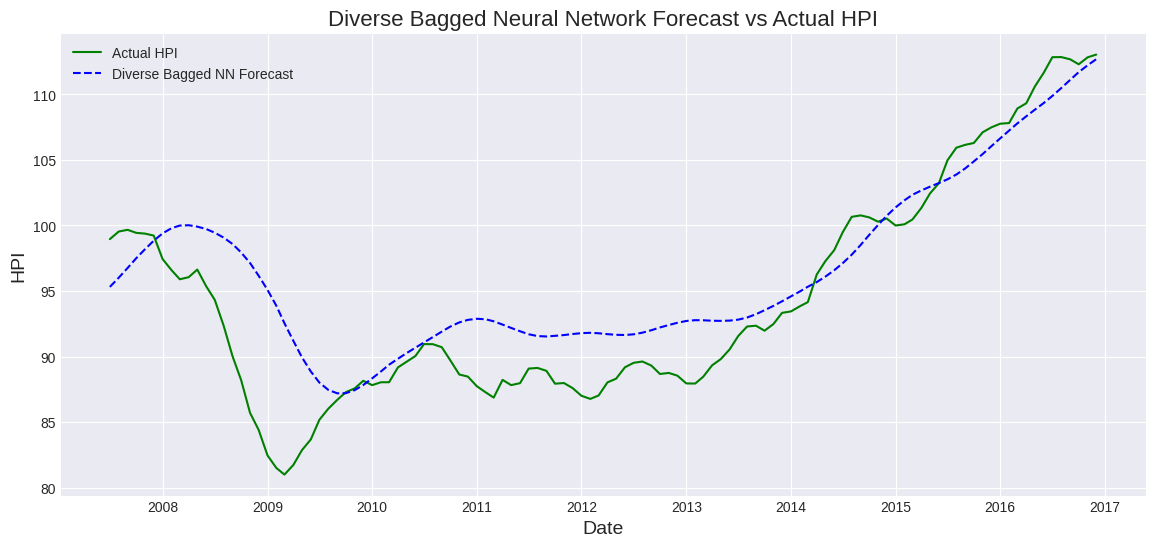

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random

n_estimators = 20
epochs = 100
batch_size = 32
max_lookback = 15  # Use fixed max lookback for consistency

# Step 1: Prepare full dataset for final inverse-transform of actual HPI
full_features = ['HPI_All', 'Interest_Rate', 'CPI']
data_full = merged_data[full_features].copy()
scaler_full = MinMaxScaler()
data_scaled_full = scaler_full.fit_transform(data_full)

# Build consistent test set
X_full, Y_full = [], []
for i in range(max_lookback, len(data_scaled_full)):
    X_full.append(data_scaled_full[i - max_lookback:i, :])
    Y_full.append(data_scaled_full[i, 0])
X_full, Y_full = np.array(X_full), np.array(Y_full)

train_size = int(len(X_full) * 0.8)
X_test_full = X_full[train_size:]
Y_test_scaled = Y_full[train_size:]

# Inverse-transform test HPI
Y_test_original = scaler_full.inverse_transform(
    np.concatenate((Y_test_scaled.reshape(-1, 1), X_test_full[:, -1, 1:]), axis=1)
)[:, 0]

# Step 2: Train ensemble of diverse models
predictions = []

for est in range(n_estimators):
    print(f"Training model {est+1}/{n_estimators}...")

    # Random hyperparameters
    lookback = random.randint(9, max_lookback)
    lstm_units = random.randint(30, 60)
    dropout_rate = round(random.uniform(0.1, 0.3), 2)

    # Random feature drop
    selected_features = ['HPI_All'] + random.sample(['Interest_Rate', 'CPI'], k=1)
    data = merged_data[selected_features].copy()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, Y = [], []
    for j in range(lookback, len(data_scaled)):
        X.append(data_scaled[j - lookback:j, :])
        Y.append(data_scaled[j, 0])
    X, Y = np.array(X), np.array(Y)

    train_size = int(len(X) * 0.8)
    X_train, Y_train = X[:train_size], Y[:train_size]
    X_test = X[train_size:]

    # Bootstrap sampling
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_bootstrap, Y_bootstrap = X_train[indices], Y_train[indices]

    # Build model
    model = keras.Sequential([
        keras.layers.LSTM(lstm_units, return_sequences=True, input_shape=(lookback, X.shape[2])),
        keras.layers.Dropout(dropout_rate),
        keras.layers.LSTM(lstm_units),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_bootstrap, Y_bootstrap, epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict
    Y_pred_scaled = model.predict(X_test)

    # Pad missing features with zeros (to match original scaler)
    missing_features = len(full_features) - len(selected_features)
    Y_pred_padded = np.concatenate((Y_pred_scaled, np.zeros((Y_pred_scaled.shape[0], missing_features))), axis=1)

    # Inverse transform to real HPI
    Y_pred = scaler.inverse_transform(Y_pred_padded)[:, 0]
    predictions.append(Y_pred)

# Step 3: Average predictions and align lengths
min_len = min(len(p) for p in predictions)
predictions_trimmed = [p[-min_len:] for p in predictions]
Y_pred_bagged = np.mean(predictions_trimmed, axis=0)
Y_test_original_trimmed = Y_test_original[-min_len:]

# Step 4: Evaluation
rmse = np.sqrt(mean_squared_error(Y_test_original_trimmed, Y_pred_bagged))
mae = mean_absolute_error(Y_test_original_trimmed, Y_pred_bagged)

print(f'\n✅ Diverse Bagged NN RMSE: {rmse:.3f}')
print(f'✅ Diverse Bagged NN MAE: {mae:.3f}')

# Step 5: Plotting
plt.figure(figsize=(14, 6))
plt.plot(merged_data.index[-min_len:], Y_test_original_trimmed, label='Actual HPI', color='green')
plt.plot(merged_data.index[-min_len:], Y_pred_bagged, label='Diverse Bagged NN Forecast', color='blue', linestyle='--')
plt.title('Diverse Bagged Neural Network Forecast vs Actual HPI', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('HPI', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


100 models

Training model 1/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Training model 2/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Training model 3/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Training model 4/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
Training model 5/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Training model 6/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Training model 7/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Training model 8/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Training model 9/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Training model 10/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Training model 11/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Training model 12/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Training model 13/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
Training model 14/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Training model 15/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Training model 16/100...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s

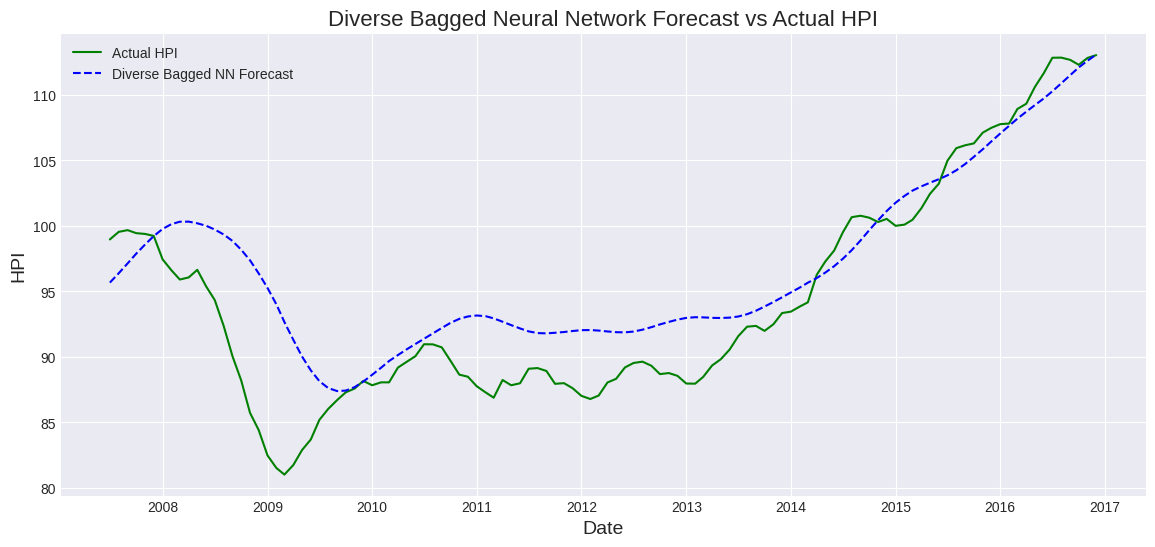

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random

n_estimators = 100
epochs = 100
batch_size = 32
max_lookback = 15  # Use fixed max lookback for consistency

# Step 1: Prepare full dataset for final inverse-transform of actual HPI
full_features = ['HPI_All', 'Interest_Rate', 'CPI']
data_full = merged_data[full_features].copy()
scaler_full = MinMaxScaler()
data_scaled_full = scaler_full.fit_transform(data_full)

# Build consistent test set
X_full, Y_full = [], []
for i in range(max_lookback, len(data_scaled_full)):
    X_full.append(data_scaled_full[i - max_lookback:i, :])
    Y_full.append(data_scaled_full[i, 0])
X_full, Y_full = np.array(X_full), np.array(Y_full)

train_size = int(len(X_full) * 0.8)
X_test_full = X_full[train_size:]
Y_test_scaled = Y_full[train_size:]

# Inverse-transform test HPI
Y_test_original = scaler_full.inverse_transform(
    np.concatenate((Y_test_scaled.reshape(-1, 1), X_test_full[:, -1, 1:]), axis=1)
)[:, 0]

# Step 2: Train ensemble of diverse models
predictions = []

for est in range(n_estimators):
    print(f"Training model {est+1}/{n_estimators}...")

    # Random hyperparameters
    lookback = random.randint(9, max_lookback)
    lstm_units = random.randint(30, 60)
    dropout_rate = round(random.uniform(0.1, 0.3), 2)

    # Random feature drop
    selected_features = ['HPI_All'] + random.sample(['Interest_Rate', 'CPI'], k=1)
    data = merged_data[selected_features].copy()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, Y = [], []
    for j in range(lookback, len(data_scaled)):
        X.append(data_scaled[j - lookback:j, :])
        Y.append(data_scaled[j, 0])
    X, Y = np.array(X), np.array(Y)

    train_size = int(len(X) * 0.8)
    X_train, Y_train = X[:train_size], Y[:train_size]
    X_test = X[train_size:]

    # Bootstrap sampling
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_bootstrap, Y_bootstrap = X_train[indices], Y_train[indices]

    # Build model
    model = keras.Sequential([
        keras.layers.LSTM(lstm_units, return_sequences=True, input_shape=(lookback, X.shape[2])),
        keras.layers.Dropout(dropout_rate),
        keras.layers.LSTM(lstm_units),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_bootstrap, Y_bootstrap, epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict
    Y_pred_scaled = model.predict(X_test)

    # Pad missing features with zeros (to match original scaler)
    missing_features = len(full_features) - len(selected_features)
    Y_pred_padded = np.concatenate((Y_pred_scaled, np.zeros((Y_pred_scaled.shape[0], missing_features))), axis=1)

    # Inverse transform to real HPI
    Y_pred = scaler.inverse_transform(Y_pred_padded)[:, 0]
    predictions.append(Y_pred)

# Step 3: Average predictions and align lengths
min_len = min(len(p) for p in predictions)
predictions_trimmed = [p[-min_len:] for p in predictions]
Y_pred_bagged = np.mean(predictions_trimmed, axis=0)
Y_test_original_trimmed = Y_test_original[-min_len:]

# Step 4: Evaluation
rmse = np.sqrt(mean_squared_error(Y_test_original_trimmed, Y_pred_bagged))
mae = mean_absolute_error(Y_test_original_trimmed, Y_pred_bagged)

print(f'\n✅ Diverse Bagged NN RMSE: {rmse:.3f}')
print(f'✅ Diverse Bagged NN MAE: {mae:.3f}')

# Step 5: Plotting
plt.figure(figsize=(14, 6))
plt.plot(merged_data.index[-min_len:], Y_test_original_trimmed, label='Actual HPI', color='green')
plt.plot(merged_data.index[-min_len:], Y_pred_bagged, label='Diverse Bagged NN Forecast', color='blue', linestyle='--')
plt.title('Diverse Bagged Neural Network Forecast vs Actual HPI', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('HPI', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


1000 models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random

n_estimators = 1000
epochs = 100
batch_size = 32
max_lookback = 15  # Use fixed max lookback for consistency

# Step 1: Prepare full dataset for final inverse-transform of actual HPI
full_features = ['HPI_All', 'Interest_Rate', 'CPI']
data_full = merged_data[full_features].copy()
scaler_full = MinMaxScaler()
data_scaled_full = scaler_full.fit_transform(data_full)

# Build consistent test set
X_full, Y_full = [], []
for i in range(max_lookback, len(data_scaled_full)):
    X_full.append(data_scaled_full[i - max_lookback:i, :])
    Y_full.append(data_scaled_full[i, 0])
X_full, Y_full = np.array(X_full), np.array(Y_full)

train_size = int(len(X_full) * 0.8)
X_test_full = X_full[train_size:]
Y_test_scaled = Y_full[train_size:]

# Inverse-transform test HPI
Y_test_original = scaler_full.inverse_transform(
    np.concatenate((Y_test_scaled.reshape(-1, 1), X_test_full[:, -1, 1:]), axis=1)
)[:, 0]

# Step 2: Train ensemble of diverse models
predictions = []

for est in range(n_estimators):
    print(f"Training model {est+1}/{n_estimators}...")

    # Random hyperparameters
    lookback = random.randint(9, max_lookback)
    lstm_units = random.randint(30, 60)
    dropout_rate = round(random.uniform(0.1, 0.3), 2)

    # Random feature drop
    selected_features = ['HPI_All'] + random.sample(['Interest_Rate', 'CPI'], k=1)
    data = merged_data[selected_features].copy()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, Y = [], []
    for j in range(lookback, len(data_scaled)):
        X.append(data_scaled[j - lookback:j, :])
        Y.append(data_scaled[j, 0])
    X, Y = np.array(X), np.array(Y)

    train_size = int(len(X) * 0.8)
    X_train, Y_train = X[:train_size], Y[:train_size]
    X_test = X[train_size:]

    # Bootstrap sampling
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_bootstrap, Y_bootstrap = X_train[indices], Y_train[indices]

    # Build model
    model = keras.Sequential([
        keras.layers.LSTM(lstm_units, return_sequences=True, input_shape=(lookback, X.shape[2])),
        keras.layers.Dropout(dropout_rate),
        keras.layers.LSTM(lstm_units),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_bootstrap, Y_bootstrap, epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict
    Y_pred_scaled = model.predict(X_test)

    # Pad missing features with zeros (to match original scaler)
    missing_features = len(full_features) - len(selected_features)
    Y_pred_padded = np.concatenate((Y_pred_scaled, np.zeros((Y_pred_scaled.shape[0], missing_features))), axis=1)

    # Inverse transform to real HPI
    Y_pred = scaler.inverse_transform(Y_pred_padded)[:, 0]
    predictions.append(Y_pred)

# Step 3: Average predictions and align lengths
min_len = min(len(p) for p in predictions)
predictions_trimmed = [p[-min_len:] for p in predictions]
Y_pred_bagged = np.mean(predictions_trimmed, axis=0)
Y_test_original_trimmed = Y_test_original[-min_len:]

# Step 4: Evaluation
rmse = np.sqrt(mean_squared_error(Y_test_original_trimmed, Y_pred_bagged))
mae = mean_absolute_error(Y_test_original_trimmed, Y_pred_bagged)

print(f'\n✅ Diverse Bagged NN RMSE: {rmse:.3f}')
print(f'✅ Diverse Bagged NN MAE: {mae:.3f}')

# Step 5: Plotting
plt.figure(figsize=(14, 6))
plt.plot(merged_data.index[-min_len:], Y_test_original_trimmed, label='Actual HPI', color='green')
plt.plot(merged_data.index[-min_len:], Y_pred_bagged, label='Diverse Bagged NN Forecast', color='blue', linestyle='--')
plt.title('Diverse Bagged Neural Network Forecast vs Actual HPI', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('HPI', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


Training model 1/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Training model 2/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Training model 3/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Training model 4/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
Training model 5/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Training model 6/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
Training model 7/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Training model 8/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
Training model 9/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Training model 10/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Training model 11/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Training model 12/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Training model 13/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
Training model 14/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Training model 15/1000...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Training model 16/1000...
4/4 ━━━━━

##Basic NNs pipelini 16.04.2025

Simple LSTM origins:   0%|          | 0/114 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())



Single LSTM on Quarterly Data:
 h=1: MAE=1.223, RMSE=1.690
 h=2: MAE=2.095, RMSE=2.915
 h=3: MAE=2.833, RMSE=3.868
 h=4: MAE=3.625, RMSE=4.740
 Overall MAE=2.444, RMSE=3.492


TypeError: float() argument must be a string or a real number, not 'Period'

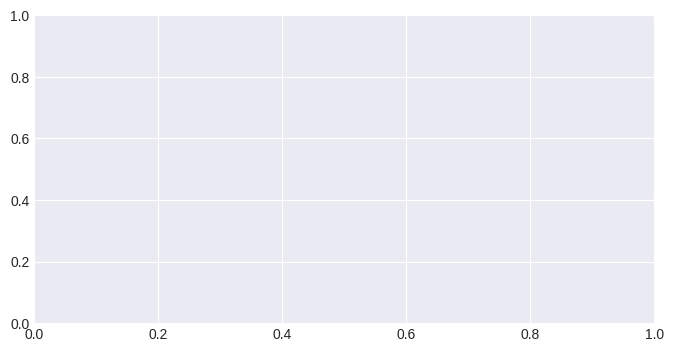

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def run_simple_nn(
    data,
    feature_cols,
    forecast_horizon=4,
    lookback=12,
    init_train_frac=0.4,
    epochs=30,
    batch_size=32
):
    """
    Sliding‑origin LSTM pipeline on quarterly data (no bagging).
    Returns:
      - error_stats: per‑horizon MAE/RMSE
      - aggregated: overall MAE/RMSE
      - final_df: DataFrame of fc_h1…fc_h4 + actual(=1‑step) indexed by origin date
    """
    # 1) compute Q->Q diff of HPI and drop first NaN
    df = data.copy()
    df["HPI_Diff"] = df["HPI_All"].diff().dropna()
    df = df.dropna()

    # 2) scale diffs + externals
    cols = ["HPI_Diff"] + feature_cols
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[cols])
    scaled_df = pd.DataFrame(scaled, index=df.index, columns=cols)

    # 3) sliding‑origin setup
    n = len(scaled_df)
    init_n = max(int(n * init_train_frac), lookback + 1)

    preds = {h: [] for h in range(1, forecast_horizon + 1)}
    acts  = {h: [] for h in range(1, forecast_horizon + 1)}
    dates = []

    for end_ix in tqdm(
        range(init_n, n - forecast_horizon + 1),
        desc="Simple LSTM origins"
    ):
        train_idx = scaled_df.index[:end_ix]
        test_idx  = scaled_df.index[end_ix : end_ix + forecast_horizon]
        last_level = df.loc[train_idx, "HPI_All"].iloc[-1]

        # build train set for this origin
        arr = scaled_df.loc[train_idx].values
        X_train, Y_train = [], []
        for i in range(lookback, arr.shape[0]):
            X_train.append(arr[i - lookback : i])
            Y_train.append(arr[i, 0])
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)

        # fit LSTM
        tf.keras.backend.clear_session()
        model = keras.Sequential([
            keras.Input(shape=(lookback, len(cols))),
            keras.layers.LSTM(32, return_sequences=True),
            keras.layers.LSTM(16),
            keras.layers.Dense(1),
        ])
        model.compile(optimizer="adam", loss="mse")
        model.fit(
            X_train, Y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        # recursive forecast of diffs
        window = arr[-lookback:].copy()
        diffs = []
        for _ in range(forecast_horizon):
            p = model.predict(window.reshape(1, lookback, len(cols)), verbose=0)[0,0]
            diffs.append(p)
            nxt = np.concatenate([[p], window[-1, 1:]])
            window = np.vstack([window, nxt])[-lookback:]

        # invert back to levels
        fc = last_level + np.cumsum(diffs)

        # store
        for h in range(1, forecast_horizon + 1):
            preds[h].append(fc[h-1])
            acts[h].append(df.loc[test_idx[h-1], "HPI_All"])
        dates.append(test_idx[0])

    # 4) compute errors
    error_stats = {}
    all_f, all_a = [], []
    for h in preds:
        f = np.array(preds[h]); a = np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f))
        }
        all_f.extend(f); all_a.extend(a)

    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    # 5) build final‑origin DataFrame using only the 1‑step actuals
    final_df = pd.DataFrame(
        {**{f"fc_h{h}": preds[h] for h in preds},
         "actual": acts[1]},
        index=dates
    )

    return error_stats, aggregated, final_df

# ────────────── USAGE ──────────────────────────────────────────────

# resample your merged_data from monthly → quarterly
merged_data.index = pd.to_datetime(merged_data.index)
quarterly = (
    merged_data
    .resample("QE-DEC")    # use QE-DEC to avoid deprecation warning
    .last()
    .dropna()
)
quarterly.index = quarterly.index.to_period("Q")

# run the single‑LSTM
externals = ["Interest_Rate", "CPI"]
errs_nn, agg_nn, series_nn = run_simple_nn(
    data=quarterly,
    feature_cols=externals,
    forecast_horizon=4,
    lookback=12,
    init_train_frac=0.4,
    epochs=30,
    batch_size=32
)

# report
print("\nSingle LSTM on Quarterly Data:")
for h, stats in errs_nn.items():
    print(f" h={h}: MAE={stats['MAE']:.3f}, RMSE={stats['RMSE']:.3f}")
print(f" Overall MAE={agg_nn['Overall_MAE']:.3f}, RMSE={agg_nn['Overall_RMSE']:.3f}")

# plot final‑origin
plt.figure(figsize=(8,4))
plt.plot(series_nn.index[-4:], series_nn["actual"][-4:], "-o", label="Actual")
for h in range(1,5):
    plt.scatter(
        series_nn.index[-4],
        series_nn[f"fc_h{h}"][-1],
        s=60, label=f"fc h={h}"
    )
plt.title("Single LSTM Final‑Origin Forecasts")
plt.legend()
plt.show()


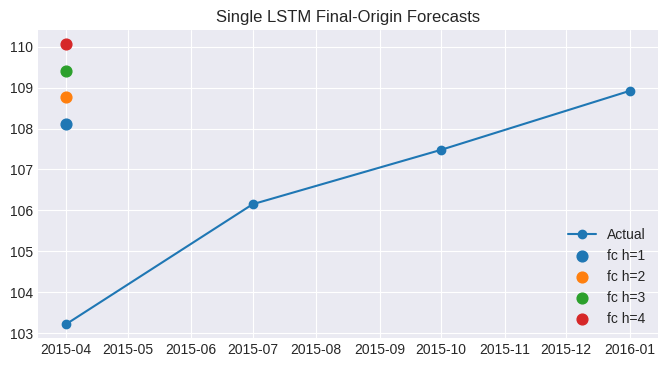

In [ ]:
# plot final‑origin (just convert Periods → Timestamps)
plt.figure(figsize=(8,4))

# grab the last 4 periods and convert to datetime
x_actual = series_nn.index[-4:].to_timestamp()
y_actual = series_nn["actual"][-4:]

plt.plot(x_actual, y_actual, "-o", label="Actual")

# scatter each horizon at the final-origin timestamp
x0 = series_nn.index[-4].to_timestamp()
for h in range(1, 5):
    y_fc = series_nn[f"fc_h{h}"].iloc[-1]
    plt.scatter(x0, y_fc, s=60, label=f"fc h={h}")

plt.title("Single LSTM Final‑Origin Forecasts")
plt.legend()
plt.show()


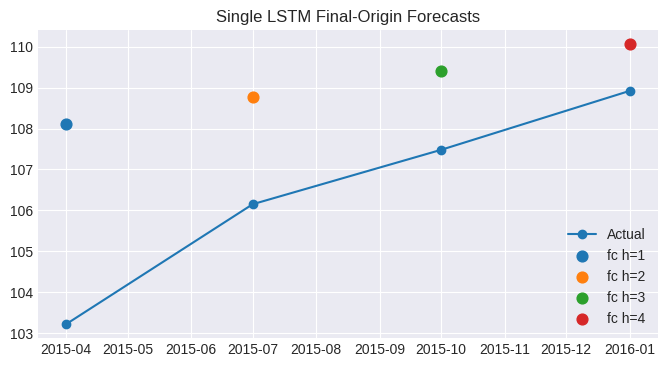

In [ ]:
# grab the four forecast‐target dates and convert to Timestamps
x_horizons = series_nn.index[-4:].to_timestamp()
# grab the actuals for those same four horizons
y_actual   = series_nn["actual"].iloc[-4:]
# grab your four forecasts at the last origin
y_fc       = [series_nn[f"fc_h{h}"].iloc[-1] for h in range(1,5)]

plt.figure(figsize=(8,4))
# plot actuals
plt.plot(x_horizons, y_actual, "-o", label="Actual")

# plot forecasts at the matching dates
for h, x, y in zip(range(1,5), x_horizons, y_fc):
    plt.scatter(x, y, s=60, label=f"fc h={h}")

plt.title("Single LSTM Final‑Origin Forecasts")
plt.legend()
plt.show()


##NN with bagging 16.04 final pipeline

In [ ]:
combined

HPI_All  HPI_Diff
Date                     
1968Q3     1.95      0.06
1968Q4     1.94     -0.01
1969Q1     1.97      0.03
1969Q2     2.00      0.03
1969Q3     2.02      0.02
...         ...       ...
2023Q4   145.80     -3.00
2024Q1   145.50     -0.30
2024Q2   149.80      4.30
2024Q3   152.90      3.10
2024Q4   153.20      0.30

[226 rows x 2 columns]

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def run_bagged_nn(
    data,
    feature_cols,
    forecast_horizon=4,
    lookback=12,
    init_train_frac=0.4,
    B=20,
    epochs=50,
    batch_size=32,
):
    """
    Bagged LSTM pipeline on quarterly data:
     - data: DataFrame indexed by PeriodIndex('Q'), cols=['HPI_All']+feature_cols
     - returns per‑h MAE/RMSE, overall MAE/RMSE, and final‑origin DataFrame
    """
    # 1) make quarterly differences in the level series
    df = data.copy()
    df["HPI_Diff"] = df["HPI_All"].diff().dropna()
    df = df.dropna()

    # 2) scale diffs + externals together
    cols = ["HPI_Diff"] + feature_cols
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[cols])
    scaled_df = pd.DataFrame(scaled, index=df.index, columns=cols)

    n = len(scaled_df)
    init_n = max(int(n * init_train_frac), lookback + 1)

    preds = {h: [] for h in range(1, forecast_horizon + 1)}
    acts  = {h: [] for h in range(1, forecast_horizon + 1)}
    dates = []

    # 3) sliding‑origin + bootstrap
    for end_ix in tqdm(
        range(init_n, n - forecast_horizon + 1),
        desc=f"Bagging B={B} origins"
    ):
        train_idx = scaled_df.index[:end_ix]
        test_idx  = scaled_df.index[end_ix : end_ix + forecast_horizon]
        last_level = df.loc[train_idx, "HPI_All"].iloc[-1]

        bag_levels = np.zeros((B, forecast_horizon))

        for b in range(B):
            # ── bootstrap sample
            boot_idx = np.random.choice(train_idx, size=len(train_idx), replace=True)
            boot = scaled_df.loc[boot_idx].sort_index()

            # ── build lookback windows
            Xb, Yb = [], []
            arr = boot.values
            for i in range(lookback, len(arr)):
                Xb.append(arr[i - lookback : i])
                Yb.append(arr[i, 0])
            Xb, Yb = np.array(Xb), np.array(Yb)

            # ── fit a small LSTM
            tf.keras.backend.clear_session()
            model = keras.Sequential([
                keras.Input(shape=(lookback, len(cols))),
                keras.layers.LSTM(32, return_sequences=True),
                keras.layers.LSTM(16),
                keras.layers.Dense(1),
            ])
            model.compile(optimizer="adam", loss="mse")
            model.fit(Xb, Yb, epochs=epochs, batch_size=batch_size, verbose=0)

            # ── recursively forecast diffs
            window = scaled_df.loc[train_idx[-lookback:]].values.copy()
            diffs = []
            for _ in range(forecast_horizon):
                p = model.predict(window[-lookback:].reshape(1, lookback, len(cols)), verbose=0)[0,0]
                diffs.append(p)
                # append next row (carry externals forward unchanged)
                new = np.zeros(len(cols))
                new[0] = p
                new[1:] = window[-1,1:]
                window = np.vstack([window, new])

            # ── invert back to level
            bag_levels[b] = last_level + np.cumsum(diffs)

        # average B replicates
        avg = bag_levels.mean(axis=0)
        for h in range(1, forecast_horizon + 1):
            preds[h].append(avg[h-1])
            acts[h].append(df.loc[test_idx[h-1], "HPI_All"])
        dates.append(test_idx[0])

    # 4) compute errors
    error_stats = {}
    all_f, all_a = [], []
    for h in range(1, forecast_horizon+1):
        f = np.array(preds[h]); a = np.array(acts[h])
        error_stats[h] = {
            "MAE": mean_absolute_error(a, f),
            "RMSE": np.sqrt(mean_squared_error(a, f))
        }
        all_f.extend(f); all_a.extend(a)

    aggregated = {
        "Overall_MAE": mean_absolute_error(all_a, all_f),
        "Overall_RMSE": np.sqrt(mean_squared_error(all_a, all_f))
    }

    bagged_df = pd.DataFrame(
        {**{f"fc_h{h}": preds[h] for h in preds}, "actual": all_a},
        index=dates
    )

    return error_stats, aggregated, bagged_df

# ─────────────────────────────────────────────────────────────────────────────

# 1) Take your merged monthly data (merged_data) and resample to quarter‑ends
merged_data.index = pd.to_datetime(merged_data.index)
quarterly = (
    merged_data
    .resample("Q")
    .last()               # pick last month of each quarter
    .dropna()             # drop any incomplete tails
)
# 2) Convert to a PeriodIndex quarterly
quarterly.index = quarterly.index.to_period("Q")

# 3) Now run the bagged NN on the quarterly series
externals = ["Interest_Rate", "CPI"]   # or add "Unemployment" as desired
errs, agg, series = run_bagged_nn(
    data=quarterly,
    feature_cols=externals,
    forecast_horizon=4,
    lookback=12,
    init_train_frac=0.4,
    B=10,
    epochs=30,
    batch_size=32
)

print("\nBagged LSTM on Quarterly Data (B=50):")
for h, m in errs.items():
    print(f" h={h} → MAE={m['MAE']:.3f}, RMSE={m['RMSE']:.3f}")
print(f" Overall MAE={agg['Overall_MAE']:.3f}, RMSE={agg['Overall_RMSE']:.3f}")

# 4) Plot the final-origin forecast versus actual
plt.figure(figsize=(8,4))
# actual line
plt.plot(series.index[-4:], series["actual"][-4:], "-o", label="Actual")
# scatter each horizon
for h in range(1,5):
    plt.scatter(series.index[-4], series[f"fc_h{h}"][-1], s=60, label=f"fc h={h}")
plt.title("Bagged LSTM (B=50) Final-Origin Forecasts")
plt.legend()
plt.show()


<ipython-input-44-e2e5d4c11e67>:129: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  .resample("Q")


Bagging B=10 origins:   0%|          | 0/114 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())
/usr/lo

KeyboardInterrupt: 